# Analysis of variation in SARS-CoV2

## Prepping data

If you are running this notebook from [cloned GitHub repo](https://github.com/galaxyproject/SARS-CoV-2/tree/master/genomics/4-Variation) you should have all datafile inplace for this analysis. 

In [1]:
from datetime import date

today = date.today()
print("Last run:", today)

Last run: 2020-06-17


In [2]:
# Set display to the full length

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
!pip install --upgrade seaborn biopython pandasql
!pip install tabulate

Requirement already up-to-date: seaborn in /home/anton/anaconda3/lib/python3.7/site-packages (0.10.1)
Requirement already up-to-date: biopython in /home/anton/anaconda3/lib/python3.7/site-packages (1.77)
Requirement already up-to-date: pandasql in /home/anton/anaconda3/lib/python3.7/site-packages (0.7.3)


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import matplotlib.pyplot as plt
%matplotlib inline

# Panadas display options
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# Seaborn markers and colors:
fc_palette = {".":'b',"MISSENSE":'orange',"NONSENSE":'r','SILENT':'g', 'NONE':'b'}
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}

In [85]:
# Import two datasets
# The number inside `get()` function corresponds to history ID

var_file = 17     # Number of history item with variant list
gb_file = 4      # Number of histoiry item containing genbank annoration for NC_045512

try:
    # In Galaxy
    var_path = get(var_file)
    gb_path = get(gb_file)
    IN_GALAXY = True
except NameError:
    # Local notebook execution
    var_path = 'variants.tsv'
    gb_path = 'https://github.com/galaxyproject/SARS-CoV-2/blob/master/genomics/4-Variation/NC_045512.2.genbank'
    IN_GALAXY = False
!wget https://github.com/galaxyproject/SARS-CoV-2/blob/master/genomics/4-Variation/NC_045512.2.genbank

--2020-06-17 15:06:55--  https://github.com/galaxyproject/SARS-CoV-2/blob/master/genomics/4-Variation/NC_045512.2.genbank
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘NC_045512.2.genbank.1’

NC_045512.2.genbank     [ <=>                ] 346.02K  --.-KB/s    in 0.1s    

2020-06-17 15:06:55 (2.94 MB/s) - ‘NC_045512.2.genbank.1’ saved [354324]



In [93]:
# Clean artifacts of SNPeff from file headers

if var_path.endswith('gz'):
    !cat {var_path} | sed s/EFF\\\[\\\*\\\]\.//g > var.tab
else:
    !cat {var_path} | sed s/EFF\\\[\\\*\\\]\.//g > var.tab

In [94]:
# Create dataframe with variants and only keep variants with allele frequency above 5%
var  = pd.read_csv('var.tab', sep='\t')
!rm var.tab

In [95]:
# Restrict variants to those above 5% AF
var = var[ var['AF']>=0.05]

In [99]:
var['change'] = var['REF']+var['POS'].astype(str)+var['ALT']

In [100]:
var.head()

Sample      CHROM   POS REF      ALT   QUAL  DP        AF  SB  \
0  SRR11859128  NC_045512  2698   T  TACCTTC  184.0  68  0.102941  60   
1  SRR11859128  NC_045512  3761   G        T   79.0  66  0.060606   5   
2  SRR11859128  NC_045512  5393   T        C  229.0  44  0.204545   5   
3  SRR11859128  NC_045512  5497   C        T  151.0  28  0.214286   5   
4  SRR11859128  NC_045512  6403   A        T  176.0  31  0.225806   0   

         DP4    IMPACT  FUNCLASS                             EFFECT    GENE  \
0   56,5,0,7  MODERATE      NONE  CODON_CHANGE_PLUS_CODON_INSERTION  orf1ab   
1  42,20,4,0  MODERATE  MISSENSE              NON_SYNONYMOUS_CODING  orf1ab   
2   28,7,9,0  MODERATE  MISSENSE              NON_SYNONYMOUS_CODING  orf1ab   
3   15,7,6,0       LOW    SILENT                  SYNONYMOUS_CODING  orf1ab   
4   24,0,7,0       LOW    SILENT                  SYNONYMOUS_CODING  orf1ab   

           CODON        change  
0  aca/acCTTCACa  T2698TACCTTC  
1        Gta/Tta        G3761T  
2        Ttt/Ctt        T5393C  
3        tgC/tgT        C5497T  
4        ccA/ccT        A6403T

In [52]:
# Extract metadata from SRA accessions and stick into a dataframe
# This is a cumbersome and slow process
# Here we first extract not very detailed metadata using SRR accession
# This because extracting using --detailed flag fails

cmd = 'pysradb metadata {} --detailed --saveto all.txt'.format(' '.join(var['Sample'].unique()))
!{cmd}
md = pd.read_csv('all.txt',sep="\t")
#!rm all.txt

/home/anton/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/home/anton/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [30]:
md[md['study_accession']=='SRP265005']

study_accession experiment_accession  \
0        SRP265005           SRX8409213   
1        SRP265005           SRX8409251   
2        SRP265005           SRX8409250   
3        SRP265005           SRX8409249   
4        SRP265005           SRX8409248   
5        SRP265005           SRX8409247   
6        SRP265005           SRX8409246   
7        SRP265005           SRX8409245   
8        SRP265005           SRX8409244   
9        SRP265005           SRX8409243   
10       SRP265005           SRX8409242   
11       SRP265005           SRX8409241   
12       SRP265005           SRX8409240   
13       SRP265005           SRX8409239   
14       SRP265005           SRX8409238   
15       SRP265005           SRX8409237   
16       SRP265005           SRX8409236   
17       SRP265005           SRX8409235   
18       SRP265005           SRX8409234   
19       SRP265005           SRX8409233   
20       SRP265005           SRX8409232   
21       SRP265005           SRX8409231   
22       SRP265005           SRX8409230   
23       SRP265005           SRX8409229   
24       SRP265005           SRX8409228   
25       SRP265005           SRX8409227   
26       SRP265005           SRX8409226   
27       SRP265005           SRX8409225   
28       SRP265005           SRX8409224   
29       SRP265005           SRX8409223   
30       SRP265005           SRX8409222   
31       SRP265005           SRX8409221   
32       SRP265005           SRX8409220   
33       SRP265005           SRX8409219   
34       SRP265005           SRX8409218   
35       SRP265005           SRX8409217   
36       SRP265005           SRX8409216   
37       SRP265005           SRX8409215   
38       SRP265005           SRX8409214   
39       SRP265005           SRX8409212   
40       SRP265005           SRX8409211   
41       SRP265005           SRX8409210   
42       SRP265005           SRX8409209   

                                   experiment_title  \
0   Severe acute respiratory syndrome coronavirus 2   
1   Severe acute respiratory syndrome coronavirus 2   
2   Severe acute respiratory syndrome coronavirus 2   
3   Severe acute respiratory syndrome coronavirus 2   
4   Severe acute respiratory syndrome coronavirus 2   
5   Severe acute respiratory syndrome coronavirus 2   
6   Severe acute respiratory syndrome coronavirus 2   
7   Severe acute respiratory syndrome coronavirus 2   
8   Severe acute respiratory syndrome coronavirus 2   
9   Severe acute respiratory syndrome coronavirus 2   
10  Severe acute respiratory syndrome coronavirus 2   
11  Severe acute respiratory syndrome coronavirus 2   
12  Severe acute respiratory syndrome coronavirus 2   
13  Severe acute respiratory syndrome coronavirus 2   
14  Severe acute respiratory syndrome coronavirus 2   
15  Severe acute respiratory syndrome coronavirus 2   
16  Severe acute respiratory syndrome coronavirus 2   
17  Severe acute respiratory syndrome coronavirus 2   
18  Severe acute respiratory syndrome coronavirus 2   
19  Severe acute respiratory syndrome coronavirus 2   
20  Severe acute respiratory syndrome coronavirus 2   
21  Severe acute respiratory syndrome coronavirus 2   
22  Severe acute respiratory syndrome coronavirus 2   
23  Severe acute respiratory syndrome coronavirus 2   
24  Severe acute respiratory syndrome coronavirus 2   
25  Severe acute respiratory syndrome coronavirus 2   
26  Severe acute respiratory syndrome coronavirus 2   
27  Severe acute respiratory syndrome coronavirus 2   
28  Severe acute respiratory syndrome coronavirus 2   
29  Severe acute respiratory syndrome coronavirus 2   
30  Severe acute respiratory syndrome coronavirus 2   
31  Severe acute respiratory syndrome coronavirus 2   
32  Severe acute respiratory syndrome coronavirus 2   
33  Severe acute respiratory syndrome coronavirus 2   
34  Severe acute respiratory syndrome coronavirus 2   
35  Severe acute respiratory syndrome coronavirus 2   
36  Severe acute respiratory syndrome coronavirus 2   
37  Severe acute res

In [101]:
## First low-level metadata add metadata
var = pysqldf('select var.*, study_accession,library_strategy,library_source,library_selection,run_alias from var left join md on Sample = run_accession')

In [102]:
var.head()

Sample      CHROM   POS REF      ALT   QUAL  DP        AF  SB  \
0  SRR11859128  NC_045512  2698   T  TACCTTC  184.0  68  0.102941  60   
1  SRR11859128  NC_045512  3761   G        T   79.0  66  0.060606   5   
2  SRR11859128  NC_045512  5393   T        C  229.0  44  0.204545   5   
3  SRR11859128  NC_045512  5497   C        T  151.0  28  0.214286   5   
4  SRR11859128  NC_045512  6403   A        T  176.0  31  0.225806   0   

         DP4    IMPACT  FUNCLASS                             EFFECT    GENE  \
0   56,5,0,7  MODERATE      NONE  CODON_CHANGE_PLUS_CODON_INSERTION  orf1ab   
1  42,20,4,0  MODERATE  MISSENSE              NON_SYNONYMOUS_CODING  orf1ab   
2   28,7,9,0  MODERATE  MISSENSE              NON_SYNONYMOUS_CODING  orf1ab   
3   15,7,6,0       LOW    SILENT                  SYNONYMOUS_CODING  orf1ab   
4   24,0,7,0       LOW    SILENT                  SYNONYMOUS_CODING  orf1ab   

           CODON        change study_accession library_strategy  \
0  aca/acCTTCACa  T2698TACCTTC       SRP265005         AMPLICON   
1        Gta/Tta        G3761T       SRP265005         AMPLICON   
2        Ttt/Ctt        T5393C       SRP265005         AMPLICON   
3        tgC/tgT        C5497T       SRP265005         AMPLICON   
4        ccA/ccT        A6403T       SRP265005         AMPLICON   

  library_source library_selection      run_alias  
0    METAGENOMIC               PCR  UC10.fastq.gz  
1    METAGENOMIC               PCR  UC10.fastq.gz  
2    METAGENOMIC               PCR  UC10.fastq.gz  
3    METAGENOMIC               PCR  UC10.fastq.gz  
4    METAGENOMIC               PCR  UC10.fastq.gz

In [36]:
# Create annotation dictionary

from collections import defaultdict
from Bio import SeqIO
from Bio.SeqUtils import GC
annot = defaultdict(list)

genome = SeqIO.read("NC_045512.2.genbank", "genbank")

for feature in genome.features:
    annot['type'].append(feature.type)
    annot['start'].append(feature.location.start)
    annot['end'].append(feature.location.end)
    annot['gc'].append( GC(genome.seq[feature.location.start:feature.location.end]))
    for base in ['A','C','G','T']:
        annot[base].append(genome.seq[feature.location.start:feature.location.end].count(base))
    if feature.type in ['mat_peptide','CDS']:
        annot['func'].append(feature.qualifiers['product'][0])
        annot['gene'].append(feature.qualifiers['gene'][0])
    elif feature.type == 'stem_loop':
        annot['func'].append(feature.qualifiers['function'][0])
        annot['gene'].append('.')
    elif feature.type == 'gene':
        annot['gene'].append(feature.qualifiers['gene'][0])
        annot['func'].append('.')
    else:
        annot['func'].append('.')
        annot['gene'].append('.')
    annot['strandedness'].append('.')

In [37]:
# Annotations of step-loop structures in frameshifting region

sl = [['head','13469','13474','ss','head'],
['stem','13475','13484','ds','stem 1'],
['loop','13485','13487','ss', 'loop 1'],
['stem','13488','13494','ds', 'stem 2'],
['stem','13495','13504','ds', 'stem 1'],
['stem','13505','13513','ds', 'stem 3'],
['loop','13514','13522','ss', 'loop 2'],
['stem','13523','13532','ds', 'stem 3'],
['loop','13533','13534','ss', 'loop 3'],
['stem','13535','13542','ds', 'stem 2'],
['tail','13543','13546','ss', 'tail']]

In [38]:
# Adding step-loop annotations 

for row in sl:
    annot['type'].append(row[0])
    annot['start'].append(row[1])
    annot['end'].append(row[2])
    annot['gc'].append( GC(genome.seq[int(row[1]):int(row[2])]))
    for base in ['A','C','G','T']:
        annot[base].append(genome.seq[int(row[1]):int(row[2])].count(base))
    annot['func'].append(row[4])
    annot['gene'].append('orf1ab')
    annot['strandedness'].append(row[3])

In [39]:
# Converting to a dataframe

annot = pd.DataFrame.from_dict(annot)

In [40]:
annot

type  start    end          gc     A     C     G     T  \
0        source      0  29903   37.972779  8954  5492  5863  9594   
1         5'UTR      0    265   44.528302    67    63    55    80   
2          gene    265  21555   37.454204  6425  3744  4230  6891   
3           CDS    265  21555   37.454204  6425  3744  4230  6891   
4   mat_peptide    265    805   48.518519   135   116   146   143   
5   mat_peptide    805   2719   39.864159   571   353   410   580   
6   mat_peptide   2719   8554   35.904027  1874   978  1117  1866   
7   mat_peptide   8554  10054   36.466667   399   266   281   554   
8   mat_peptide  10054  10972   38.126362   258   163   187   310   
9   mat_peptide  10972  11842   36.321839   210   144   172   344   
10  mat_peptide  11842  12091   38.152610    79    49    46    75   
11  mat_peptide  12091  12685   38.383838   193   107   121   173   
12  mat_peptide  12685  13024   40.117994   105    64    72    98   
13  mat_peptide  13024  13441   42.446043   116    84    93   124   
14  mat_peptide  13441  16236   37.280859   846   501   541   907   
15  mat_peptide  16236  18039   38.158625   547   337   351   568   
16  mat_peptide  18039  19620   38.266920   464   289   316   512   
17  mat_peptide  19620  20658   34.007707   344   150   203   341   
18  mat_peptide  20658  21552   35.458613   282   143   174   295   
19          CDS    265  13483   37.728855  3950  2331  2656  4281   
20  mat_peptide  13441  13480   46.153846     8     7    11    13   
21    stem_loop  13475  13503   60.714286     5     9     8     6   
22    stem_loop  13487  13542   56.363636    12    16    15    12   
23         gene  21562  25384   37.310309  1125   723   703  1271   
24          CDS  21562  25384   37.310309  1125   723   703  1271   
25         gene  25392  26220   39.492754   225   174   153   276   
26          CDS  25392  26220   39.492754   225   174   153   276   
27         gene  26244  26472   38.157895    49    45    42    92   
28          CDS  26244  26472   38.157895    49    45    42    92   
29         gene  26522  27191   42.600897   171   146   139   213   
30          CDS  26522  27191   42.600897   171   146   139   213   
31         gene  27201  27387   27.956989    68    26    26    66   
32          CDS  27201  27387   27.956989    68    26    26    66   
33         gene  27393  27759   38.251366   108    79    61   118   
34          CDS  27393  27759   38.251366   108    79    61   118   
35         gene  27755  27887   31.060606    31    24    17    60   
36          CDS  27755  27887   31.060606    31    24    17    60   
37         gene  27893  28259   35.792350   101    64    67   134   
38          CDS  27893  28259   35.792350   101    64    67   134   
39         gene  28273  29533   47.222222   400   315   280   265   
40          CDS  28273  29533   47.222222   400   315   280   265   
41         gene  29557  29674   34.188034    35    21    19    42   
42          CDS  29557  29674   34.188034    35    21    19    42   
43    stem_loop  29608  29644   36.111111    13     7     6    10   
44    stem_loop  29628  29657   31.034483    12     4     5     8   
45        3'UTR  29674  29903   36.244541    93    36    47    53   
46    stem_loop  29727  29768   56.097561    11    10    13     7   
47         head  13469  13474   40.000000     0     0     2     3   
48         stem  13475  13484   55.555556     2     1     4     2   
49         loop  13485  13487  100.000000     0     1     1     0   
50         stem  13488  13494   83.333333     0     3     2     1   
51         stem  13495  13504   44.444444     2     3     1     3   
52         stem  13505  13513   75.000000     2     3     3     0   
53         loop  13514  13522   37.500000     3     2     1     2   
54         stem  13523  13532   44.444444     1     1     3     4   
55         loop  13533  13534    0.000000     0     0     0     1   
56         stem  13535  13542   71.428571     1     2     3     1   
57       

In [41]:
# Clean annotations by removing redundancy

annot.drop(index=[0,3,19],inplace=True)
annot.drop(index=annot[annot['type']=='gene'].index,inplace=True)

In [42]:
annot

type  start    end          gc     A    C     G     T  \
1         5'UTR      0    265   44.528302    67   63    55    80   
4   mat_peptide    265    805   48.518519   135  116   146   143   
5   mat_peptide    805   2719   39.864159   571  353   410   580   
6   mat_peptide   2719   8554   35.904027  1874  978  1117  1866   
7   mat_peptide   8554  10054   36.466667   399  266   281   554   
8   mat_peptide  10054  10972   38.126362   258  163   187   310   
9   mat_peptide  10972  11842   36.321839   210  144   172   344   
10  mat_peptide  11842  12091   38.152610    79   49    46    75   
11  mat_peptide  12091  12685   38.383838   193  107   121   173   
12  mat_peptide  12685  13024   40.117994   105   64    72    98   
13  mat_peptide  13024  13441   42.446043   116   84    93   124   
14  mat_peptide  13441  16236   37.280859   846  501   541   907   
15  mat_peptide  16236  18039   38.158625   547  337   351   568   
16  mat_peptide  18039  19620   38.266920   464  289   316   512   
17  mat_peptide  19620  20658   34.007707   344  150   203   341   
18  mat_peptide  20658  21552   35.458613   282  143   174   295   
20  mat_peptide  13441  13480   46.153846     8    7    11    13   
21    stem_loop  13475  13503   60.714286     5    9     8     6   
22    stem_loop  13487  13542   56.363636    12   16    15    12   
24          CDS  21562  25384   37.310309  1125  723   703  1271   
26          CDS  25392  26220   39.492754   225  174   153   276   
28          CDS  26244  26472   38.157895    49   45    42    92   
30          CDS  26522  27191   42.600897   171  146   139   213   
32          CDS  27201  27387   27.956989    68   26    26    66   
34          CDS  27393  27759   38.251366   108   79    61   118   
36          CDS  27755  27887   31.060606    31   24    17    60   
38          CDS  27893  28259   35.792350   101   64    67   134   
40          CDS  28273  29533   47.222222   400  315   280   265   
42          CDS  29557  29674   34.188034    35   21    19    42   
43    stem_loop  29608  29644   36.111111    13    7     6    10   
44    stem_loop  29628  29657   31.034483    12    4     5     8   
45        3'UTR  29674  29903   36.244541    93   36    47    53   
46    stem_loop  29727  29768   56.097561    11   10    13     7   
47         head  13469  13474   40.000000     0    0     2     3   
48         stem  13475  13484   55.555556     2    1     4     2   
49         loop  13485  13487  100.000000     0    1     1     0   
50         stem  13488  13494   83.333333     0    3     2     1   
51         stem  13495  13504   44.444444     2    3     1     3   
52         stem  13505  13513   75.000000     2    3     3     0   
53         loop  13514  13522   37.500000     3    2     1     2   
54         stem  13523  13532   44.444444     1    1     3     4   
55         loop  13533  13534    0.000000     0    0     0     1   
56         stem  13535  13542   71.428571     1    2     3     1   
57         tail  13543  13546   33.333333     0    0     1     2   

                                                 func    gene strandedness  
1                                                   .       .            .  
4                                      leader protein  orf1ab            .  
5                                                nsp2  orf1ab            .  
6                                                nsp3  orf1ab            .  
7                                                nsp4  orf1ab            .  
8                                  3C-like proteinase  orf1ab            .  
9                                                nsp6  orf1ab            .  
10                                               nsp7  orf1ab            .  
11                                               nsp8  orf1ab            .  
12                                               nsp9  orf1ab            .  
13                                              nsp10  orf1ab            .  
14                       R

In [43]:
# Create translation dict to shorted the names of functional elements

translate_names = {'.':'.',
 'leader protein':'leader',
 'nsp2':'nsp2',
 'nsp3':'nsp3',
 'nsp4':'nsp4',
 '3C-like proteinase':'3Cpro',
 'nsp6':'nsp6',
 'nsp7':'nsp7',
 'nsp8':'nsp8',
 'nsp9':'nsp9',
 'nsp10':'nsp10',
 'RNA-dependent RNA polymerase':'RdRp',
 'helicase':'helicase',
 "3'-to-5' exonuclease":'ExoN',
 'endoRNAse':'endoR',
 "2'-O-ribose methyltransferase":"MethTr",
 'nsp11':'nsp11',
 'Coronavirus frameshifting stimulation element stem-loop 1':'FS SL1',
 'Coronavirus frameshifting stimulation element stem-loop 2':'FS SL2',
 'surface glycoprotein':'S',
 'ORF3a protein':'orf3a',
 'envelope protein':'E',
 'membrane glycoprotein':'M',
 'ORF6 protein':'orf6',
 'ORF7a protein':'orf7a',
 'ORF7b':'orf7b',
 'ORF8 protein':'orf8',
 'nucleocapsid phosphoprotein':'N',
 'ORF10 protein':'orf10',
 "Coronavirus 3' UTR pseudoknot stem-loop 1":'3-UTR SL1',
 "Coronavirus 3' UTR pseudoknot stem-loop 2":'3-UTR SL2',
 '.':'.',
 "Coronavirus 3' stem-loop II-like motif (s2m)":'S2M',
 'head':'head',
 'stem 1':'S1a',
 'loop 1':'L1',
 'stem 2':'S2a',
 'stem 1':'S1b',
 'stem 3':'S3a',
 'loop 2':'L2',
 'stem 3':'S3b',
 'loop 3':'L3',
 'stem 2':'S2b',
 'tail':'tail'}

In [44]:
annot['start'] = annot['start'].astype(int)
annot['end'] = annot['end'].astype(int)
annot['L'] = annot['end']-annot['start']

In [45]:
for key in translate_names.keys():
    annot.loc[annot.func == key, 'func'] = translate_names[key]

In [46]:
annot

type  start    end          gc     A    C     G     T       func  \
1         5'UTR      0    265   44.528302    67   63    55    80          .   
4   mat_peptide    265    805   48.518519   135  116   146   143     leader   
5   mat_peptide    805   2719   39.864159   571  353   410   580       nsp2   
6   mat_peptide   2719   8554   35.904027  1874  978  1117  1866       nsp3   
7   mat_peptide   8554  10054   36.466667   399  266   281   554       nsp4   
8   mat_peptide  10054  10972   38.126362   258  163   187   310      3Cpro   
9   mat_peptide  10972  11842   36.321839   210  144   172   344       nsp6   
10  mat_peptide  11842  12091   38.152610    79   49    46    75       nsp7   
11  mat_peptide  12091  12685   38.383838   193  107   121   173       nsp8   
12  mat_peptide  12685  13024   40.117994   105   64    72    98       nsp9   
13  mat_peptide  13024  13441   42.446043   116   84    93   124      nsp10   
14  mat_peptide  13441  16236   37.280859   846  501   541   907       RdRp   
15  mat_peptide  16236  18039   38.158625   547  337   351   568   helicase   
16  mat_peptide  18039  19620   38.266920   464  289   316   512       ExoN   
17  mat_peptide  19620  20658   34.007707   344  150   203   341      endoR   
18  mat_peptide  20658  21552   35.458613   282  143   174   295     MethTr   
20  mat_peptide  13441  13480   46.153846     8    7    11    13      nsp11   
21    stem_loop  13475  13503   60.714286     5    9     8     6     FS SL1   
22    stem_loop  13487  13542   56.363636    12   16    15    12     FS SL2   
24          CDS  21562  25384   37.310309  1125  723   703  1271          S   
26          CDS  25392  26220   39.492754   225  174   153   276      orf3a   
28          CDS  26244  26472   38.157895    49   45    42    92          E   
30          CDS  26522  27191   42.600897   171  146   139   213          M   
32          CDS  27201  27387   27.956989    68   26    26    66       orf6   
34          CDS  27393  27759   38.251366   108   79    61   118      orf7a   
36          CDS  27755  27887   31.060606    31   24    17    60      orf7b   
38          CDS  27893  28259   35.792350   101   64    67   134       orf8   
40          CDS  28273  29533   47.222222   400  315   280   265          N   
42          CDS  29557  29674   34.188034    35   21    19    42      orf10   
43    stem_loop  29608  29644   36.111111    13    7     6    10  3-UTR SL1   
44    stem_loop  29628  29657   31.034483    12    4     5     8  3-UTR SL2   
45        3'UTR  29674  29903   36.244541    93   36    47    53          .   
46    stem_loop  29727  29768   56.097561    11   10    13     7        S2M   
47         head  13469  13474   40.000000     0    0     2     3       head   
48         stem  13475  13484   55.555556     2    1     4     2        S1b   
49         loop  13485  13487  100.000000     0    1     1     0         L1   
50         stem  13488  13494   83.333333     0    3     2     1        S2b   
51         stem  13495  13504   44.444444     2    3     1     3        S1b   
52         stem  13505  13513   75.000000     2    3     3     0        S3b   
53         loop  13514  13522   37.500000     3    2     1     2         L2   
54         stem  13523  13532   44.444444     1    1     3     4        S3b   
55         loop  13533  13534    0.000000     0    0     0     1         L3   
56         stem  13535  13542   71.428571     1    2     3     1        S2b   
57         tail  13543  13546   33.333333     0    0     1     2       tail   

      gene strandedness     L  
1        .            .   265  
4   orf1ab            .   540  
5   orf1ab            .  1914  
6   orf1ab            .  5835  
7   orf1ab            .  1500  
8   orf1ab            .   918  
9   orf1ab            .   870  
10  orf1ab            .   249  
11  orf1ab            .   594  
12  orf1ab            .   339  
13  orf1ab            .   417  
14  orf1ab            .  2795  
15  orf1ab            .  1803  
16  orf

In [103]:
# Create variatuion annotation (va) dataframe that is used throughout downstream analysis

va = pysqldf('select var.*, type, func, start,end,A, C, G, T from var left join annot on var.POS >= start-1 and var.POS <= end where type != "source"')

In [48]:
va

Sample      CHROM    POS          REF ALT     QUAL    DP        AF  \
0     SRR11859152  NC_045512    241            C   T  14287.0   436  0.935780   
1     SRR11859158  NC_045512     21            C   T    265.0    17  0.705882   
2     SRR11859133  NC_045512    241            C   T  49314.0  4476  0.985702   
3     SRR11859134  NC_045512    241            C   T  49314.0  3502  0.980297   
4     SRR11859135  NC_045512    241            C   T    517.0    14  1.000000   
...           ...        ...    ...          ...  ..      ...   ...       ...   
1323  SRR11859131  NC_045512  29736  GGCCACGCGGA   G    127.0    26  0.153846   
1324  SRR11859137  NC_045512  29750            C   T    192.0    27  0.259259   
1325  SRR11859142  NC_045512  29747            G   A  20475.0   625  0.932800   
1326  SRR11859135  NC_045512  13521            T   C    242.0    74  0.135135   
1327  SRR11859158  NC_045512  13527            T   G    114.0    56  0.107143   

      SB            DP4    IMPACT  FUNCLASS                 EFFECT    GENE  \
0      0    0,0,259,177         .         .                      .       .   
1      2       4,0,10,3         .         .                      .       .   
2      0  0,0,2396,2070         .         .                      .       .   
3      2  7,4,1828,1650         .         .                      .       .   
4      0        0,0,8,6         .         .                      .       .   
...   ..            ...       ...       ...                    ...     ...   
1323   0      11,11,2,2         .         .                      .       .   
1324   8       7,13,0,7         .         .                      .       .   
1325   0    0,0,234,386         .         .                      .       .   
1326   0      33,31,5,5       LOW    SILENT      SYNONYMOUS_CODING  orf1ab   
1327  16      27,23,0,6  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab   

        CODON        change study_accession library_strategy library_source  \
0           .            CT       SRP265005         AMPLICON    METAGENOMIC   
1           .            CT       SRP265005         AMPLICON    METAGENOMIC   
2           .            CT       SRP265005         AMPLICON    METAGENOMIC   
3           .            CT       SRP265005         AMPLICON    METAGENOMIC   
4           .            CT       SRP265005         AMPLICON    METAGENOMIC   
...       ...           ...             ...              ...            ...   
1323        .  GGCCACGCGGAG       SRP265005         AMPLICON    METAGENOMIC   
1324        .            CT       SRP265005         AMPLICON    METAGENOMIC   
1325        .            GA       SRP265005         AMPLICON    METAGENOMIC   
1326  agT/agC            TC       SRP265005         AMPLICON    METAGENOMIC   
1327  gaT/gaG            TG       SRP265005         AMPLICON    METAGENOMIC   

     library_selection      run_alias       type func  start    end   A   C  \
0                  PCR  UC26.fastq.gz      5'UTR    .      0    265  67  63   
1                  PCR   UC3.fastq.gz      5'UTR    .      0    265  67  63   
2                  PCR  UC48.fastq.gz      5'UTR    .      0    265  67  63   
3                  PCR  UC47.fastq.gz      5'UTR    .      0    265  67  63   
4                  PCR  UC46.fastq.gz      5'UTR    .      0    265  67  63   
...                ...            ...        ...  ...    ...    ...  ..  ..   
1323               PCR   UC7.fastq.gz  stem_loop  S2M  29727  29768  11  10   
1324               PCR  UC45.fastq.gz  stem_loop  S2M  29727  29768  11  10   
1325               PCR  UC40.fastq.gz  stem_loop  S2M  29727  29768  11  10   
1326               PCR  UC46.fastq.gz       loop   L2  13514  13522   3   2   
1327               PCR   UC3.fastq.gz       stem  S3b  13523  13532   1   1   

       G   T  
0     55  80  
1     55  80  
2     55  80  
3     55  80  
4     55  80  
...   ..  ..  
1323  13   7  
1324  13   7  
1325  13   7  
1326   1   2  
1327   3   4  

[1328 rows x 29 column

In [104]:
va.drop(columns=['CHROM'],inplace=True)

In [50]:
# A little function for displaying things

import matplotlib.pyplot as plt
from matplotlib import rcParams
def minimap(variants,x,y,annot,size_col,hue_col,style_col,title):
    sns.set_context("poster")
    sns.set_style("whitegrid")
    plt.figure(figsize=(30,10))
    markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}
    sns.relplot(x=x,y=y,data=variants,legend='brief',alpha=0.6,sizes=(200,2000),markers=markers,palette=fc_palette,height=10,aspect=3,size=size_col,hue=hue_col,style=style_col)
    i = 0
    for index,row in annot.iterrows():
        i += 1
        gene_name = row['func']
        if i % 2 == 0:
            color ='tomato'
            y = -.1
        else:
            color ='deepskyblue'
            y = -.2
        plt.hlines(y,int(row['start']), int(row['end']), linewidth=40,color=color)
        plt.text(int(row['start'])+(int(row['end'])-int(row['start']))//2, y, gene_name,horizontalalignment='center',verticalalignment='center',fontsize=15)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #ticks = [tick for tick in plt.gca().get_yticks() if ( tick >=0 and tick <= 1)]
    ticks = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
    plt.gca().set_yticks(ticks)
    plt.ylim(-0.27, 1)
    plt.xlim(0, 30000)
    plt.suptitle(title,y=1.02)
    plt.show()
    
#sns.relplot(x='POS',y='AFrange',data=pysqldf('select *, maxAF-minAF as AFrange from va where maxAF >= 0.95 and minAF < 0.95 and FUNCLASS != "SILENT"'),height=10,aspect=3,size="Studies",sizes=(500,5000),style='FUNCLASS',alpha=0.5,hue='FUNCLASS',palette=fc_palette,markers=markers)

In [51]:
pysqldf('select * from va where AF >= 0.95')

Sample    POS REF ALT     QUAL      DP        AF          SB  \
0    SRR11859133    241   C   T  49314.0    4476  0.985702           0   
1    SRR11859134    241   C   T  49314.0    3502  0.980297           2   
2    SRR11859135    241   C   T    517.0      14  1.000000           0   
3    SRR11859137    241   C   T   2691.0      78  1.000000           0   
4    SRR11859138    241   C   T  49314.0   12270  0.985575           0   
5    SRR11859142    241   C   T  39625.0    1154  0.966205           5   
6    SRR11859133   1059   C   T  49314.0    4758  0.988651           0   
7    SRR11859138   1059   C   T  49314.0   24354  0.991706           0   
8    SRR11859139   1440   G   A  14838.0     413  0.985472           0   
9    SRR11859129   3046   A   G  49314.0  102993  0.959735          13   
10   SRR11859130   3046   A   G  49314.0    5058  0.952550           2   
11   SRR11859136   7798   G   T   5510.0     156  0.987179           0   
12   SRR11859151   3037   C   T   8430.0     247  0.959514           0   
13   SRR11859154   3037   C   T   1610.0      47  0.978723           0   
14   SRR11859155   4776   C   T   1571.0      44  1.000000           0   
15   SRR11859167   3037   C   T    499.0      13  1.000000           0   
16   SRR11859168   3046   A   G  49314.0    5571  0.959074           0   
17   SRR11859133   3037   C   T  49314.0   10700  0.986916           1   
18   SRR11859134   3037   C   T  49314.0   10906  0.991656           2   
19   SRR11859134   8318   C   A  49314.0   19665  0.975795           8   
20   SRR11859135   3037   C   T   2795.0      76  1.000000           0   
21   SRR11859137   3037   C   T  49314.0    1560  0.991667           3   
22   SRR11859138   3037   C   T  49314.0   92031  0.983462          73   
23   SRR11859139   2891   G   A   3985.0     114  1.000000           0   
24   SRR11859142   3037   C   T  49314.0    8098  0.984935           5   
25   SRR11859129   8782   C   T  49314.0   28040  0.950927         249   
26   SRR11859158   9924   C   T   2010.0      56  1.000000           0   
27   SRR11859158   9951   C   T   3586.0     103  0.961165           0   
28   SRR11859159   8782   C   T   1486.0      39  1.000000           0   
29   SRR11859140   8782   C   T  25687.0     806  0.981390          23   
30   SRR11859169   9924   C   T  49314.0    1475  0.989153           0   
31   SRR11859137  11674   C   T  47894.0    1438  0.962448           0   
32   SRR11859133  11916   C   T  49314.0   12235  0.983163           0   
33   SRR11859151  13252   C   T   3447.0      98  0.989796           0   
34   SRR11859151  14408   C   T  11607.0     345  0.973913           0   
35   SRR11859154  14408   C   T    495.0      14  1.000000           0   
36   SRR11859167  14408   C   T    516.0      13  1.000000           0   
37   SRR11859133  14408   C   T  49314.0   25541  0.980071          86   
38   SRR11859134  14408   C   T  49314.0   29478  0.981783         105   
39   SRR11859135  14408   C   T   3855.0     109  0.972477           0   
40   SRR11859137  14408   C   T  49314.0    3150  0.983175           2   
41   SRR11859138  14408   C   T  49314.0  140195  0.979593           2   
42   SRR11859141  14805   C   T  38817.0    1143  0.962380          22   
43   SRR11859142  14408   C   T  49314.0   14646  0.974054           3   
44   SRR11859169  15641   A   C  49314.0    2949  0.975924           4   
45   SRR11859128  17747   C   T   2309.0      66  0.984848           0   
46   SRR11859129  16467   A   G  49314.0   34932  0.957718           0   
47   SRR11859129  16975   G   T  49314.0   31957  0.969021           0   
48   SRR11859129  17747   C   T  49314.0   21480  0.982635           0   
49   SRR11859129  17858   A   G  49314.0   17974  0.960332           0   
50   SRR11859130  16467   A   G  45112.0    1348  0.971068           3   
51   SRR11859130  16975   G   T  18685.0     544  0.979779           0   
52   SRR11859130  17747   C   T  17860.0     512  0.982422           0   
53   SRR118591

In [105]:
va['run_alias'] = va['run_alias'].str.split('.',n=1,expand=True)[0]

In [106]:
va

Sample    POS          REF ALT     QUAL    DP        AF  SB  \
0     SRR11859152    241            C   T  14287.0   436  0.935780   0   
1     SRR11859158     21            C   T    265.0    17  0.705882   2   
2     SRR11859133    241            C   T  49314.0  4476  0.985702   0   
3     SRR11859134    241            C   T  49314.0  3502  0.980297   2   
4     SRR11859135    241            C   T    517.0    14  1.000000   0   
...           ...    ...          ...  ..      ...   ...       ...  ..   
1323  SRR11859131  29736  GGCCACGCGGA   G    127.0    26  0.153846   0   
1324  SRR11859137  29750            C   T    192.0    27  0.259259   8   
1325  SRR11859142  29747            G   A  20475.0   625  0.932800   0   
1326  SRR11859135  13521            T   C    242.0    74  0.135135   0   
1327  SRR11859158  13527            T   G    114.0    56  0.107143  16   

                DP4    IMPACT  FUNCLASS                 EFFECT    GENE  \
0       0,0,259,177         .         .                      .       .   
1          4,0,10,3         .         .                      .       .   
2     0,0,2396,2070         .         .                      .       .   
3     7,4,1828,1650         .         .                      .       .   
4           0,0,8,6         .         .                      .       .   
...             ...       ...       ...                    ...     ...   
1323      11,11,2,2         .         .                      .       .   
1324       7,13,0,7         .         .                      .       .   
1325    0,0,234,386         .         .                      .       .   
1326      33,31,5,5       LOW    SILENT      SYNONYMOUS_CODING  orf1ab   
1327      27,23,0,6  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab   

        CODON             change study_accession library_strategy  \
0           .              C241T       SRP265005         AMPLICON   
1           .               C21T       SRP265005         AMPLICON   
2           .              C241T       SRP265005         AMPLICON   
3           .              C241T       SRP265005         AMPLICON   
4           .              C241T       SRP265005         AMPLICON   
...       ...                ...             ...              ...   
1323        .  GGCCACGCGGA29736G       SRP265005         AMPLICON   
1324        .            C29750T       SRP265005         AMPLICON   
1325        .            G29747A       SRP265005         AMPLICON   
1326  agT/agC            T13521C       SRP265005         AMPLICON   
1327  gaT/gaG            T13527G       SRP265005         AMPLICON   

     library_source library_selection run_alias       type func  start    end  \
0       METAGENOMIC               PCR      UC26      5'UTR    .      0    265   
1       METAGENOMIC               PCR       UC3      5'UTR    .      0    265   
2       METAGENOMIC               PCR      UC48      5'UTR    .      0    265   
3       METAGENOMIC               PCR      UC47      5'UTR    .      0    265   
4       METAGENOMIC               PCR      UC46      5'UTR    .      0    265   
...             ...               ...       ...        ...  ...    ...    ...   
1323    METAGENOMIC               PCR       UC7  stem_loop  S2M  29727  29768   
1324    METAGENOMIC               PCR      UC45  stem_loop  S2M  29727  29768   
1325    METAGENOMIC               PCR      UC40  stem_loop  S2M  29727  29768   
1326    METAGENOMIC               PCR      UC46       loop   L2  13514  13522   
1327    METAGENOMIC               PCR       UC3       stem  S3b  13523  13532   

       A   C   G   T  
0     67  63  55  80  
1     67  63  55  80  
2     67  63  55  80  
3     67  63  55  80  
4     67  63  55  80  
...   ..  ..  ..  ..  
1323  11  10  13   7  
1324  11  10  13   7  
1325  11  10  13   7  
1326   3   2   1   2  
1327   1   1   3   4  

[1328 rows x 28 columns]

In [60]:
pysqldf('select distinct run_alias from va')

run_alias
0       UC26
1        UC3
2       UC48
3       UC47
4       UC46
5       UC45
6       UC44
7       UC40
8        UC1
9        UC8
10       UC7
11      UC28
12      UC22
13      UC21
14      UC20
15      UC19
16      UC14
17      UC43
18      UC42
19      UC41
20      UC36
21      UC33
22       UC4
23      UC10
24       UC5
25      UC24
26      UC23
27      UC18
28      UC15
29      UC13
30      UC35
31       UC2
32       UC9
33       UC6
34      UC27
35      UC17
36      UC16
37      UC12
38      UC11
39      UC34
40      UC32
41      UC30
42      UC25

In [61]:
location_mapping = {"gpA":["UC1","UC19","UC20"],
                    "gpB":["UC5","UC6","UC7","UC8","UC9","UC10","UC11","UC30"],
                    "Solano":["UC4","UC2","UC3"],
                    "SantaClara":["UC13","UC15","UC14","UC16","UC17","UC34","UC35","UC18","UC25","UC21"]
                   }

In [108]:
for key in location_mapping.keys():
    for item in location_mapping[key]:
        va.loc[va['run_alias'] == item , 'loc'] = key

In [65]:
va

Sample    POS          REF ALT     QUAL    DP        AF  SB  \
0     SRR11859152    241            C   T  14287.0   436  0.935780   0   
1     SRR11859158     21            C   T    265.0    17  0.705882   2   
2     SRR11859133    241            C   T  49314.0  4476  0.985702   0   
3     SRR11859134    241            C   T  49314.0  3502  0.980297   2   
4     SRR11859135    241            C   T    517.0    14  1.000000   0   
...           ...    ...          ...  ..      ...   ...       ...  ..   
1323  SRR11859131  29736  GGCCACGCGGA   G    127.0    26  0.153846   0   
1324  SRR11859137  29750            C   T    192.0    27  0.259259   8   
1325  SRR11859142  29747            G   A  20475.0   625  0.932800   0   
1326  SRR11859135  13521            T   C    242.0    74  0.135135   0   
1327  SRR11859158  13527            T   G    114.0    56  0.107143  16   

                DP4    IMPACT  FUNCLASS                 EFFECT    GENE  \
0       0,0,259,177         .         .                      .       .   
1          4,0,10,3         .         .                      .       .   
2     0,0,2396,2070         .         .                      .       .   
3     7,4,1828,1650         .         .                      .       .   
4           0,0,8,6         .         .                      .       .   
...             ...       ...       ...                    ...     ...   
1323      11,11,2,2         .         .                      .       .   
1324       7,13,0,7         .         .                      .       .   
1325    0,0,234,386         .         .                      .       .   
1326      33,31,5,5       LOW    SILENT      SYNONYMOUS_CODING  orf1ab   
1327      27,23,0,6  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab   

        CODON        change study_accession library_strategy library_source  \
0           .            CT       SRP265005         AMPLICON    METAGENOMIC   
1           .            CT       SRP265005         AMPLICON    METAGENOMIC   
2           .            CT       SRP265005         AMPLICON    METAGENOMIC   
3           .            CT       SRP265005         AMPLICON    METAGENOMIC   
4           .            CT       SRP265005         AMPLICON    METAGENOMIC   
...       ...           ...             ...              ...            ...   
1323        .  GGCCACGCGGAG       SRP265005         AMPLICON    METAGENOMIC   
1324        .            CT       SRP265005         AMPLICON    METAGENOMIC   
1325        .            GA       SRP265005         AMPLICON    METAGENOMIC   
1326  agT/agC            TC       SRP265005         AMPLICON    METAGENOMIC   
1327  gaT/gaG            TG       SRP265005         AMPLICON    METAGENOMIC   

     library_selection run_alias       type func  start    end   A   C   G  \
0                  PCR      UC26      5'UTR    .      0    265  67  63  55   
1                  PCR       UC3      5'UTR    .      0    265  67  63  55   
2                  PCR      UC48      5'UTR    .      0    265  67  63  55   
3                  PCR      UC47      5'UTR    .      0    265  67  63  55   
4                  PCR      UC46      5'UTR    .      0    265  67  63  55   
...                ...       ...        ...  ...    ...    ...  ..  ..  ..   
1323               PCR       UC7  stem_loop  S2M  29727  29768  11  10  13   
1324               PCR      UC45  stem_loop  S2M  29727  29768  11  10  13   
1325               PCR      UC40  stem_loop  S2M  29727  29768  11  10  13   
1326               PCR      UC46       loop   L2  13514  13522   3   2   1   
1327               PCR       UC3       stem  S3b  13523  13532   1   1   3   

       T     loc  
0     80     NaN  
1     80  Solano  
2     80     NaN  
3     80     NaN  
4     80     NaN  
...   ..     ...  
1323   7     gpB  
1324   7     NaN  
1325   7     NaN  
1326   2     NaN  
1327   4  Solano  

[1328 rows x 29 columns]

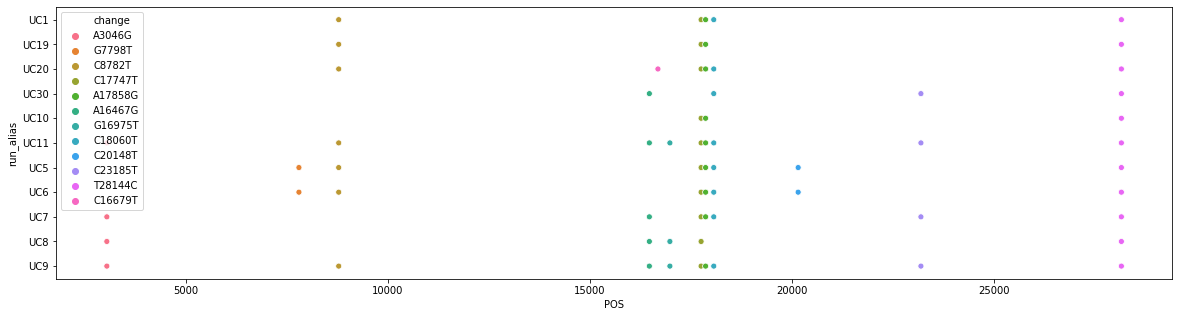

In [109]:
plt.figure(figsize=(20,5))
sns.scatterplot(x='POS',y='run_alias',data=pysqldf('select * from va where ( loc="gpA" or loc="gpB" ) and AF >=0.90 order by loc desc'),hue='change')

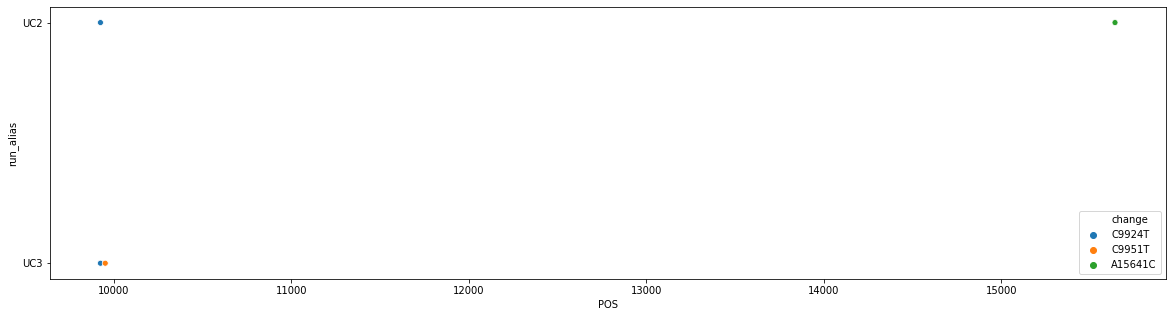

In [118]:
plt.figure(figsize=(20,5))
sns.scatterplot(x='POS',y='run_alias',data=pysqldf('select * from va where ( loc="Solano" ) and AF >=0.90 order by loc desc'),hue='change')

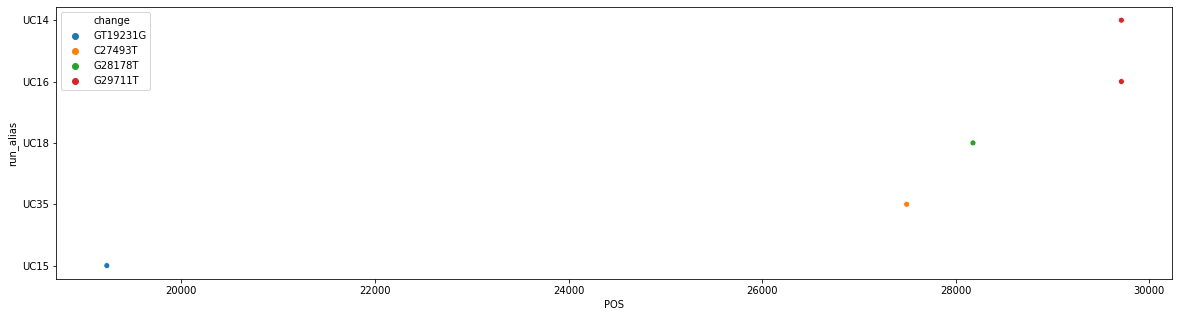

In [116]:
plt.figure(figsize=(20,5))
sns.scatterplot(x='POS',y='run_alias',data=pysqldf('select * from va where ( loc="SantaClara" ) and AF > 0.9 order by loc desc'),hue='change')

In [120]:
pysqldf('select * from va where POS = 29711')

Sample    POS REF ALT     QUAL   DP        AF  SB         DP4 IMPACT  \
0  SRR11859163  29711   G   T   2147.0   57  1.000000   0   0,0,34,23      .   
1  SRR11859165  29711   G   T   4094.0  105  0.990476   0   0,0,69,36      .   
2  SRR11859145  29711   G   T  17056.0  567  0.892416   0  0,56,0,507      .   

  FUNCLASS EFFECT GENE CODON   change study_accession library_strategy  \
0        .      .    .     .  G29711T       SRP265005         AMPLICON   
1        .      .    .     .  G29711T       SRP265005         AMPLICON   
2        .      .    .     .  G29711T       SRP265005         AMPLICON   

  library_source library_selection run_alias   type func  start    end   A  \
0    METAGENOMIC               PCR      UC16  3'UTR    .  29674  29903  93   
1    METAGENOMIC               PCR      UC14  3'UTR    .  29674  29903  93   
2    METAGENOMIC               PCR      UC34  3'UTR    .  29674  29903  93   

    C   G   T         loc  
0  36  47  53  SantaClara  
1  36  47  53  SantaClara  
2  36  47  53  SantaClara

In [73]:
pysqldf('select * from va where ( loc="gpA" or loc="gpB" ) and AF >=0.90')

Sample    POS REF ALT     QUAL      DP        AF   SB  \
0   SRR11859129   3046   A   G  49314.0  102993  0.959735   13   
1   SRR11859130   3046   A   G  49314.0    5058  0.952550    2   
2   SRR11859131   3046   A   G  12854.0     390  0.943590    0   
3   SRR11859132   7798   G   T   3311.0     102  0.941176    0   
4   SRR11859136   7798   G   T   5510.0     156  0.987179    0   
5   SRR11859168   3046   A   G  49314.0    5571  0.959074    0   
6   SRR11859129   8782   C   T  49314.0   28040  0.950927  249   
7   SRR11859132   8782   C   T   3392.0     114  0.938596    0   
8   SRR11859136   8782   C   T   2776.0      90  0.911111    0   
9   SRR11859159   8782   C   T   1486.0      39  1.000000    0   
10  SRR11859160   8782   C   T    577.0      17  0.941176    0   
11  SRR11859168   8782   C   T  49314.0    2185  0.943707   20   
12  SRR11859170   8782   C   T  28426.0     938  0.924307    0   
13  SRR11859128  17747   C   T   2309.0      66  0.984848    0   
14  SRR11859128  17858   A   G   1036.0      32  0.937500    0   
15  SRR11859129  16467   A   G  49314.0   34932  0.957718    0   
16  SRR11859129  16975   G   T  49314.0   31957  0.969021    0   
17  SRR11859129  17747   C   T  49314.0   21480  0.982635    0   
18  SRR11859129  17858   A   G  49314.0   17974  0.960332    0   
19  SRR11859130  16467   A   G  45112.0    1348  0.971068    3   
20  SRR11859130  16975   G   T  18685.0     544  0.979779    0   
21  SRR11859130  17747   C   T  17860.0     512  0.982422    0   
22  SRR11859131  16467   A   G   4599.0     136  0.977941    0   
23  SRR11859131  17747   C   T   5499.0     157  0.987261    0   
24  SRR11859131  17858   A   G   3537.0     110  0.954545    0   
25  SRR11859132  17747   C   T   2030.0      57  1.000000    0   
26  SRR11859132  17858   A   G   1781.0      56  0.928571    0   
27  SRR11859136  17747   C   T   1848.0      55  0.963636    0   
28  SRR11859136  17858   A   G   3624.0     111  0.936937    0   
29  SRR11859159  16679   C   T   1641.0      44  0.977273    0   
30  SRR11859159  17747   C   T   2822.0      76  0.973684    0   
31  SRR11859159  17858   A   G   1545.0      41  1.000000    0   
32  SRR11859160  17747   C   T    923.0      25  0.960000    0   
33  SRR11859160  17858   A   G    536.0      14  1.000000    0   
34  SRR11859168  16467   A   G  49314.0    3416  0.945550    0   
35  SRR11859168  16975   G   T  49314.0    3731  0.971321    0   
36  SRR11859168  17747   C   T  49314.0    2729  0.984610    0   
37  SRR11859168  17858   A   G  49314.0    2604  0.959677    3   
38  SRR11859149  16467   A   G  49314.0    8622  0.987822    0   
39  SRR11859170  17747   C   T  33867.0     958  0.990605    0   
40  SRR11859170  17858   A   G  32658.0     984  0.968496    0   
41  SRR11859129  18060   C   T  49314.0   17180  0.970664    0   
42  SRR11859131  18060   C   T   3282.0     101  0.950495    0   
43  SRR11859132  18060   C   T   1962.0      56  0.982143    0   
44  SRR11859136  18060   C   T   2624.0      77  0.961039    0   
45  SRR11859159  18060   C   T   2406.0      62  1.000000    0   
46  SRR11859168  18060   C   T  49314.0    3399  0.974110   10   
47  SRR11859149  18060   C   T  49314.0   21158  0.976368    0   
48  SRR11859170  18060   C   T  35034.0    1020  0.972549    0   
49  SRR11859132  20148   C   T   1051.0      32  0.937500    0   
50  SRR11859136  20148   C   T    987.0      30  0.933333    0   
51  SRR11859129  23185   C   T  49314.0   13515  0.915131    0   
52  SRR11859131  23185   C   T   2323.0      72  0.958333    0   
53  SRR11859168  23185   C   T  49314.0    2123  0.902968   33   
54  SRR11859149  23185   C   T  49314.0  102885  0.988171    0   
55  SRR11859128  28144   T   C   2193.0      63  0.984127    0   
56  SRR11859129  28144   T   C  49314.0  113371  0.945109   68   
57  SRR11859130  28144   T   C  49314.0    1692  0.926714    0   
58  SRR11859131  28144   T   C  12726.0     386  0.935233    0   
59  SRR11859132  28144   T   C  14583.0     438  

## Basic descriptive statistics of SARS-CoV2 variants

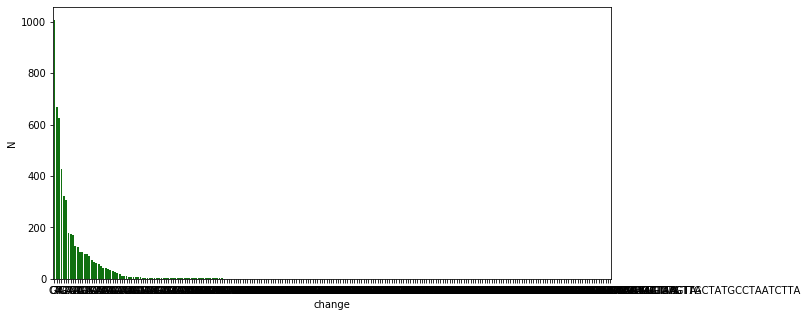

In [37]:
plt.figure(figsize=(10,5))
sns.barplot(x='change',data = pysqldf('select change,count(distinct POS) as N from va group by change order by N desc'),y='N',color='g')

In [38]:
# Total number of variants across all samples
summary = []
summary.append(['Total sites',pysqldf('select count(*) from va').to_numpy()[0][0]])
# Number of distinct positions with variants
summary.append(['Distinct positions',pysqldf('select count(distinct POS) from va').to_numpy()[0][0]])
# Number of samples containing variants
summary.append(['Distinct samples',pysqldf('select count(distinct Sample) from va').to_numpy()[0][0]])
# Number of fixed sites
summary.append(['Distinct studies',pysqldf('select count(distinct study_accession) from va').to_numpy()[0][0]])
# Number of geographic locations
summary.append(['Distinct geographic locations',pysqldf('select count(distinct geo_loc_name) from va').to_numpy()[0][0]])

In [39]:
summary

[['Total sites', 13138],
 ['Distinct positions', 5006],
 ['Distinct samples', 1306],
 ['Distinct studies', 32],
 ['Distinct geographic locations', 25]]

In [40]:
print(va['geo_loc_name'].unique())

['USA:Virginia' None 'USA: Virginia' 'USA' 'USA:Minnesota'
 'Australia: NSW' 'USA: Hamilton, MT' 'USA: Washington' 'USA: New York'
 'USA: WA' 'Turkey' 'Israel' 'Bangladesh' 'Peru: Lima'
 'Germany: Starnberg' 'Germany' 'USA: Seattle, WA' 'China:Shanghai'
 'China: Wuhan' 'China: Hubei' 'Germany: Dusseldorf' 'Malaysia' 'USA:WA'
 'Canada' 'USA:Los Angeles' 'Egypt']


In [41]:
from IPython.display import HTML, display
import tabulate
print(tabulate.tabulate(summary, tablefmt='md',headers=['Sites','Counts']))

Sites                            Counts
-----------------------------  --------
Total sites                       13138
Distinct positions                 5006
Distinct samples                   1306
Distinct studies                     32
Distinct geographic locations        25


In [42]:
distinct_sites = pysqldf('select POS, change, FUNCLASS, func, end-start as len, min(AF) as minAF, max(AF) as maxAF from va group by POS, change')

In [43]:
pysqldf('select count(*) from distinct_sites')

count(*)
0      5531

In [44]:
summary=pd.DataFrame()
summary = pysqldf('select FUNCLASS, count(*) as N, "fixed" as type from distinct_sites where minAF >= 0.95 group by FUNCLASS')
summary = summary.append(pysqldf('select FUNCLASS, count(*) as N, "polymorphic" as type from distinct_sites where maxAF < 0.95 group by FUNCLASS'),ignore_index=True)
summary = summary.append(pysqldf('select FUNCLASS, count(*) as N, "mixed" as type from distinct_sites where maxAF >= 0.95 and minAF < 0.95 group by FUNCLASS'),ignore_index=True)

In [45]:
print(summary.to_markdown())

|    | FUNCLASS   |    N | type        |
|---:|:-----------|-----:|:------------|
|  0 | .          |   10 | fixed       |
|  1 | MISSENSE   |  242 | fixed       |
|  2 | NONE       |   53 | fixed       |
|  3 | NONSENSE   |    1 | fixed       |
|  4 | SILENT     |  153 | fixed       |
|  5 | .          |   80 | polymorphic |
|  6 | MISSENSE   | 2508 | polymorphic |
|  7 | NONE       | 1267 | polymorphic |
|  8 | NONSENSE   |  164 | polymorphic |
|  9 | SILENT     |  878 | polymorphic |
| 10 | .          |    4 | mixed       |
| 11 | MISSENSE   |   92 | mixed       |
| 12 | NONE       |   21 | mixed       |
| 13 | SILENT     |   58 | mixed       |


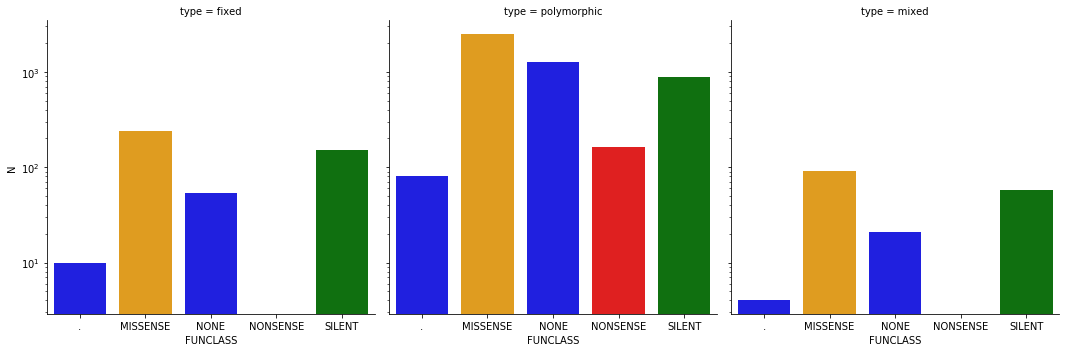

In [48]:
sns.catplot(x='FUNCLASS',col='type',y='N',data=summary,kind='bar',palette=fc_palette)
plt.yscale('log')

In [49]:
t = pysqldf('select func,FUNCLASS, count(*) as N,len from distinct_sites group by func,FUNCLASS')
t['rlen']=t['N']/t['len']
t

func  FUNCLASS    N   len      rlen
0           .         .   90   265  0.339623
1       3Cpro  MISSENSE  101   918  0.110022
2       3Cpro      NONE   48   918  0.052288
3       3Cpro  NONSENSE    3   918  0.003268
4       3Cpro    SILENT   39   918  0.042484
5           E  MISSENSE   18   228  0.078947
6           E      NONE    7   228  0.030702
7           E    SILENT    5   228  0.021930
8        ExoN  MISSENSE  130  1581  0.082226
9        ExoN      NONE   57  1581  0.036053
10       ExoN  NONSENSE   13  1581  0.008223
11       ExoN    SILENT   51  1581  0.032258
12          M  MISSENSE   61   669  0.091181
13          M      NONE   32   669  0.047833
14          M  NONSENSE    5   669  0.007474
15          M    SILENT   26   669  0.038864
16     MethTr  MISSENSE   60   894  0.067114
17     MethTr      NONE   26   894  0.029083
18     MethTr  NONSENSE    2   894  0.002237
19     MethTr    SILENT   28   894  0.031320
20          N  MISSENSE  137  1260  0.108730
21          N      NONE   58  1260  0.046032
22          N  NONSENSE    8  1260  0.006349
23          N    SILENT   59  1260  0.046825
24       RdRp  MISSENSE  231  2795  0.082648
25       RdRp      NONE  119  2795  0.042576
26       RdRp  NONSENSE    8  2795  0.002862
27       RdRp    SILENT  111  2795  0.039714
28          S         .    2  3822  0.000523
29          S  MISSENSE  316  3822  0.082679
30          S      NONE  143  3822  0.037415
31          S  NONSENSE   20  3822  0.005233
32          S    SILENT  115  3822  0.030089
33      endoR  MISSENSE   96  1038  0.092486
34      endoR      NONE   35  1038  0.033719
35      endoR  NONSENSE    4  1038  0.003854
36      endoR    SILENT   23  1038  0.022158
37   helicase  MISSENSE  220  1803  0.122019
38   helicase      NONE   74  1803  0.041043
39   helicase  NONSENSE    8  1803  0.004437
40   helicase    SILENT   69  1803  0.038270
41     leader  MISSENSE   72   540  0.133333
42     leader      NONE   59   540  0.109259
43     leader  NONSENSE    9   540  0.016667
44     leader    SILENT   40   540  0.074074
45      nsp10  MISSENSE   43   417  0.103118
46      nsp10      NONE   18   417  0.043165
47      nsp10  NONSENSE    1   417  0.002398
48      nsp10    SILENT   16   417  0.038369
49       nsp2  MISSENSE  256  1914  0.133751
50       nsp2      NONE   93  1914  0.048589
51       nsp2  NONSENSE   16  1914  0.008359
52       nsp2    SILENT   84  1914  0.043887
53       nsp3  MISSENSE  553  5835  0.094773
54       nsp3      NONE  287  5835  0.049186
55       nsp3  NONSENSE   38  5835  0.006512
56       nsp3    SILENT  210  5835  0.035990
57       nsp4  MISSENSE  137  1500  0.091333
58       nsp4      NONE   69  1500  0.046000
59       nsp4  NONSENSE    9  1500  0.006000
60       nsp4    SILENT   47  1500  0.031333
61       nsp6  MISSENSE   94   870  0.108046
62       nsp6      NONE   64   870  0.073563
63       nsp6  NONSENSE    4   870  0.004598
64       nsp6    SILENT   36   870  0.041379
65       nsp7  MISSENSE   28   249  0.112450
66       nsp7      NONE   12   249  0.048193
67       nsp7    SILENT   14   249  0.056225
68       nsp8  MISSENSE   73   594  0.122896
69       nsp8      NONE   33   594  0.055556
70       nsp8  NONSENSE    2   594  0.003367
71       nsp8    SILENT   26   594  0.043771
72       nsp9  MISSENSE   31   339  0.091445
73       nsp9      NONE   12   339  0.035398
74       nsp9  NONSENSE    3   339  0.008850
75       nsp9    SILENT   17   339  0.050147
76      orf10  MISSENSE    5   117  0.042735
77      orf10      NONE    4   117  0.034188
78      orf10  NONSENSE    1   117  0.008547
79      orf10    SILENT    5   117  0.042735
80      orf3a  MISSENSE   88   828  0.106280
81      orf3a      NONE   40   828  0.048309
82      orf3a  NONSENSE    5   828  0.006039
83      orf3a    SILENT   28   828  0.033816
84       orf6  MISSENSE   18   186  0.096774
85       orf6      NONE   17   186  0.091398
86       orf6  NONSENSE    1   186  0.005376
87       orf6    SILENT    9   186  0.048387
88  

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

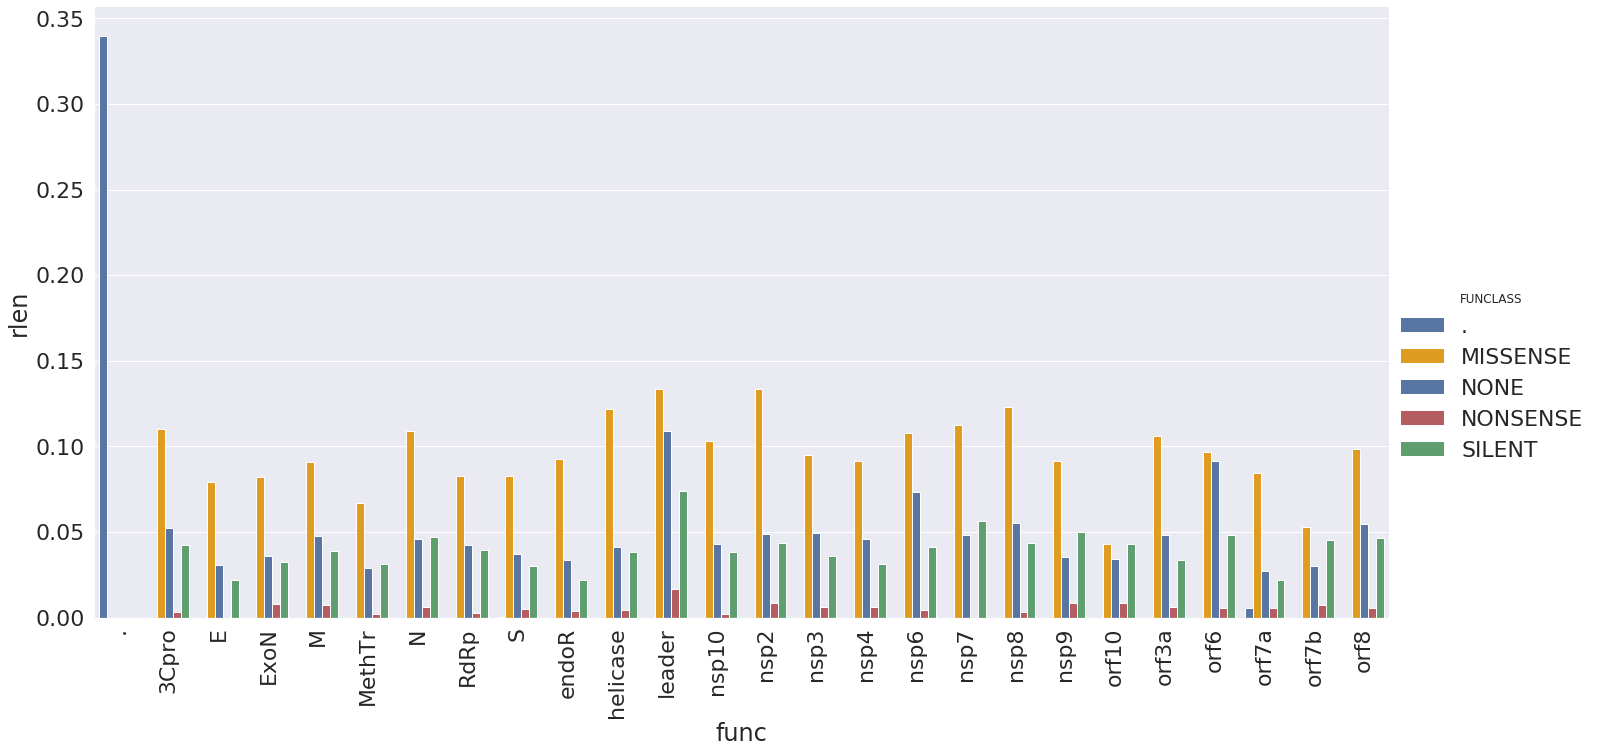

In [50]:
sns.set(font_scale=2)
sns.catplot(x='func',y='rlen',hue='FUNCLASS',data=t.sort_values(by='func'),height=10,kind='bar',aspect=2,palette=fc_palette)
plt.xticks(rotation=90)

## What's up with stops?

In [51]:
print(pysqldf('select study_accession, library_strategy, count(*) as Stops, count(distinct Sample) as Samples from va where FUNCLASS = "NONSENSE" group by study_accession order by stops desc').to_markdown())

|    | study_accession   | library_strategy   |   Stops |   Samples |
|---:|:------------------|:-------------------|--------:|----------:|
|  0 | SRP251618         | RNA-Seq            |     124 |        91 |
|  1 | SRP253926         | AMPLICON           |      72 |        41 |
|  2 | SRP261417         | Targeted-Capture   |      21 |        16 |
|  3 | SRP265005         | AMPLICON           |      19 |        14 |
|  4 | ERP121228         | AMPLICON           |      16 |         8 |
|  5 | SRP262661         | AMPLICON           |      15 |         5 |
|  6 | SRP248092         | RNA-Seq            |      11 |         3 |
|  7 | SRP261139         | Targeted-Capture   |       5 |         2 |
|  8 | SRP262648         | RNA-Seq            |       3 |         1 |
|  9 | SRP256957         | AMPLICON           |       3 |         3 |
| 10 | SRP261949         | OTHER              |       2 |         1 |
| 11 | SRP262536         | RNA-Seq            |       1 |         1 |
| 12 | SRP258105    

<Figure size 2160x720 with 0 Axes>

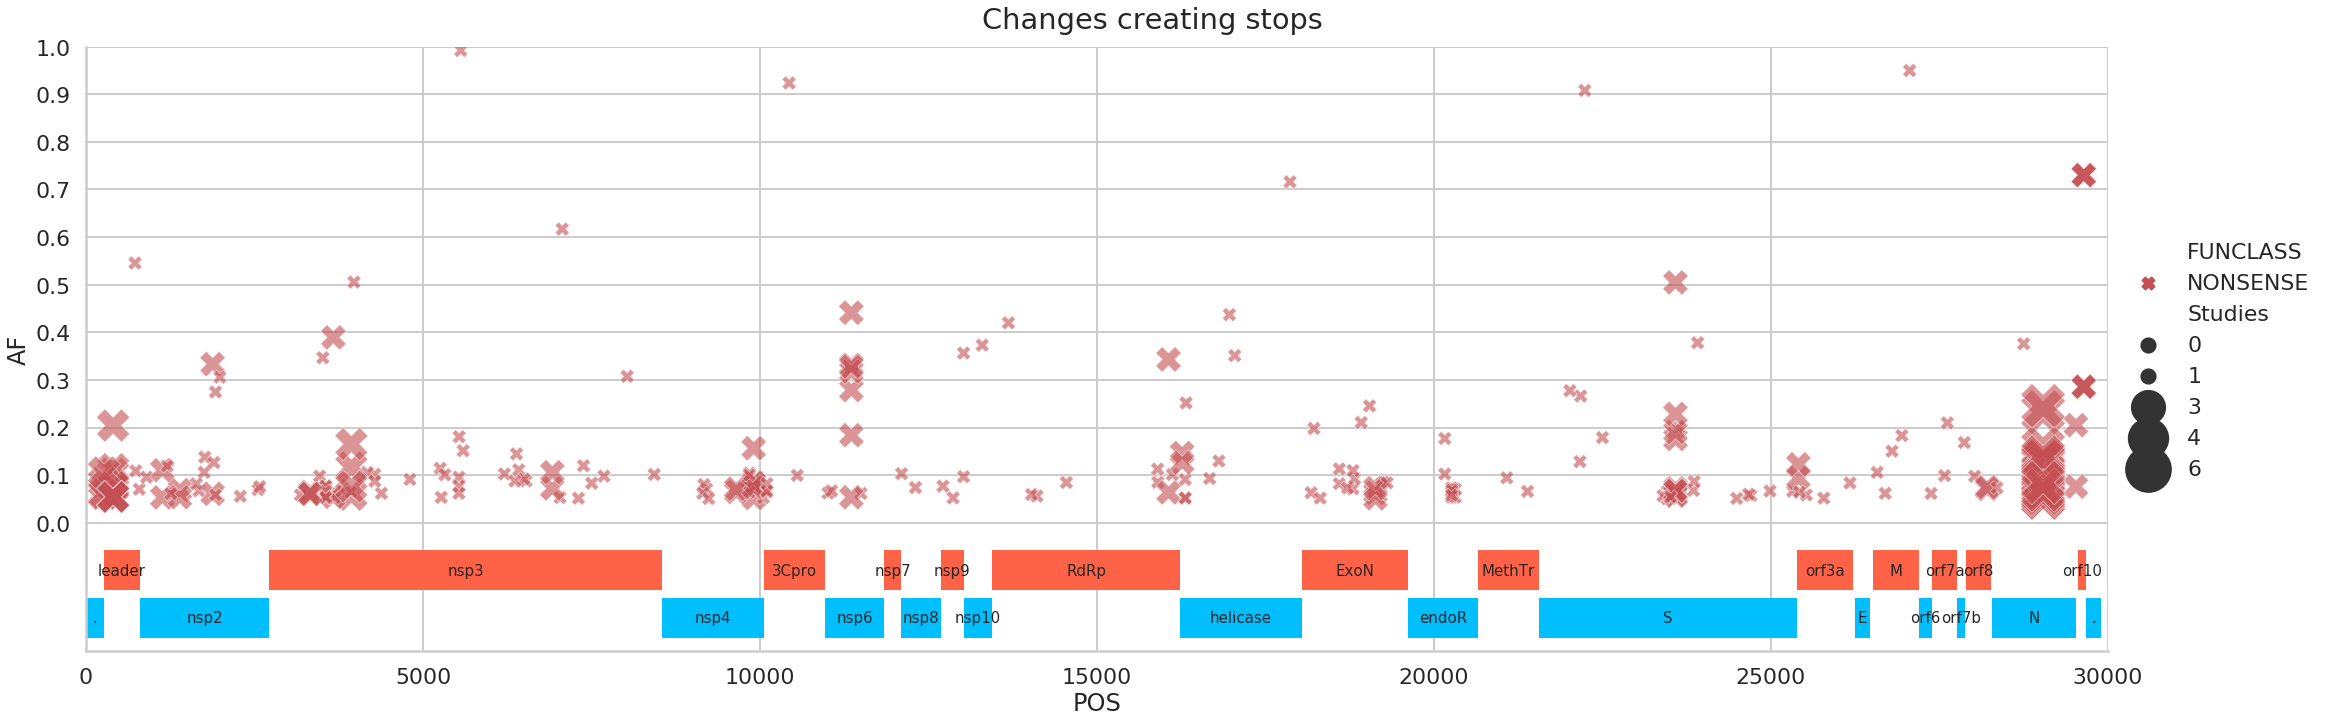

In [52]:
minimap(va[va['FUNCLASS']=='NONSENSE'],'POS','AF',annot[annot['L']>100],'Studies','FUNCLASS','FUNCLASS', 'Changes creating stops')

In [53]:
print(pysqldf('select POS, change, Samples, Studies, Strategies, GENE, func from va where FUNCLASS="NONSENSE" group by POS, change order by Studies desc').head(15).to_markdown())

|    |   POS | change   |   Samples |   Studies |   Strategies | GENE   | func     |
|---:|------:|:---------|----------:|----------:|-------------:|:-------|:---------|
|  0 | 29039 | AT       |        48 |         5 |            3 | N      | N        |
|  1 |   269 | GT       |         4 |         3 |            2 | orf1ab | leader   |
|  2 |   404 | AT       |        10 |         3 |            3 | orf1ab | leader   |
|  3 |  3938 | AT       |         4 |         3 |            2 | orf1ab | nsp3     |
|  4 |  1133 | AT       |         2 |         2 |            2 | orf1ab | nsp2     |
|  5 |  1394 | GT       |         2 |         2 |            2 | orf1ab | nsp2     |
|  6 |  1880 | GT       |         2 |         2 |            1 | orf1ab | nsp2     |
|  7 |  3326 | CT       |         3 |         2 |            2 | orf1ab | nsp3     |
|  8 |  3671 | GT       |         2 |         2 |            2 | orf1ab | nsp3     |
|  9 |  6920 | AT       |         2 |         2 |            2 | 

In [54]:
print(pysqldf('select Sample, DP, AF, SB, DP4, GENE, CODON, study_accession, library_strategy, library_source, library_selection from va where POS = 29039 and change = "AT"').to_markdown())

|    | Sample      |   DP |       AF |   SB | DP4            | GENE   | CODON   | study_accession   | library_strategy   | library_source     | library_selection   |
|---:|:------------|-----:|---------:|-----:|:---------------|:-------|:--------|:------------------|:-------------------|:-------------------|:--------------------|
|  0 | SRR11059942 |  327 | 0.232416 |    4 | 129,122,34,42  | N      | Aag/Tag | SRP248092         | RNA-Seq            | METATRANSCRIPTOMIC | RT-PCR              |
|  1 | SRR11813140 | 1167 | 0.054841 |   17 | 669,433,49,16  | N      | Aag/Tag | SRP253926         | AMPLICON           | VIRAL RNA          | PCR                 |
|  2 | SRR11780050 |  129 | 0.093023 |   20 | 53,63,11,2     | N      | Aag/Tag | SRP251618         | RNA-Seq            | VIRAL RNA          | unspecified         |
|  3 | SRR11772061 |  151 | 0.086093 |   10 | 59,79,9,4      | N      | Aag/Tag | SRP251618         | RNA-Seq            | VIRAL RNA          | unspecified         |
|  4

In [55]:
pysqldf('select * from va where study_accession="SRP251618" and Samples>14 and Studies=1')

Sample    POS REF ALT    DP        AF    SB               DP4  \
0    SRR11772043    354   G   C   123  0.073171    20         53,61,0,9   
1    SRR11621835    354   G   C   133  0.060150    11         59,66,1,7   
2    SRR11621861    354   G   C   121  0.115702    12        53,53,3,11   
3    SRR11772044    354   G   C   147  0.061224    18        51,86,0,10   
4    SRR11621857    354   G   C   153  0.150327    35        56,74,1,22   
5    SRR11621859    354   G   C   135  0.074074     4         58,66,3,8   
6    SRR11779999    354   G   C   264  0.162879     4      95,124,15,28   
7    SRR11772018    354   G   C   203  0.113300     8        83,96,7,17   
8    SRR11772047    354   G   C   108  0.055556    15         51,51,0,6   
9    SRR11621828    354   G   C   297  0.087542    21      137,134,6,20   
10   SRR11772012    354   G   C   173  0.080925    36        72,85,0,15   
11   SRR11780016    354   G   C   324  0.172840    40      101,164,7,51   
12   SRR11621846    354   G   C   235  0.165957    47       106,89,7,33   
13   SRR11772016    354   G   C   208  0.120192    41        88,94,2,23   
14   SRR11621816    354   G   C   185  0.086486    38        72,96,0,17   
15   SRR11780024    354   G   C   267  0.074906    14       87,156,3,20   
16   SRR11621840    354   G   C   153  0.058824     7         70,74,2,7   
17   SRR11779968    354   G   C   194  0.113402     9        74,95,6,18   
18   SRR11779941    354   G   C   249  0.080321     1      104,124,8,13   
19   SRR11621832    354   G   C   130  0.076923     2         65,55,4,6   
20   SRR11780049   5609   G  GT   120  0.058333    18         54,59,7,0   
21   SRR11621827   5609   G  GT   116  0.060345     0         49,61,3,4   
22   SRR11621854   5609   G  GT   187  0.122995    63        86,88,23,0   
23   SRR11772043   5609   G  GT   150  0.066667    26        72,68,10,0   
24   SRR11780051   5609   G  GT   146  0.561644   131        31,33,81,1   
25   SRR11621835   5609   G  GT   141  0.127660    47        63,61,18,0   
26   SRR11772038   5609   G  GT   141  0.056738    11         68,66,7,1   
27   SRR11621834   5609   G  GT    98  0.112245     1         48,42,7,4   
28   SRR11621861   5609   G  GT   212  0.344340    86        73,66,67,6   
29   SRR11621880   5609   G  GT   296  0.087838    65      125,148,25,1   
30   SRR11621928   5609   G  GT   171  0.146199    65        75,73,25,0   
31   SRR11621862   5609   G  GT   101  0.297030    31        36,35,26,4   
32   SRR11621833   5609   G  GT   204  0.147059    81       76,101,29,1   
33   SRR11772022   5609   G  GT   186  0.134409    38        89,81,23,2   
34   SRR11621821   5609   G  GT   129  0.077519    28        58,62,10,0   
35   SRR11621857   5609   G  GT   369  0.487805   260       99,93,175,5   
36   SRR11780038   5609   G  GT   446  0.504484   391     101,121,220,5   
37   SRR11779945   5609   G  GT   161  0.062112    10         74,77,8,2   
38   SRR11621894   5609   G  GT   197  0.050761     6        92,100,7,3   
39   SRR11621930   5609   G  GT   138  0.108696    21        61,62,13,2   
40   SRR11780052   5609   G  GT  1067  0.640112  1149     156,227,676,7   
41   SRR11621872   5609   G  GT   604  0.125828   106     212,340,60,16   
42   SRR11779998   5609   G  GT   190  0.152632    36        84,83,25,4   
43   SRR11621926   5609   G  GT   156  0.051282    21         74,75,8,0   
44   SRR11621845   5609   G  GT   108  0.148148    22        45,48,14,2   
45   SRR11621807   5609   G  GT   109  0.073394    17         56,46,8,0   
46   SRR11779999   5609   G  GT   199  0.125628    42        89,86,23,2   
47   SRR11772013   5609   G  GT   150  0.060000    24         72,70,9,0   
48   SRR11779970   5609   G  GT   145  0.089655    14        69,64,11,2   
49   SRR11779946   5609   G  GT   154  0.103896     0         74,67,8,8   
50   SRR11780032   5609   G  GT   184  0.157609    74        79,78,29,0   
51   SRR11621848   5609   G  GT   127  0.078740    26        60,57,10,0   
52   SRR11780042   5609   G  GT   1

Text(0.5, 1.02, 'Alternatiove allele frequencies at sites shared among >= 5 Samples within study SRP251618')

<Figure size 2160x1080 with 0 Axes>

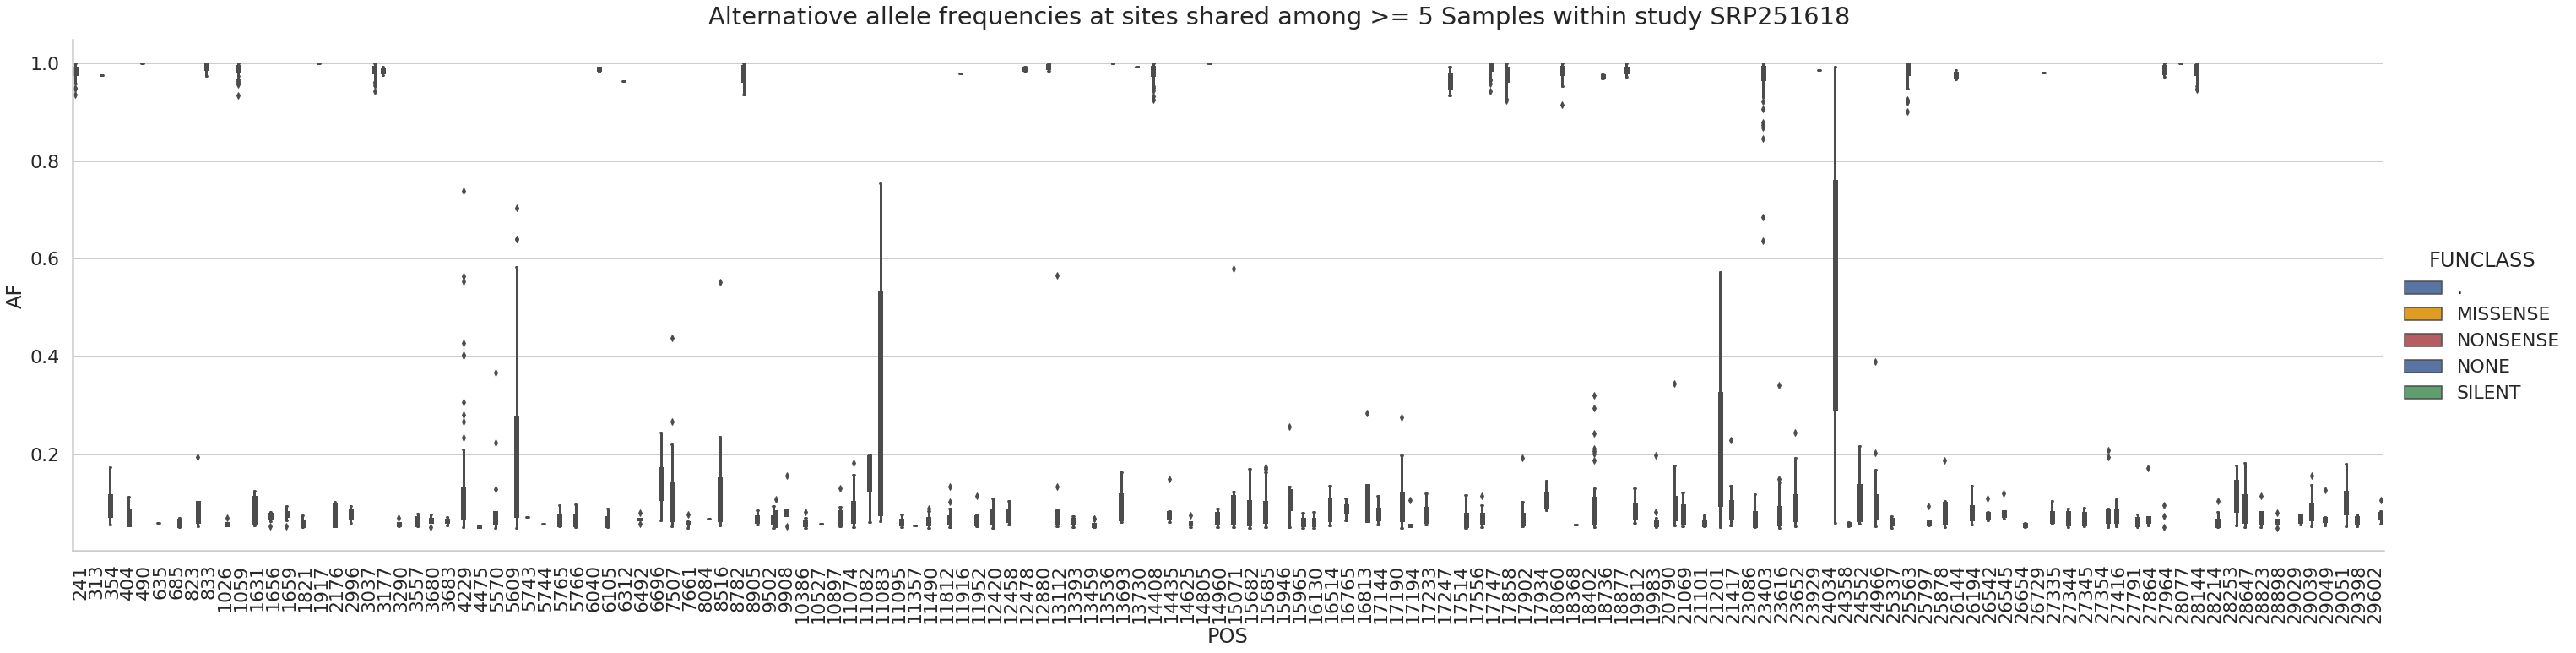

In [56]:
plt.figure(figsize=(30,15))
sns.catplot(x='POS',y='AF',data=pysqldf('select * from va where study_accession="SRP251618" and Samples>5'),height=10,aspect=4,kind='box',hue='FUNCLASS',palette=fc_palette)
plt.xticks(rotation=90)
plt.suptitle('Alternatiove allele frequencies at sites shared among >= 5 Samples within study SRP251618',y=1.02)

In [57]:
va.head()

Sample  POS REF ALT    DP        AF  SB           DP4 IMPACT FUNCLASS  \
0  SRR11772222  241   C   T  1205  0.991701   0   0,0,589,614      .        .   
1  SRR11607614  241   C   T  1433  0.985345   0   0,0,613,816      .        .   
2  SRR11858001  241   C   T   966  0.998965   0   0,1,459,506      .        .   
3  SRR11607659   61   G   T   716  0.054469   0  554,122,34,6      .        .   
4  SRR11607659   79   A   T   914  0.062363   6  690,167,50,7      .        .   

  EFFECT GENE CODON change study_accession library_strategy library_source  \
0      .    .     .     CT       SRP256957         AMPLICON      VIRAL RNA   
1      .    .     .     CT       SRP253926         AMPLICON      VIRAL RNA   
2      .    .     .     CT       SRP256957         AMPLICON      VIRAL RNA   
3      .    .     .     GT       SRP253926         AMPLICON      VIRAL RNA   
4      .    .     .     AT       SRP253926         AMPLICON      VIRAL RNA   

  library_selection collection_date   geo_loc_name   type func  start  end  \
0              cDNA         2020-04   USA:Virginia  5'UTR    .      0  265   
1               PCR            None           None  5'UTR    .      0  265   
2              cDNA         2020-04  USA: Virginia  5'UTR    .      0  265   
3               PCR            None           None  5'UTR    .      0  265   
4               PCR            None           None  5'UTR    .      0  265   

    A   C   G   T  Samples  Studies  Strategies  
0  67  63  55  80      608       16           6  
1  67  63  55  80      608       16           6  
2  67  63  55  80      608       16           6  
3  67  63  55  80        3        3           1  
4  67  63  55  80        1        1           1

Text(0.5, 1.02, 'Changes leading to stop versus number of STUDIES that are shared across')

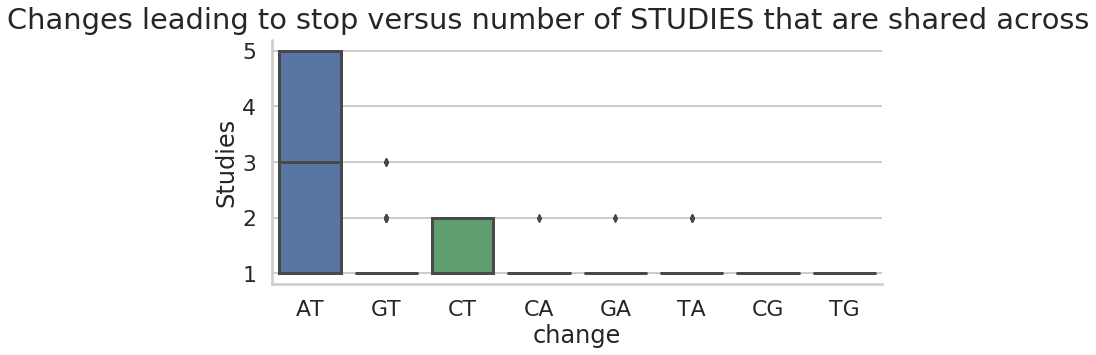

In [58]:
sns.catplot(x='change',y="Studies",kind='box',data=pysqldf('select POS, change, Samples, Studies, Strategies from va where FUNCLASS="NONSENSE"'),height=5,aspect=2)
plt.suptitle('Changes leading to stop versus number of STUDIES that are shared across',y=1.02)

Text(0.5, 1.02, 'Changes leading to stop versus number of SAMPLES that are shared across')

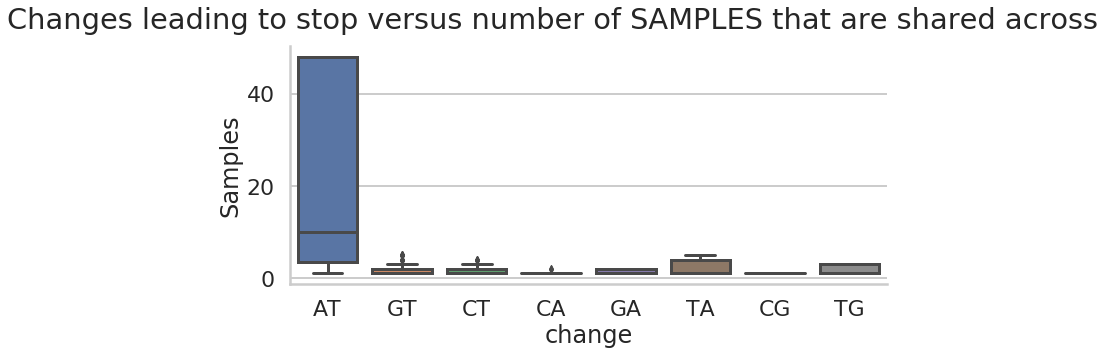

In [59]:
sns.catplot(x='change',y="Samples",kind='box',data=pysqldf('select POS, change, Samples, Studies, Strategies from va where FUNCLASS="NONSENSE"'),height=5,aspect=2)
plt.suptitle('Changes leading to stop versus number of SAMPLES that are shared across',y=1.02)

Text(0.5, 1.02, 'Changes leading to stop versus number of LIBRARY STRATEGIES that are shared across')

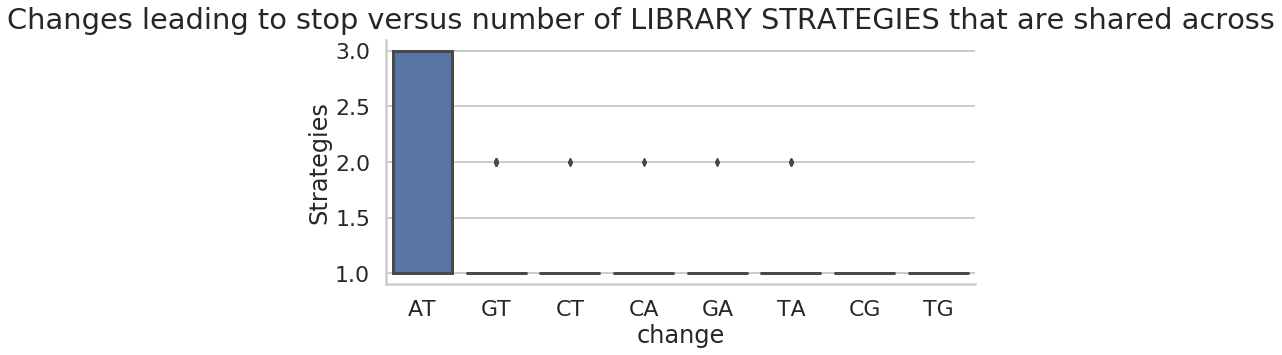

In [60]:
sns.catplot(x='change',y="Strategies",kind='box',data=pysqldf('select POS, change, Samples, Studies, Strategies from va where FUNCLASS="NONSENSE"'),height=5,aspect=2)
plt.suptitle('Changes leading to stop versus number of LIBRARY STRATEGIES that are shared across',y=1.02)

In [61]:
pysqldf('select POS, change, func, count(*) as N from va where FUNCLASS = "NONSENSE" group by POS,change order by N desc')

POS change      func   N
0    29039     AT         N  48
1      404     AT    leader  10
2     3557     AT      nsp3   9
3    11357     AT      nsp6   7
4     9908     AT      nsp4   6
5    29642     CT     orf10   6
6    20263     GT     endoR   5
7    23584     TA         S   5
8      269     GT    leader   4
9     3938     AT      nsp3   4
10    9843     TA      nsp4   4
11   23585     CT         S   4
12    3326     CT      nsp3   3
13    5534     CT      nsp3   3
14   10102     TA     3Cpro   3
15   16310     TG  helicase   3
16   19132     GT      ExoN   3
17    1133     AT      nsp2   2
18    1394     GT      nsp2   2
19    1880     GT      nsp2   2
20    1922     GT      nsp2   2
21    3671     GT      nsp3   2
22    3683     CT      nsp3   2
23    6920     AT      nsp3   2
24    9649     GA      nsp4   2
25   13022     CT      nsp9   2
26   16063     CT      RdRp   2
27   16265     CA  helicase   2
28   18596     GA      ExoN   2
29   18799     CT      ExoN   2
30   20161     AT     endoR   2
31   20317     GT     endoR   2
32   23461     GA         S   2
33   25408     AT     orf3a   2
34   28209     GT      orf8   2
35   28949     AT         N   2
36   29525     CT         N   2
37     329     CT    leader   1
38     359     GT    leader   1
39     374     GT    leader   1
40     428     GT    leader   1
41     728     GT    leader   1
42     740     GT    leader   1
43     791     GT    leader   1
44     900     CA      nsp2   1
45    1205     CT      nsp2   1
46    1258     GA      nsp2   1
47    1637     AT      nsp2   1
48    1676     GT      nsp2   1
49    1754     AT      nsp2   1
50    1763     AT      nsp2   1
51    1898     CT      nsp2   1
52    1988     CT      nsp2   1
53    2291     CT      nsp2   1
54    2555     CT      nsp2   1
55    2579     GT      nsp2   1
56    3182     GT      nsp3   1
57    3467     GT      nsp3   1
58    3515     CT      nsp3   1
59    3689     GT      nsp3   1
60    3932     GT      nsp3   1
61    3977     GT      nsp3   1
62    4175     AT      nsp3   1
63    4283     GT      nsp3   1
64    4286     GT      nsp3   1
65    4384     GA      nsp3   1
66    4807     GA      nsp3   1
67    5256     TA      nsp3   1
68    5272     GA      nsp3   1
69    5324     GT      nsp3   1
70    5537     CT      nsp3   1
71    5561     GT      nsp3   1
72    5597     CT      nsp3   1
73    6209     GT      nsp3   1
74    6365     CT      nsp3   1
75    6389     GT      nsp3   1
76    6422     GT      nsp3   1
77    6497     AT      nsp3   1
78    6530     GT      nsp3   1
79    7035     TA      nsp3   1
80    7067     GT      nsp3   1
81    7307     CT      nsp3   1
82    7382     CT      nsp3   1
83    7504     CA      nsp3   1
84    7686     CA      nsp3   1
85    8030     AT      nsp3   1
86    8432     GT      nsp3   1
87    9152     CT      nsp4   1
88    9169     CA      nsp4   1
89    9209     GT      nsp4   1
90    9240     CA      nsp4   1
91    9808     CA      nsp4   1
92   10052     CT      nsp4   1
93   10433     CT     3Cpro   1
94   10554     TA     3Cpro   1
95   11011     GA      nsp6   1
96   11064     GA      nsp6   1
97   11499     CG      nsp6   1
98   12102     CA      nsp8   1
99   12308     CT      nsp8   1
100  12716     CT      nsp9   1
101  12866     GT      nsp9   1
102  13299     TA     nsp10   1
103  13687     GT      RdRp   1
104  14029     CT      RdRp   1
105  14110     CT      RdRp   1
106  14548     GT      RdRp   1
107  15901     AT      RdRp   1
108  15904     CT      RdRp   1
109  16120     GT      RdRp   1
110  16323     CA  helicase   1
111  16672     AT  helicase   1
112  16810     AT  helicase   1
113  16966     GT  helicase   1
114  17044     CT  helicase   1
115  17865     TA  helicase   1
116  18178     AT      ExoN   1
117  18220     AT      ExoN   1
118  18313     GT      ExoN   1
119  18720     GA      ExoN   1
120  18823     CT      ExoN   1
121  18922     GT      ExoN   1
122  19045     AT      ExoN   1
123  19210     AT      ExoN   1
124  19

## Filtering scheme

In [62]:
pysqldf('select change,count(distinct POS) as N from va group by change order by N desc')['N'].sum()

5531

In [63]:
pysqldf('select change,count(distinct POS) as N from va where Studies > 1 group by change order by N desc')['N'].sum()

636

In [64]:
pysqldf('select change,count(distinct POS) as N from va where Studies > 1 and ( change = "CT" or change="GA" ) group by change order by N desc')['N'].sum()

211

In [65]:
pysqldf('select change,count(distinct POS) as N from va where Studies > 1 and ( change = "AG" or change="TC" ) group by change order by N desc')['N'].sum()

87

Text(0.5, 1.02, 'Distinct positions shared across 1 or more studies')

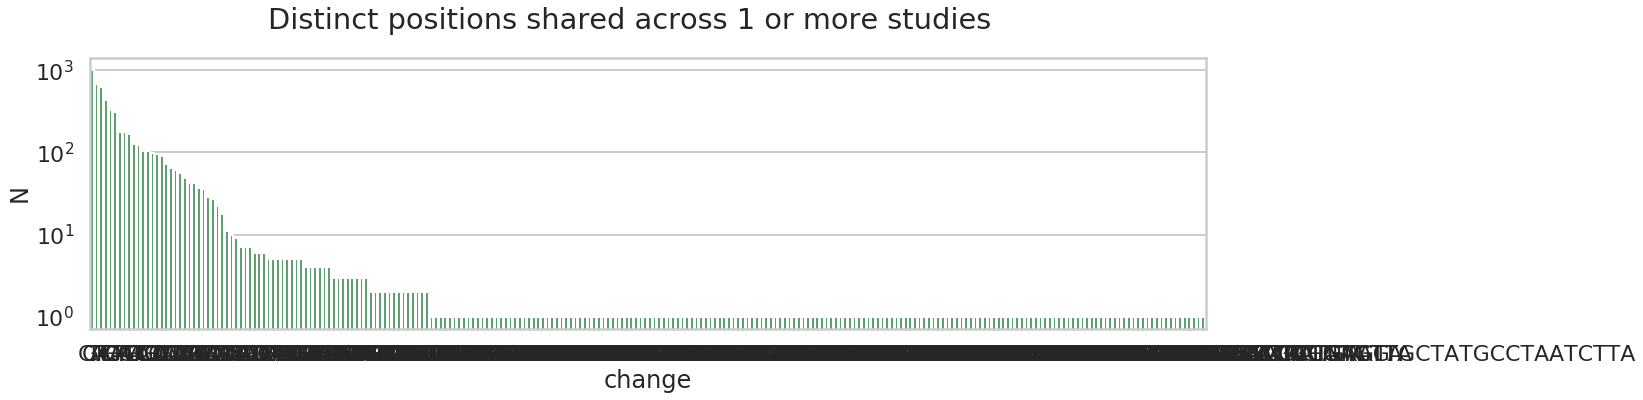

In [66]:
plt.figure(figsize=(20,5))
sns.barplot(x='change',data = pysqldf('select change,count(distinct POS) as N from va group by change order by N desc'),y='N',color='g')
plt.yscale('log')
plt.suptitle('Distinct positions shared across 1 or more studies',y=1.02)

Text(0.5, 1.02, 'Distinct positions shared across 2 or more studies')

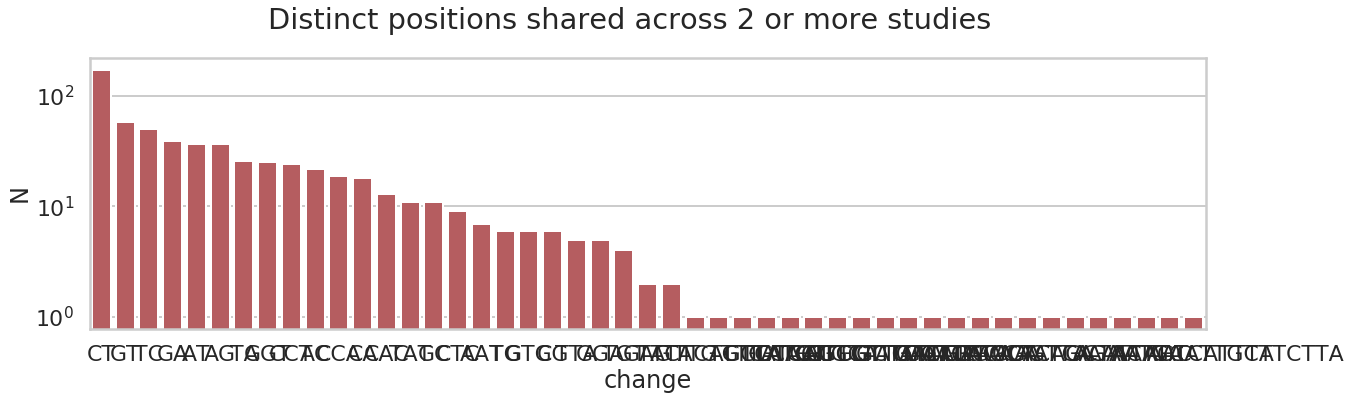

In [67]:
plt.figure(figsize=(20,5))
sns.barplot(x='change',data = pysqldf('select Studies,change,count(distinct POS) as N from va where Studies>1 group by change order by N desc'),y='N',color='r')
plt.yscale('log')
plt.suptitle('Distinct positions shared across 2 or more studies',y=1.02)

In [68]:
pysqldf('select count(distinct Sample) from va')

count(distinct Sample)
0                    1306

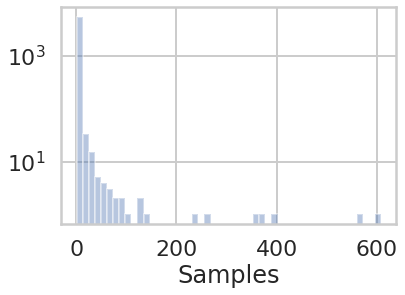

In [69]:
sns.distplot(samples_per_change['Samples'],kde=False)
plt.yscale('log')

In [70]:
pysqldf('select count(distinct study_accession) from va')

count(distinct study_accession)
0                               32

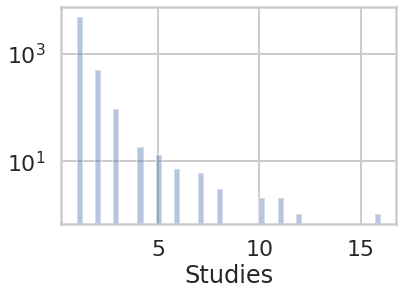

In [71]:
sns.distplot(studies_per_change['Studies'],kde=False)
plt.yscale('log')

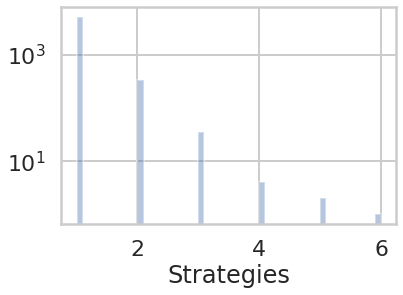

In [72]:
sns.distplot(strategies_per_change['Strategies'],kde=False)
plt.yscale('log')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]),
 <a list of 39 Text xticklabel objects>)

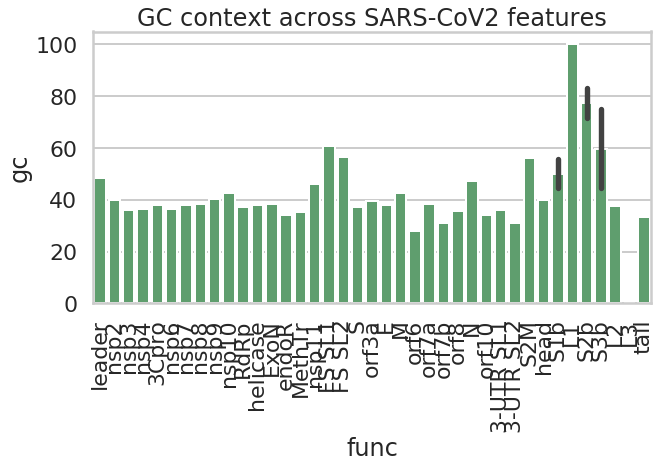

In [73]:
plt.figure(figsize=(10,5))
sns.barplot(x='func',y='gc',data=annot[annot['func']!='.'],color='g').set_title('GC context across SARS-CoV2 features')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

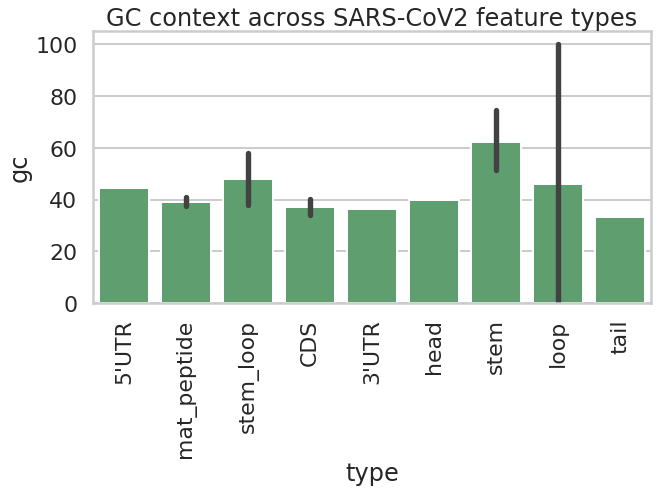

In [74]:
plt.figure(figsize=(10,5))
sns.barplot(x='type',y='gc',data=annot,color='g').set_title('GC context across SARS-CoV2 feature types')
plt.xticks(rotation=90)

In [75]:
va.head()

Sample  POS REF ALT    DP        AF  SB           DP4 IMPACT FUNCLASS  \
0  SRR11772222  241   C   T  1205  0.991701   0   0,0,589,614      .        .   
1  SRR11607614  241   C   T  1433  0.985345   0   0,0,613,816      .        .   
2  SRR11858001  241   C   T   966  0.998965   0   0,1,459,506      .        .   
3  SRR11607659   61   G   T   716  0.054469   0  554,122,34,6      .        .   
4  SRR11607659   79   A   T   914  0.062363   6  690,167,50,7      .        .   

  EFFECT GENE CODON change study_accession library_strategy library_source  \
0      .    .     .     CT       SRP256957         AMPLICON      VIRAL RNA   
1      .    .     .     CT       SRP253926         AMPLICON      VIRAL RNA   
2      .    .     .     CT       SRP256957         AMPLICON      VIRAL RNA   
3      .    .     .     GT       SRP253926         AMPLICON      VIRAL RNA   
4      .    .     .     AT       SRP253926         AMPLICON      VIRAL RNA   

  library_selection collection_date   geo_loc_name   type func  start  end  \
0              cDNA         2020-04   USA:Virginia  5'UTR    .      0  265   
1               PCR            None           None  5'UTR    .      0  265   
2              cDNA         2020-04  USA: Virginia  5'UTR    .      0  265   
3               PCR            None           None  5'UTR    .      0  265   
4               PCR            None           None  5'UTR    .      0  265   

    A   C   G   T  Samples  Studies  Strategies  
0  67  63  55  80      608       16           6  
1  67  63  55  80      608       16           6  
2  67  63  55  80      608       16           6  
3  67  63  55  80        3        3           1  
4  67  63  55  80        1        1           1

In [76]:
pysqldf('select type, count(*) from va group by type')

type  count(*)
0        3'UTR        42
1        5'UTR       695
2          CDS      3188
3         head         4
4         loop         4
5  mat_peptide      9122
6         stem        30
7    stem_loop        53

In [77]:
# Add sequence context for plus and minus
for index,row in va.iterrows():
    start_up = row['POS']-3
    end_up = row['POS']
    start_dn = row['POS']-1
    end_dn = row['POS']+2
    start_mid = row['POS']-2
    end_mid = row['POS']+1
    va.loc[index,'up'] = str(genome.seq[start_up:end_up])
    va.loc[index,'down'] = str(genome.seq[start_dn:end_dn])
    va.loc[index,'mid'] = str(genome.seq[start_mid:end_mid])
    va.loc[index,'left'] = str(genome.seq[start_mid:start_mid+1])
    va.loc[index,'right'] = str(genome.seq[start_dn+1:start_dn+2])

In [78]:
va.head()

Sample  POS REF ALT    DP        AF  SB           DP4 IMPACT FUNCLASS  \
0  SRR11772222  241   C   T  1205  0.991701   0   0,0,589,614      .        .   
1  SRR11607614  241   C   T  1433  0.985345   0   0,0,613,816      .        .   
2  SRR11858001  241   C   T   966  0.998965   0   0,1,459,506      .        .   
3  SRR11607659   61   G   T   716  0.054469   0  554,122,34,6      .        .   
4  SRR11607659   79   A   T   914  0.062363   6  690,167,50,7      .        .   

  EFFECT GENE CODON change study_accession library_strategy library_source  \
0      .    .     .     CT       SRP256957         AMPLICON      VIRAL RNA   
1      .    .     .     CT       SRP253926         AMPLICON      VIRAL RNA   
2      .    .     .     CT       SRP256957         AMPLICON      VIRAL RNA   
3      .    .     .     GT       SRP253926         AMPLICON      VIRAL RNA   
4      .    .     .     AT       SRP253926         AMPLICON      VIRAL RNA   

  library_selection collection_date   geo_loc_name   type func  start  end  \
0              cDNA         2020-04   USA:Virginia  5'UTR    .      0  265   
1               PCR            None           None  5'UTR    .      0  265   
2              cDNA         2020-04  USA: Virginia  5'UTR    .      0  265   
3               PCR            None           None  5'UTR    .      0  265   
4               PCR            None           None  5'UTR    .      0  265   

    A   C   G   T  Samples  Studies  Strategies   up down  mid left right  
0  67  63  55  80      608       16           6  TTC  CGT  TCG    T     G  
1  67  63  55  80      608       16           6  TTC  CGT  TCG    T     G  
2  67  63  55  80      608       16           6  TTC  CGT  TCG    T     G  
3  67  63  55  80        3        3           1  CTG  GTT  TGT    T     T  
4  67  63  55  80        1        1           1  TTA  AAA  TAA    T     A

In [79]:
va.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13138 entries, 0 to 13137
Columns: 36 entries, Sample to right
dtypes: float64(1), int64(12), object(23)
memory usage: 3.6+ MB


In [80]:
va = va[va['Studies']>1]

In [81]:
va.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7031 entries, 0 to 13137
Columns: 36 entries, Sample to right
dtypes: float64(1), int64(12), object(23)
memory usage: 2.0+ MB


## Analysis of APOBEC editing

APOBEC (apolipoprotein B mRNA editing enzyme, catalytic polypeptide-like) converts `C` in single stranded stretches of DNA or RNA to `U` resulting `C`->`T` transition.  Members of APOBEC family target specific sequence motifs: `TC`, `CCC`, `TTC` where the last base mutated to `T`, or `TCW` (`W`=`A`/`T`) where the middle base mutates to `T`.

The majority of mutations observed on this data are `T` to `C`:

Text(0.5, 1.02, 'Substitutions by type')

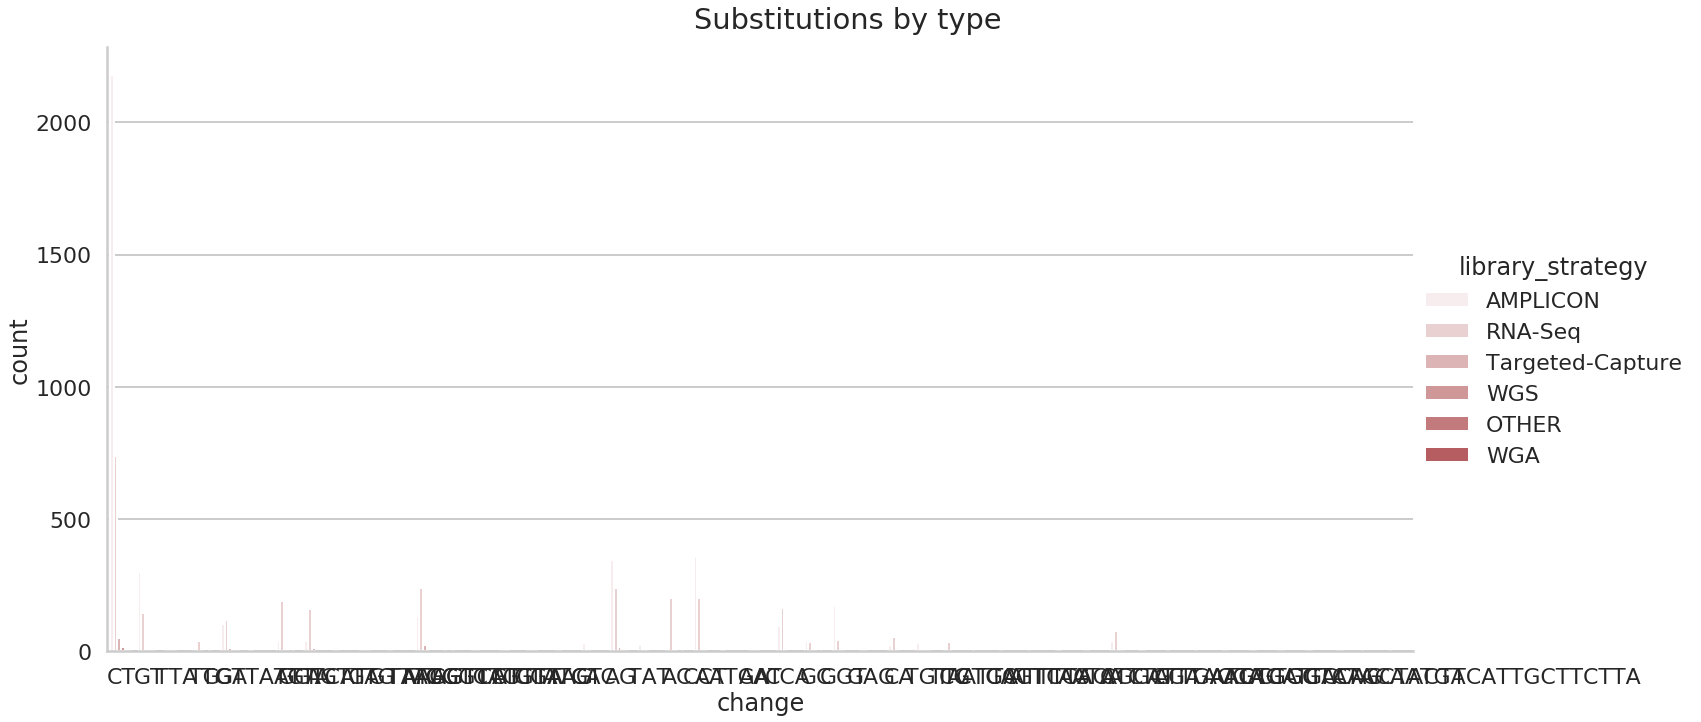

In [82]:
sns.catplot(x='change', data=va, kind="count", color='r', height=10,aspect=2,hue='library_strategy')
plt.suptitle('Substitutions by type',y=1.02)

In [83]:
ct = pysqldf('select POS, count(*) as N, Samples, Studies, Strategies change, GENE, FUNCLASS, type, func, up, down, mid from va where change = "CT" group by POS, change order by Studies desc')

In [84]:
ct

POS    N  Samples  Studies  change    GENE  FUNCLASS         type  \
0      241  608      608       16       6       .         .        5'UTR   
1     3037  560      560       12       5  orf1ab    SILENT  mat_peptide   
2     8782  131      131       10       3  orf1ab    SILENT  mat_peptide   
3    14408  376      376       10       5  orf1ab  MISSENSE  mat_peptide   
4    18060   96       96        8       3  orf1ab    SILENT  mat_peptide   
5     1059  355      355        7       3  orf1ab  MISSENSE  mat_peptide   
6    14805   32       32        6       3  orf1ab    SILENT  mat_peptide   
7    17747   82       82        6       3  orf1ab  MISSENSE  mat_peptide   
8    28253   11       11        6       2    ORF8    SILENT          CDS   
9      635    7        7        5       2  orf1ab  MISSENSE  mat_peptide   
10    3177   12       12        5       2  orf1ab  MISSENSE  mat_peptide   
11     313    7        7        4       3  orf1ab    SILENT  mat_peptide   
12    5784    5        5        4       3  orf1ab  MISSENSE  mat_peptide   
13   18877   34       34        4       2  orf1ab    SILENT  mat_peptide   
14   23086    8        8        4       2       S    SILENT          CDS   
15   28647   19       19        4       3       N  MISSENSE          CDS   
16     683    5        5        3       1  orf1ab    SILENT  mat_peptide   
17     829    3        3        3       2  orf1ab    SILENT  mat_peptide   
18     884    7        7        3       2  orf1ab  MISSENSE  mat_peptide   
19    1190    3        3        3       1  orf1ab  MISSENSE  mat_peptide   
20    2416   27       27        3       1  orf1ab    SILENT  mat_peptide   
21    2558   15       15        3       2  orf1ab  MISSENSE  mat_peptide   
22    4276    5        5        3       2  orf1ab    SILENT  mat_peptide   
23    4475    6        6        3       2  orf1ab  MISSENSE  mat_peptide   
24    4540   20       20        3       1  orf1ab    SILENT  mat_peptide   
25    5157    5        5        3       2  orf1ab  MISSENSE  mat_peptide   
26    6040    8        8        3       2  orf1ab    SILENT  mat_peptide   
27    6990    3        3        3       1  orf1ab  MISSENSE  mat_peptide   
28    7011    6        6        3       1  orf1ab  MISSENSE  mat_peptide   
29   16375    3        3        3       3  orf1ab  MISSENSE  mat_peptide   
30   16887    3        3        3       2  orf1ab    SILENT  mat_peptide   
31   18508    3        3        3       2  orf1ab  MISSENSE  mat_peptide   
32   18904    4        4        3       2  orf1ab  MISSENSE  mat_peptide   
33   21575    4        4        3       2       S  MISSENSE          CDS   
34   24034   10       10        3       2       S    SILENT          CDS   
35   24210    4        4        3       2       S  MISSENSE          CDS   
36   27335    9        9        3       3    ORF6  MISSENSE          CDS   
37     203    3        3        2       2       .         .        5'UTR   
38     222    2        2        2       2       .         .        5'UTR   
39     506    2        2        2       1  orf1ab  MISSENSE  mat_peptide   
40     512    2        2        2       1  orf1ab  MISSENSE  mat_peptide   
41     527    2        2        2       2  orf1ab    SILENT  mat_peptide   
42     593    2        2        2       2  orf1ab  MISSENSE  mat_peptide   
43     745    3        3        2       1  orf1ab    SILENT  mat_peptide   
44     823    6        6        2       1  orf1ab    SILENT  mat_peptide   
45     912    2        2        2       2  orf1ab  MISSENSE  mat_peptide   
46    1026    3        3        2       1  orf1ab  MISSENSE  mat_peptide   
47    1218    2        2        2       1  orf1ab  MISSENSE  mat_peptide   
48    1403    2        2        2       1  orf1ab  MISSENSE  mat_peptide   
49    1420    2        2        2       2  orf1ab    SILENT  mat_peptide   
50    1710    2        2        2       1  orf1ab  MISSENSE  mat_peptide   
51    1917   23       23        2       2  orf1ab  MISS

In [85]:
ga = pysqldf('select POS, count(*) as N, change, GENE, FUNCLASS, type, func, up, down, mid from va where change = "GA" group by POS')

In [86]:
ct

POS    N  Samples  Studies  change    GENE  FUNCLASS         type  \
0      241  608      608       16       6       .         .        5'UTR   
1     3037  560      560       12       5  orf1ab    SILENT  mat_peptide   
2     8782  131      131       10       3  orf1ab    SILENT  mat_peptide   
3    14408  376      376       10       5  orf1ab  MISSENSE  mat_peptide   
4    18060   96       96        8       3  orf1ab    SILENT  mat_peptide   
5     1059  355      355        7       3  orf1ab  MISSENSE  mat_peptide   
6    14805   32       32        6       3  orf1ab    SILENT  mat_peptide   
7    17747   82       82        6       3  orf1ab  MISSENSE  mat_peptide   
8    28253   11       11        6       2    ORF8    SILENT          CDS   
9      635    7        7        5       2  orf1ab  MISSENSE  mat_peptide   
10    3177   12       12        5       2  orf1ab  MISSENSE  mat_peptide   
11     313    7        7        4       3  orf1ab    SILENT  mat_peptide   
12    5784    5        5        4       3  orf1ab  MISSENSE  mat_peptide   
13   18877   34       34        4       2  orf1ab    SILENT  mat_peptide   
14   23086    8        8        4       2       S    SILENT          CDS   
15   28647   19       19        4       3       N  MISSENSE          CDS   
16     683    5        5        3       1  orf1ab    SILENT  mat_peptide   
17     829    3        3        3       2  orf1ab    SILENT  mat_peptide   
18     884    7        7        3       2  orf1ab  MISSENSE  mat_peptide   
19    1190    3        3        3       1  orf1ab  MISSENSE  mat_peptide   
20    2416   27       27        3       1  orf1ab    SILENT  mat_peptide   
21    2558   15       15        3       2  orf1ab  MISSENSE  mat_peptide   
22    4276    5        5        3       2  orf1ab    SILENT  mat_peptide   
23    4475    6        6        3       2  orf1ab  MISSENSE  mat_peptide   
24    4540   20       20        3       1  orf1ab    SILENT  mat_peptide   
25    5157    5        5        3       2  orf1ab  MISSENSE  mat_peptide   
26    6040    8        8        3       2  orf1ab    SILENT  mat_peptide   
27    6990    3        3        3       1  orf1ab  MISSENSE  mat_peptide   
28    7011    6        6        3       1  orf1ab  MISSENSE  mat_peptide   
29   16375    3        3        3       3  orf1ab  MISSENSE  mat_peptide   
30   16887    3        3        3       2  orf1ab    SILENT  mat_peptide   
31   18508    3        3        3       2  orf1ab  MISSENSE  mat_peptide   
32   18904    4        4        3       2  orf1ab  MISSENSE  mat_peptide   
33   21575    4        4        3       2       S  MISSENSE          CDS   
34   24034   10       10        3       2       S    SILENT          CDS   
35   24210    4        4        3       2       S  MISSENSE          CDS   
36   27335    9        9        3       3    ORF6  MISSENSE          CDS   
37     203    3        3        2       2       .         .        5'UTR   
38     222    2        2        2       2       .         .        5'UTR   
39     506    2        2        2       1  orf1ab  MISSENSE  mat_peptide   
40     512    2        2        2       1  orf1ab  MISSENSE  mat_peptide   
41     527    2        2        2       2  orf1ab    SILENT  mat_peptide   
42     593    2        2        2       2  orf1ab  MISSENSE  mat_peptide   
43     745    3        3        2       1  orf1ab    SILENT  mat_peptide   
44     823    6        6        2       1  orf1ab    SILENT  mat_peptide   
45     912    2        2        2       2  orf1ab  MISSENSE  mat_peptide   
46    1026    3        3        2       1  orf1ab  MISSENSE  mat_peptide   
47    1218    2        2        2       1  orf1ab  MISSENSE  mat_peptide   
48    1403    2        2        2       1  orf1ab  MISSENSE  mat_peptide   
49    1420    2        2        2       2  orf1ab    SILENT  mat_peptide   
50    1710    2        2        2       1  orf1ab  MISSENSE  mat_peptide   
51    1917   23       23        2       2  orf1ab  MISS

Text(0.5, 0.98, 'Number of Samples with a given C->T substitution vs. upstream motif')

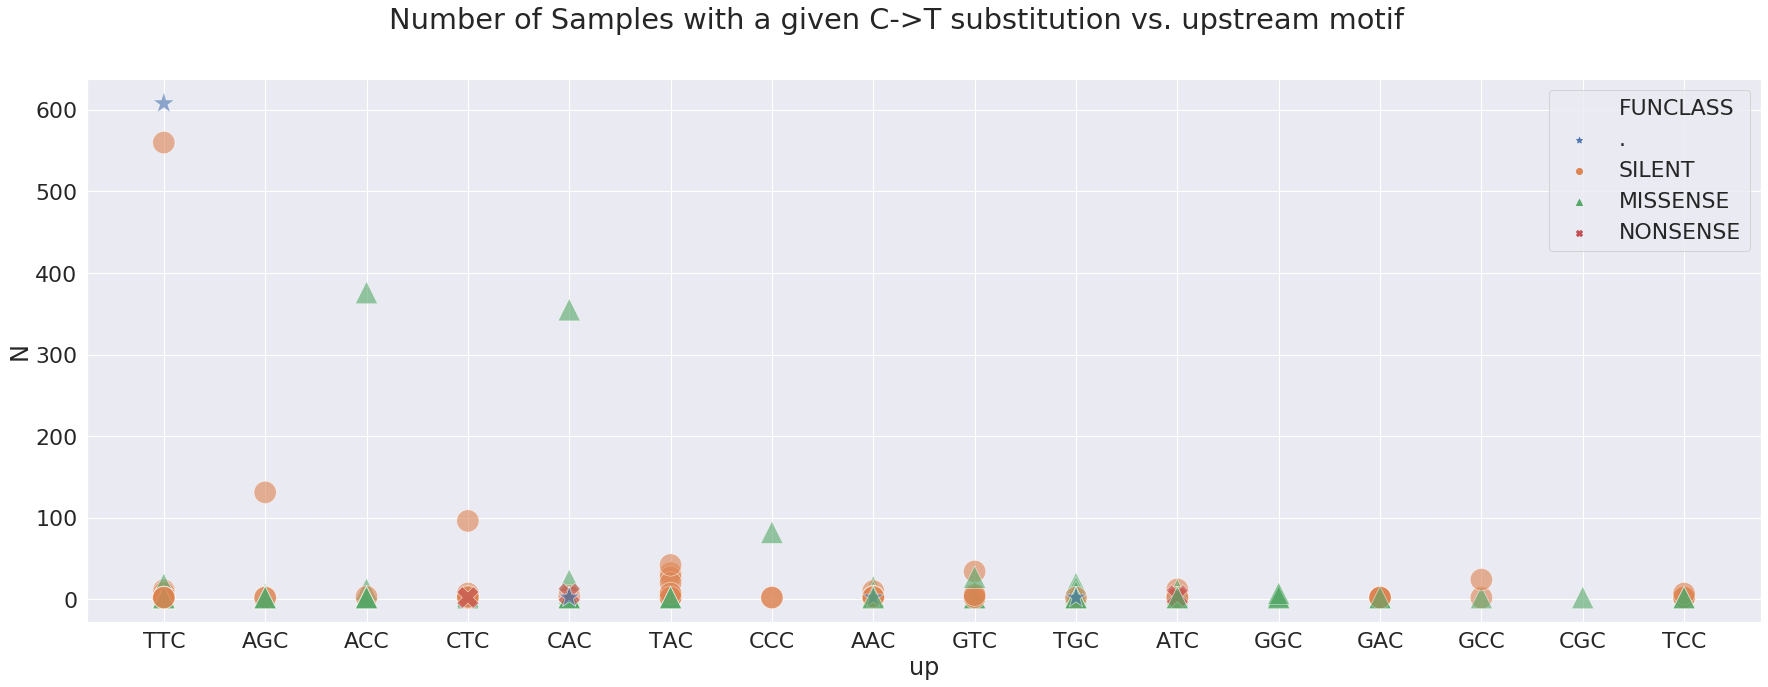

In [87]:
sns.set(font_scale=2)
plt.figure(figsize=(30,10))
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}
sns.scatterplot(x='up',y='N',s=500,data=ct,alpha=0.6,style='FUNCLASS',hue='FUNCLASS',markers=markers)
#plt.yscale('log')
plt.suptitle('Number of Samples with a given C->T substitution vs. upstream motif')

Text(0.5, 1.02, 'Distinct C-to-T sites versus upstream context')

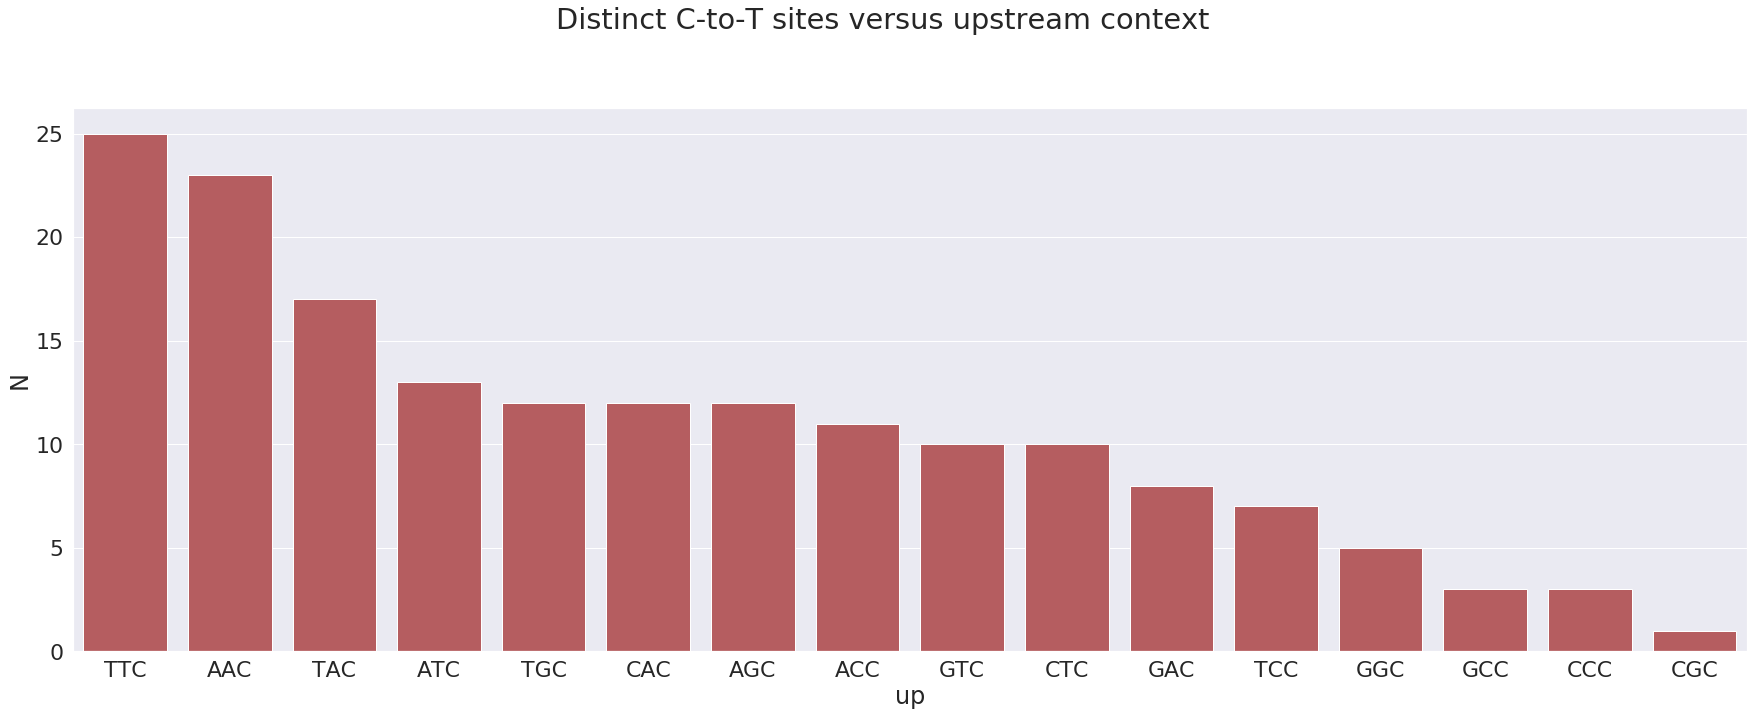

In [88]:
plt.figure(figsize=(30,10))
sns.barplot(x='up',y='N', data=pysqldf('select up, count(*) as N from ct group by up order by N desc'),color='r')
plt.suptitle('Distinct C-to-T sites versus upstream context',y=1.02)

In [89]:
print(pysqldf('select * from ct where N > 100 order by POS').to_markdown())

|    |   POS |   N |   Samples |   Studies |   change | GENE   | FUNCLASS   | type        | func   | up   | down   | mid   |
|---:|------:|----:|----------:|----------:|---------:|:-------|:-----------|:------------|:-------|:-----|:-------|:------|
|  0 |   241 | 608 |       608 |        16 |        6 | .      | .          | 5'UTR       | .      | TTC  | CGT    | TCG   |
|  1 |  1059 | 355 |       355 |         7 |        3 | orf1ab | MISSENSE   | mat_peptide | nsp2   | CAC  | CCT    | ACC   |
|  2 |  3037 | 560 |       560 |        12 |        5 | orf1ab | SILENT     | mat_peptide | nsp3   | TTC  | CTA    | TCT   |
|  3 |  8782 | 131 |       131 |        10 |        3 | orf1ab | SILENT     | mat_peptide | nsp4   | AGC  | CCA    | GCC   |
|  4 | 14408 | 376 |       376 |        10 |        5 | orf1ab | MISSENSE   | mat_peptide | RdRp   | ACC  | CTA    | CCT   |


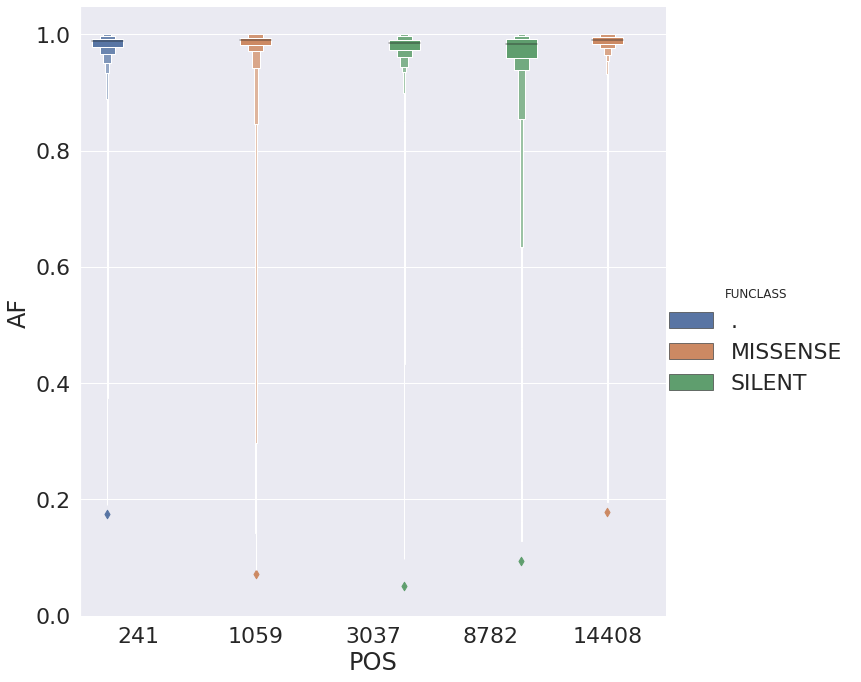

In [90]:
sns.catplot(x='POS',y='AF',height=10,kind='boxen',data=va[ ( va['POS'].isin(ct[ct['N']>100]['POS'].to_numpy()) ) & (va['change']=='CT')],hue='FUNCLASS')

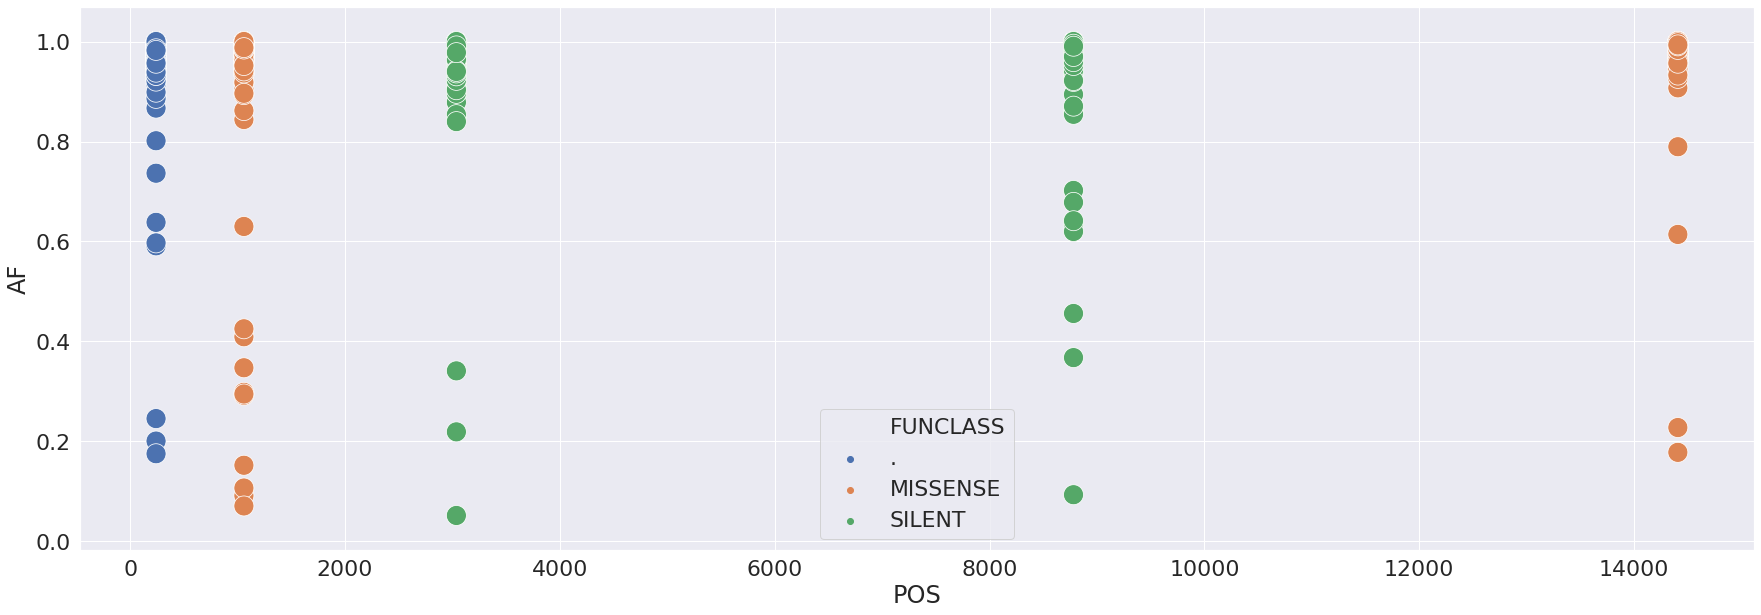

In [91]:
plt.figure(figsize=(30,10))
sns.scatterplot(x='POS',y='AF',data=va[ ( va['POS'].isin(ct[ct['N']>100]['POS'].to_numpy()) ) & (va['change']=='CT')],s=400,hue='FUNCLASS')

In [92]:
ct[ct['N']>100]

POS    N  Samples  Studies  change    GENE  FUNCLASS         type  func  \
0    241  608      608       16       6       .         .        5'UTR     .   
1   3037  560      560       12       5  orf1ab    SILENT  mat_peptide  nsp3   
2   8782  131      131       10       3  orf1ab    SILENT  mat_peptide  nsp4   
3  14408  376      376       10       5  orf1ab  MISSENSE  mat_peptide  RdRp   
5   1059  355      355        7       3  orf1ab  MISSENSE  mat_peptide  nsp2   

    up down  mid  
0  TTC  CGT  TCG  
1  TTC  CTA  TCT  
2  AGC  CCA  GCC  
3  ACC  CTA  CCT  
5  CAC  CCT  ACC

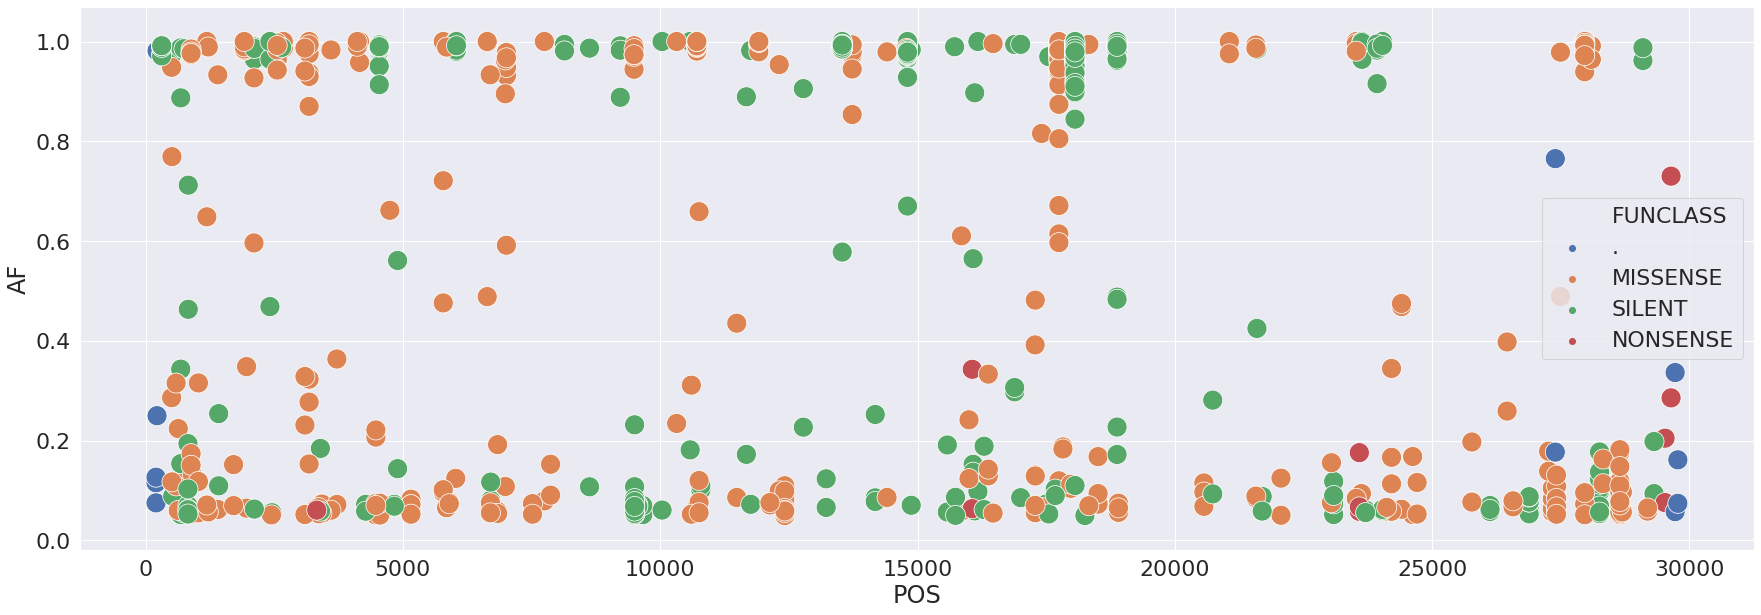

In [93]:
plt.figure(figsize=(30,10))
sns.scatterplot(x='POS',y='AF',data=va[ ( va['POS'].isin(ct[ct['N']<100]['POS'].to_numpy()) ) & (va['change']=='CT')],s=400,hue='FUNCLASS')

Text(0.5, 0.98, 'Number of Samples with a given G->A substitution vs. downstream motif')

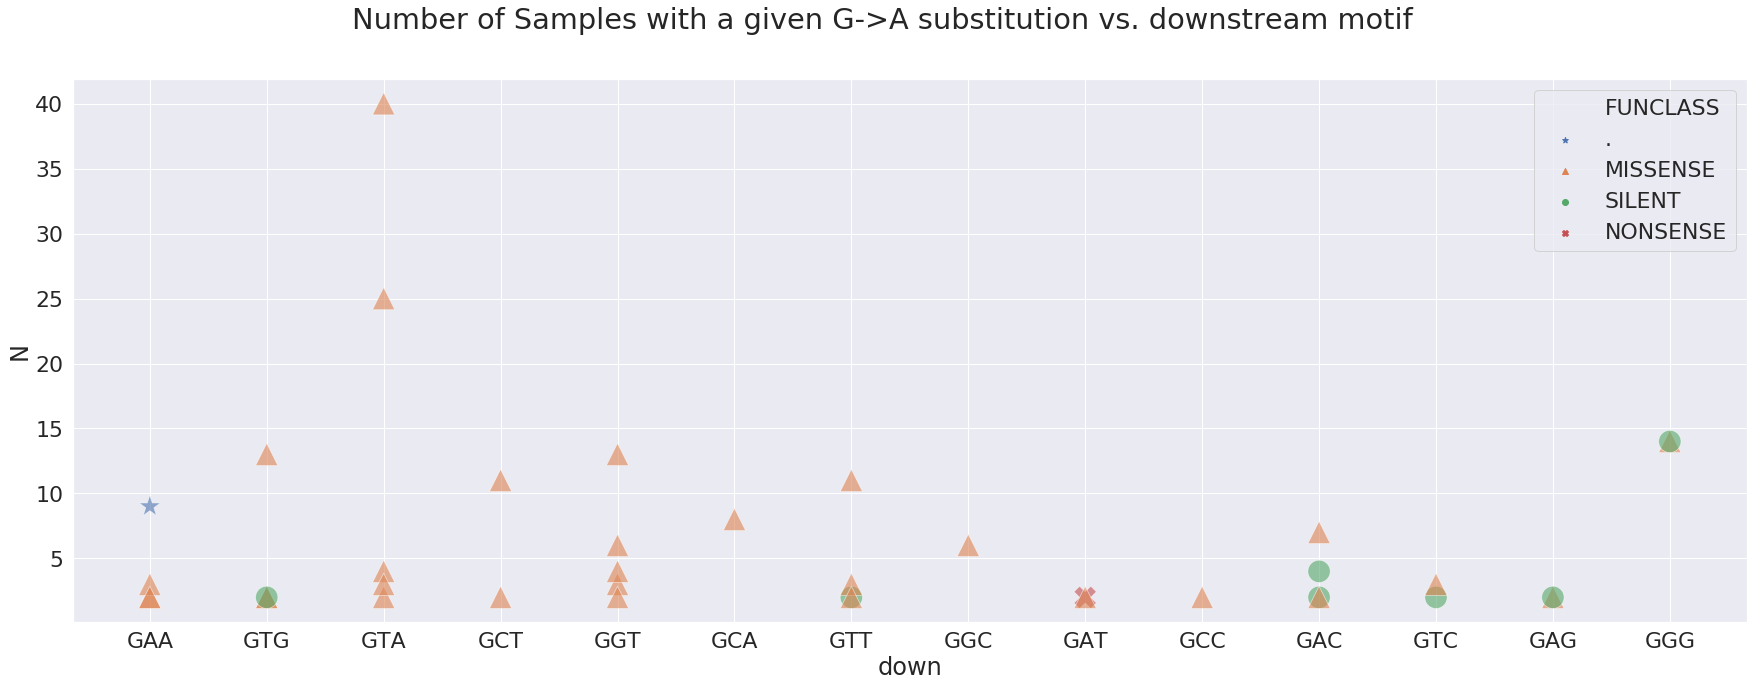

In [94]:
sns.set(font_scale=2)
plt.figure(figsize=(30,10))
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}
sns.scatterplot(x='down',y='N',s=500,data=ga,alpha=0.6,style='FUNCLASS',hue='FUNCLASS',markers=markers)
#plt.yscale('log')
plt.suptitle('Number of Samples with a given G->A substitution vs. downstream motif')

Text(0.5, 1.02, 'Distinct G-to-A sites versus downstream context')

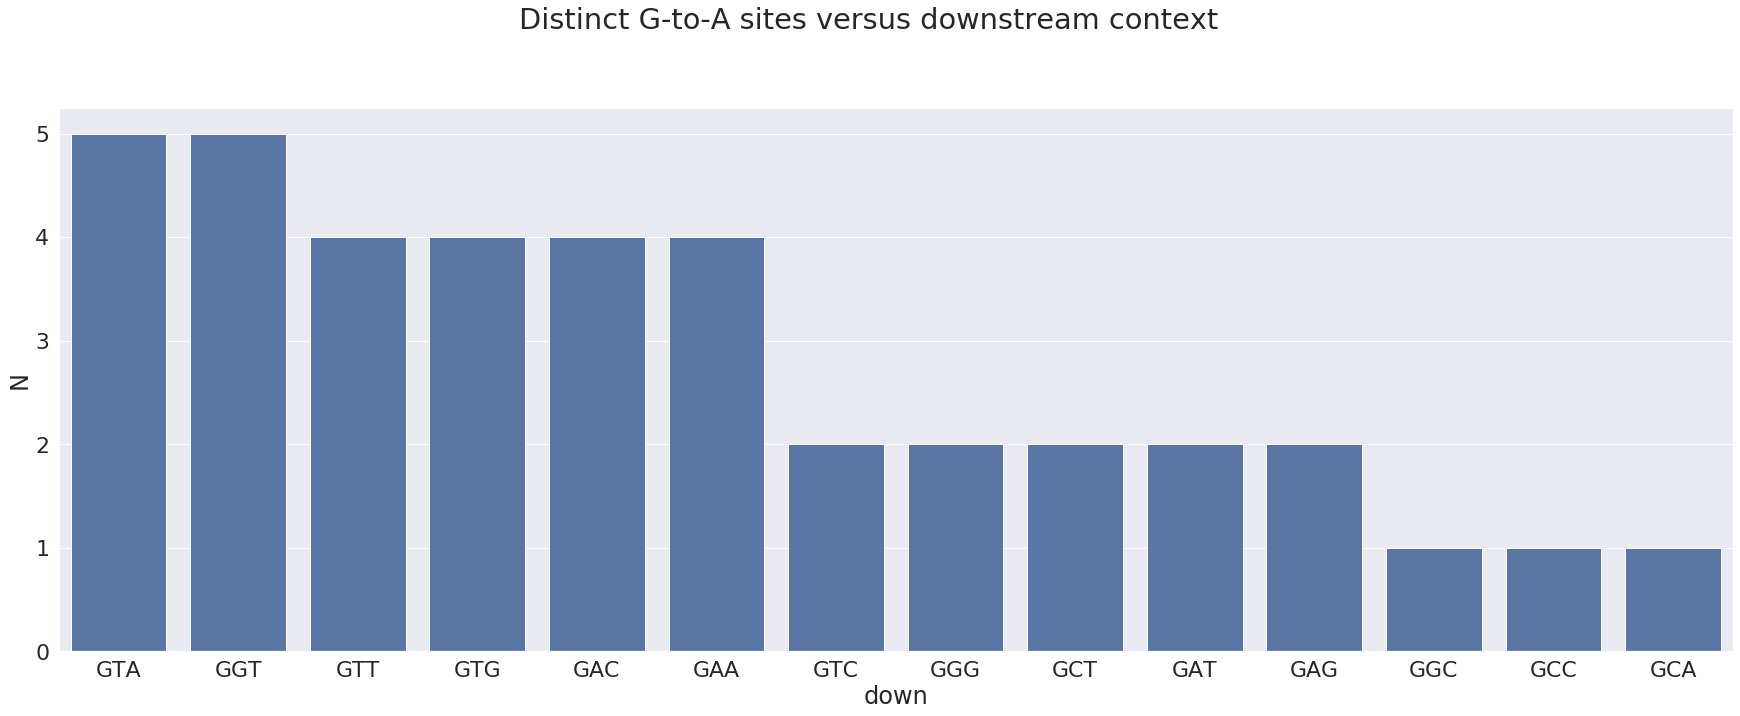

In [95]:
plt.figure(figsize=(30,10))
sns.barplot(x='down',y='N', data=pysqldf('select down, count(*) as N from ga group by down order by N desc'),color='b')
plt.suptitle('Distinct G-to-A sites versus downstream context',y=1.02)

In [96]:
print(ga[ga['N']>15].to_markdown())

|    |   POS |   N | change   | GENE   | FUNCLASS   | type        | func   | up   | down   | mid   |
|---:|------:|----:|:---------|:-------|:-----------|:------------|:-------|:-----|:-------|:------|
|  2 |  1397 |  25 | GA       | orf1ab | MISSENSE   | mat_peptide | nsp2   | AAG  | GTA    | AGT   |
| 33 | 23616 |  40 | GA       | S      | MISSENSE   | CDS         | S      | ACG  | GTA    | CGT   |


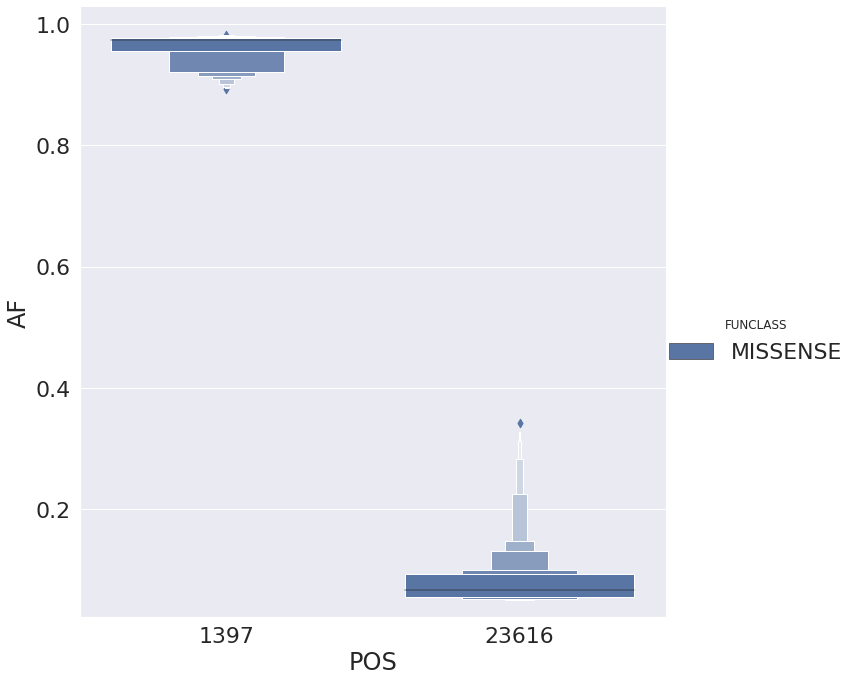

In [97]:
sns.catplot(x='POS',y='AF',height=10,kind='boxen',data=va[ ( va['POS'].isin(ga[ga['N']>15]['POS'].to_numpy()) ) & (va['change']=='GA')],hue='FUNCLASS')

In [98]:
va[ ( va['POS'].isin(ga[ga['N']>15]['POS'].to_numpy()) ) & (va['change']=='GA') & ( ( va['POS']==28882 ) | ( va['POS']==28881 ) ) ].sort_values(by=['Sample','POS'],ascending=True)

Empty DataFrame
Columns: [Sample, POS, REF, ALT, DP, AF, SB, DP4, IMPACT, FUNCLASS, EFFECT, GENE, CODON, change, study_accession, library_strategy, library_source, library_selection, collection_date, geo_loc_name, type, func, start, end, A, C, G, T, Samples, Studies, Strategies, up, down, mid, left, right]
Index: []

In [99]:
a = pysqldf('select Sample, AF as AF1 from va where POS = 28881 and change="GA"')
b = pysqldf('select Sample, AF as AF2 from va where POS = 28882 and change="GA"')
c = pysqldf('select a.Sample, AF1, AF2, (AF1-AF2)/(AF1+AF2) as dif from a left join b on a.Sample = b.Sample')

Text(0.5, 1.02, '(AF_28881-AF_28882)/AF_28881+AF_28882)')

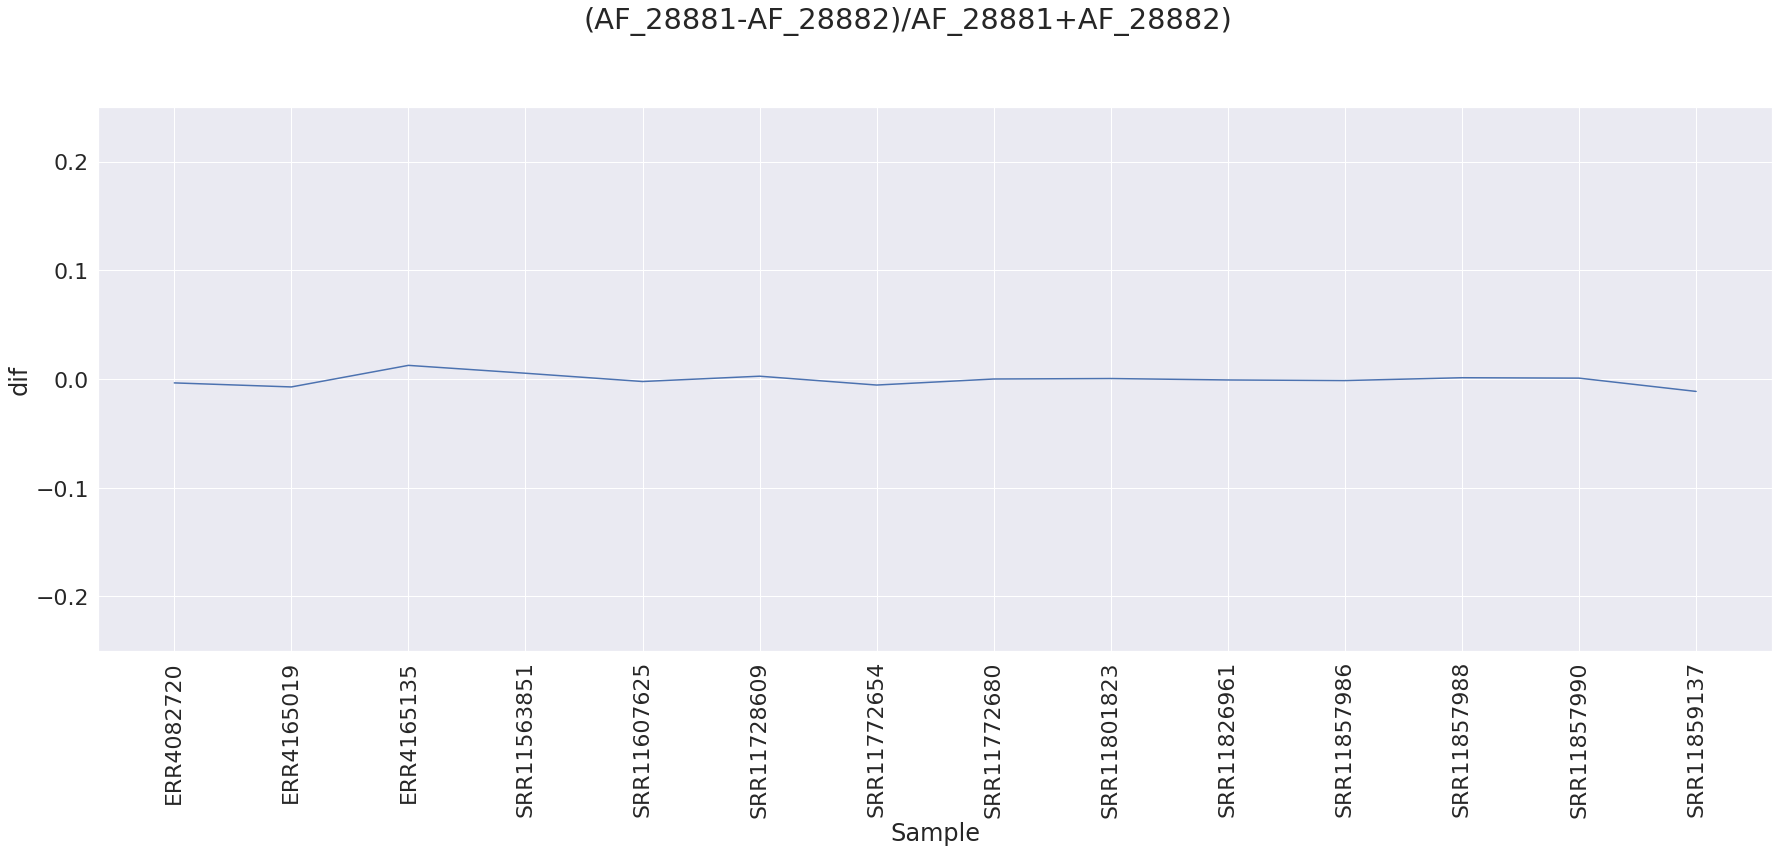

In [100]:
plt.figure(figsize=(30,10))
g = sns.lineplot(x='Sample', y='dif',data=c)
g.set(ylim=(-.25,.25))
plt.xticks(rotation=90)
plt.suptitle('(AF_28881-AF_28882)/AF_28881+AF_28882)',y=1.02)

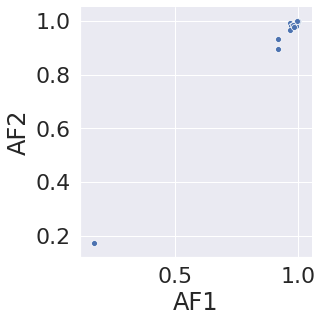

In [101]:
sns.relplot(x='AF1',y='AF2',data=c)

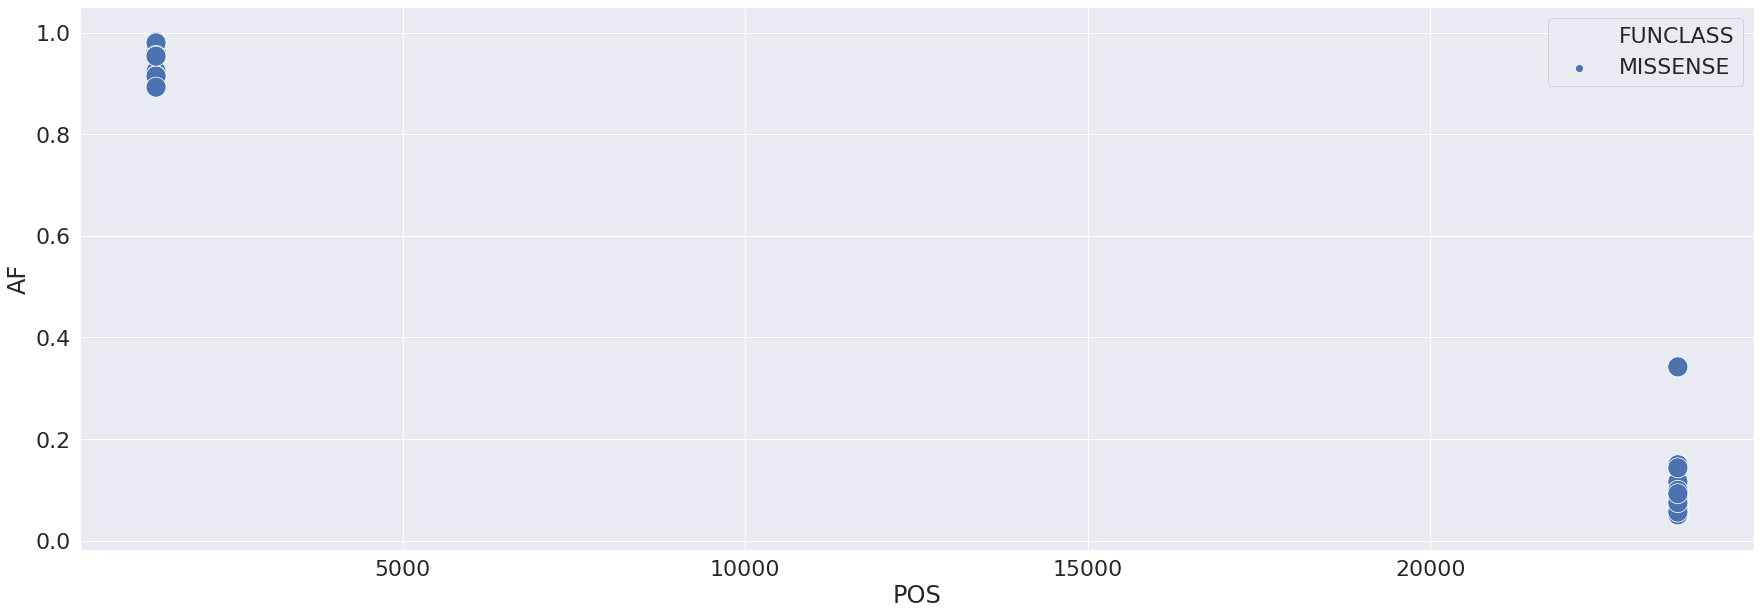

In [102]:
plt.figure(figsize=(30,10))
sns.scatterplot(x='POS',y='AF',data=va[ ( va['POS'].isin(ga[ga['N']>15]['POS'].to_numpy()) ) & (va['change']=='GA')],s=400,hue='FUNCLASS')

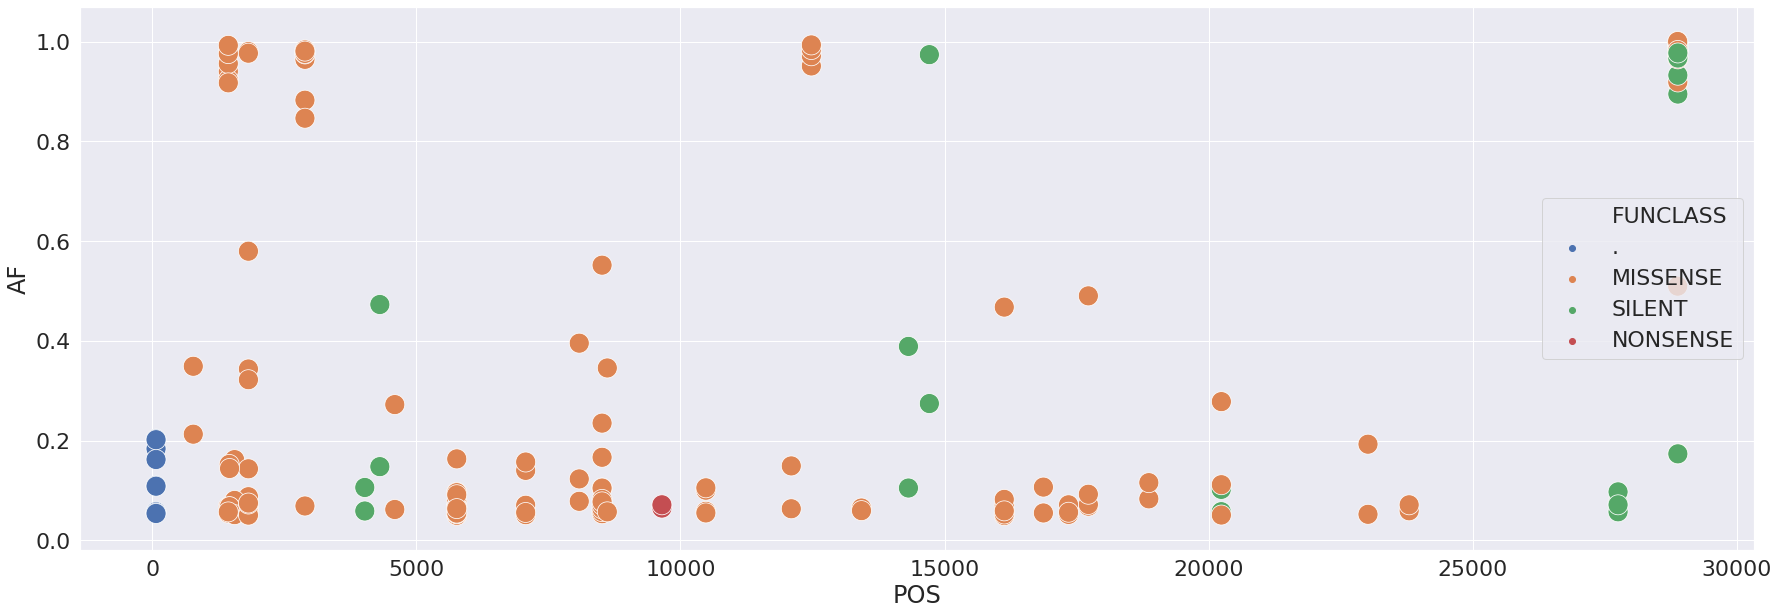

In [103]:
plt.figure(figsize=(30,10))
sns.scatterplot(x='POS',y='AF',data=va[ ( va['POS'].isin(ga[ga['N']<=15]['POS'].to_numpy()) ) & (va['change']=='GA')],s=400,hue='FUNCLASS')

## Analysis of ADAR editing

In [104]:
ag = pysqldf('select POS, count(*) as N, change, GENE, FUNCLASS, type, func, mid,left,right from va where change = "AG" group by POS, change')
tc = pysqldf('select POS, count(*) as N, change, GENE, FUNCLASS, type, func, mid,left,right from va where change = "TC" group by POS, change')

In [105]:
ag['left-right']=ag['left']+ag['right']
tc['left-right']=tc['left']+tc['right']

In [106]:
ag

POS    N change    GENE  FUNCLASS         type      func  mid left  \
0    1049    2     AG  orf1ab  MISSENSE  mat_peptide      nsp2  GAA    G   
1    1290    2     AG  orf1ab  MISSENSE  mat_peptide      nsp2  GAA    G   
2    1515    4     AG  orf1ab  MISSENSE  mat_peptide      nsp2  CAT    C   
3    1637    2     AG  orf1ab  MISSENSE  mat_peptide      nsp2  GAA    G   
4    2018    5     AG  orf1ab  MISSENSE  mat_peptide      nsp2  GAT    G   
5    2480    9     AG  orf1ab  MISSENSE  mat_peptide      nsp2  AAT    A   
6    3046    3     AG  orf1ab    SILENT  mat_peptide      nsp3  CAG    C   
7    3337    5     AG  orf1ab    SILENT  mat_peptide      nsp3  AAG    A   
8    3942    2     AG  orf1ab  MISSENSE  mat_peptide      nsp3  AAA    A   
9    5570   15     AG  orf1ab  MISSENSE  mat_peptide      nsp3  TAT    T   
10   6466    2     AG  orf1ab    SILENT  mat_peptide      nsp3  AAA    A   
11   7451    2     AG  orf1ab  MISSENSE  mat_peptide      nsp3  AAG    A   
12   8465    3     AG  orf1ab  MISSENSE  mat_peptide      nsp3  TAA    T   
13  10236    2     AG  orf1ab  MISSENSE  mat_peptide     3Cpro  AAG    A   
14  10323    2     AG  orf1ab  MISSENSE  mat_peptide     3Cpro  AAG    A   
15  11425    2     AG  orf1ab    SILENT  mat_peptide      nsp6  AAG    A   
16  11849    5     AG  orf1ab  MISSENSE  mat_peptide      nsp7  AAT    A   
17  12764    2     AG  orf1ab  MISSENSE  mat_peptide      nsp9  CAA    C   
18  16467    4     AG  orf1ab    SILENT  mat_peptide  helicase  CAC    C   
19  17233    6     AG  orf1ab  MISSENSE  mat_peptide  helicase  AAT    A   
20  17292    2     AG  orf1ab    SILENT  mat_peptide  helicase  TAG    T   
21  17342    2     AG  orf1ab  MISSENSE  mat_peptide  helicase  GAT    G   
22  17858   83     AG  orf1ab  MISSENSE  mat_peptide  helicase  TAT    T   
23  18147    2     AG  orf1ab    SILENT  mat_peptide      ExoN  AAG    A   
24  20236    2     AG  orf1ab  MISSENSE  mat_peptide     endoR  CAG    C   
25  20268    5     AG  orf1ab    SILENT  mat_peptide     endoR  TAG    T   
26  21203    2     AG  orf1ab  MISSENSE  mat_peptide    MethTr  AAG    A   
27  23403  399     AG       S  MISSENSE          CDS         S  GAT    G   
28  24779    4     AG       S  MISSENSE          CDS         S  AAA    A   
29  25008    2     AG       S  MISSENSE          CDS         S  AAG    A   
30  25136    3     AG       S  MISSENSE          CDS         S  GAA    G   
31  26069    3     AG   ORF3a  MISSENSE          CDS     orf3a  GAA    G   
32  28293    2     AG       N  MISSENSE          CDS         N  CAA    C   
33  28898    6     AG       N  MISSENSE          CDS         N  TAG    T   
34  29031    2     AG       N  MISSENSE          CDS         N  GAG    G   
35  29188    2     AG       N    SILENT          CDS         N  CAC    C   
36  29700    3     AG       .         .        3'UTR         .  TAG    T   

   right left-right  
0      A         GA  
1      A         GA  
2      T         CT  
3      A         GA  
4      T         GT  
5      T         AT  
6      G         CG  
7      G         AG  
8      A         AA  
9      T         TT  
10     A         AA  
11     G         AG  
12     A         TA  
13     G         AG  
14     G         AG  
15     G         AG  
16     T         AT  
17     A         CA  
18     C         CC  
19     T         AT  
20     G         TG  
21     T         GT  
22     T         TT  
23     G         AG  
24     G         CG  
25     G         TG  
26     G         AG  
27     T         GT  
28     A         AA  
29     G         AG  
30     A         GA  
31     A         GA  
32     A         CA  
33     G         TG  
34     G         GG  
35     C         CC  
36     G         TG

In [107]:
pysqldf('select "left-right",count(*) as N from ag group by "left-right" order by N desc')["left-right"].to_numpy()

array(['AG', 'GA', 'TG', 'GT', 'AT', 'AA', 'TT', 'CG', 'CC', 'CA', 'TA',
       'GG', 'CT'], dtype=object)

Text(0.5, 0.98, 'Number of Samples with a given A->G substitution vs. context')

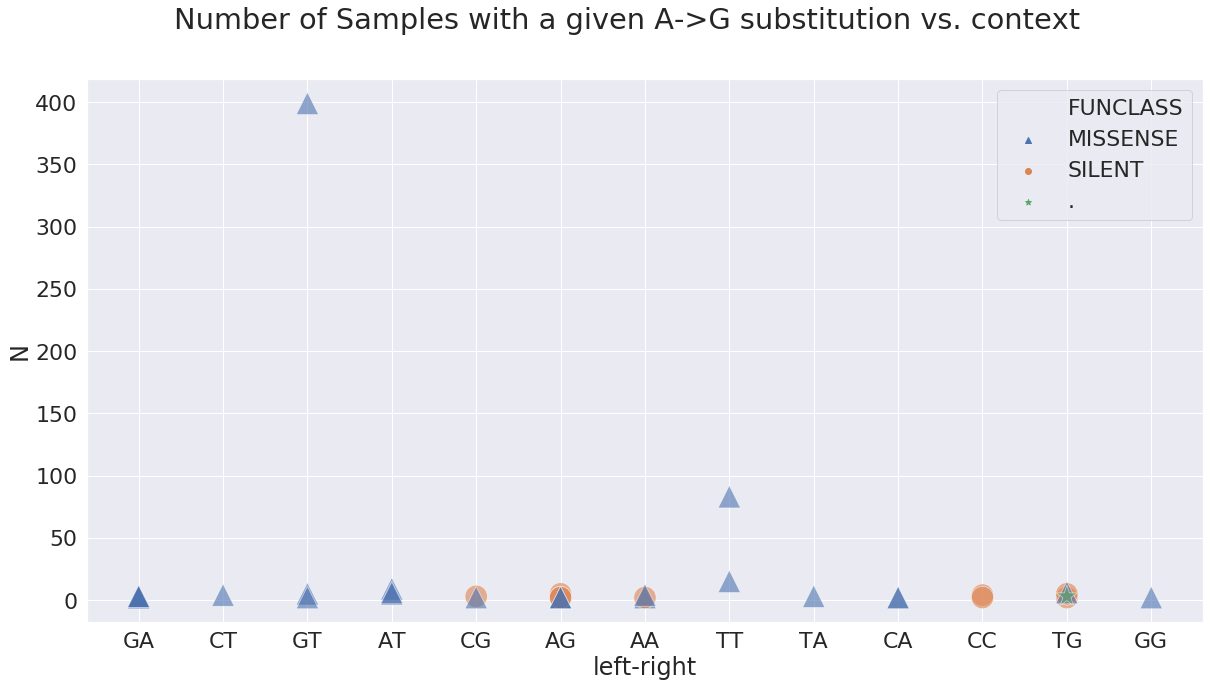

In [108]:
sns.set(font_scale=2)
plt.figure(figsize=(20,10))
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}
sns.scatterplot(x='left-right',y='N',s=500,data=ag,alpha=0.6,style='FUNCLASS',hue='FUNCLASS',markers=markers)
#plt.yscale('log')
plt.suptitle('Number of Samples with a given A->G substitution vs. context')

Text(0.5, 1.02, 'Distinct A->G sites vs. -1/+1 context')

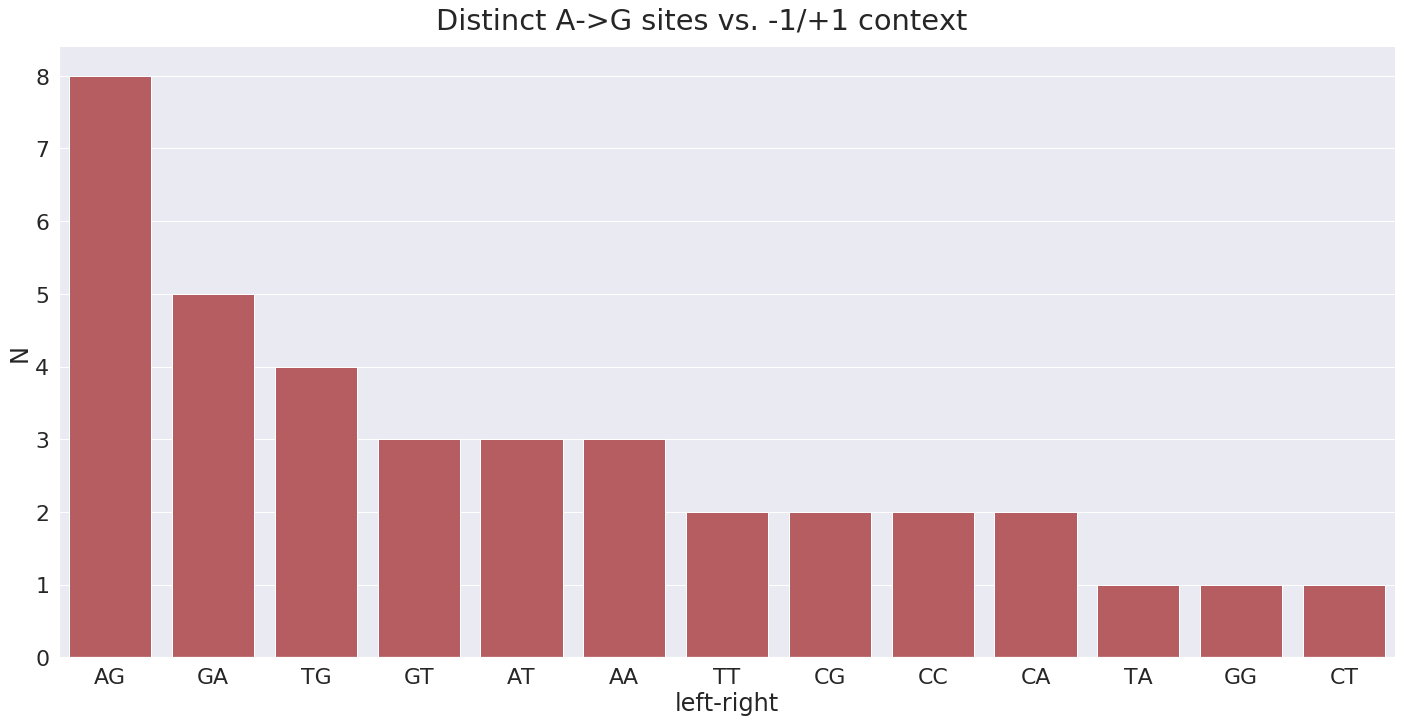

In [109]:
sns.catplot(x='left-right',y='N',kind='bar',data=pysqldf('select "left-right", count(*) as N from ag group by "left-right" order by N desc'),height=10,aspect=2,color='r')
plt.suptitle('Distinct A->G sites vs. -1/+1 context',y=1.02)

In [110]:
print(ag[ag['N']>80].to_markdown())

|    |   POS |   N | change   | GENE   | FUNCLASS   | type        | func     | mid   | left   | right   | left-right   |
|---:|------:|----:|:---------|:-------|:-----------|:------------|:---------|:------|:-------|:--------|:-------------|
| 22 | 17858 |  83 | AG       | orf1ab | MISSENSE   | mat_peptide | helicase | TAT   | T      | T       | TT           |
| 27 | 23403 | 399 | AG       | S      | MISSENSE   | CDS         | S        | GAT   | G      | T       | GT           |


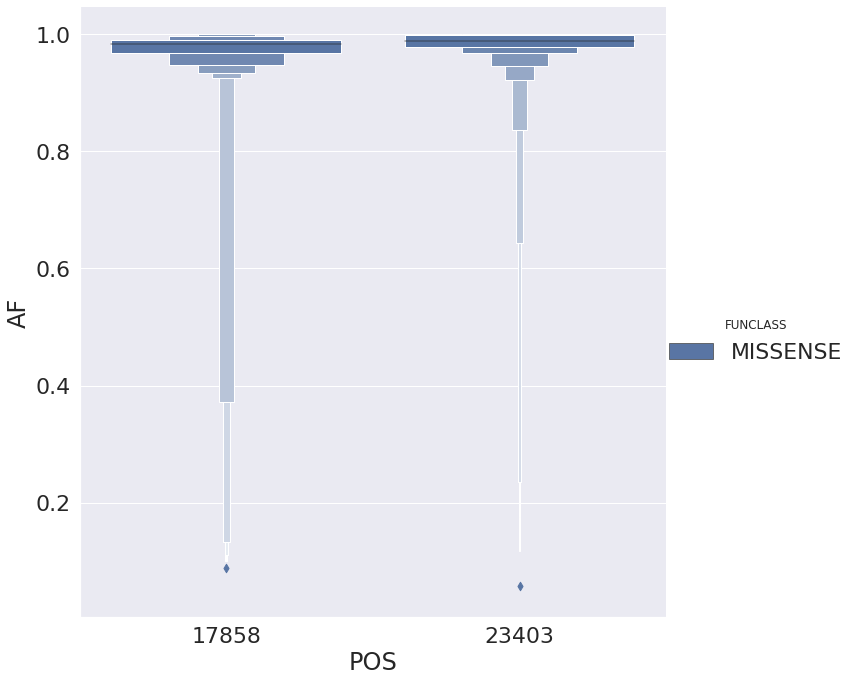

In [111]:
sns.catplot(x='POS',y='AF',height=10,kind='boxen',data=va[ ( va['POS'].isin(ag[ag['N']>80]['POS'].to_numpy()) ) & (va['change']=='AG')],hue='FUNCLASS')

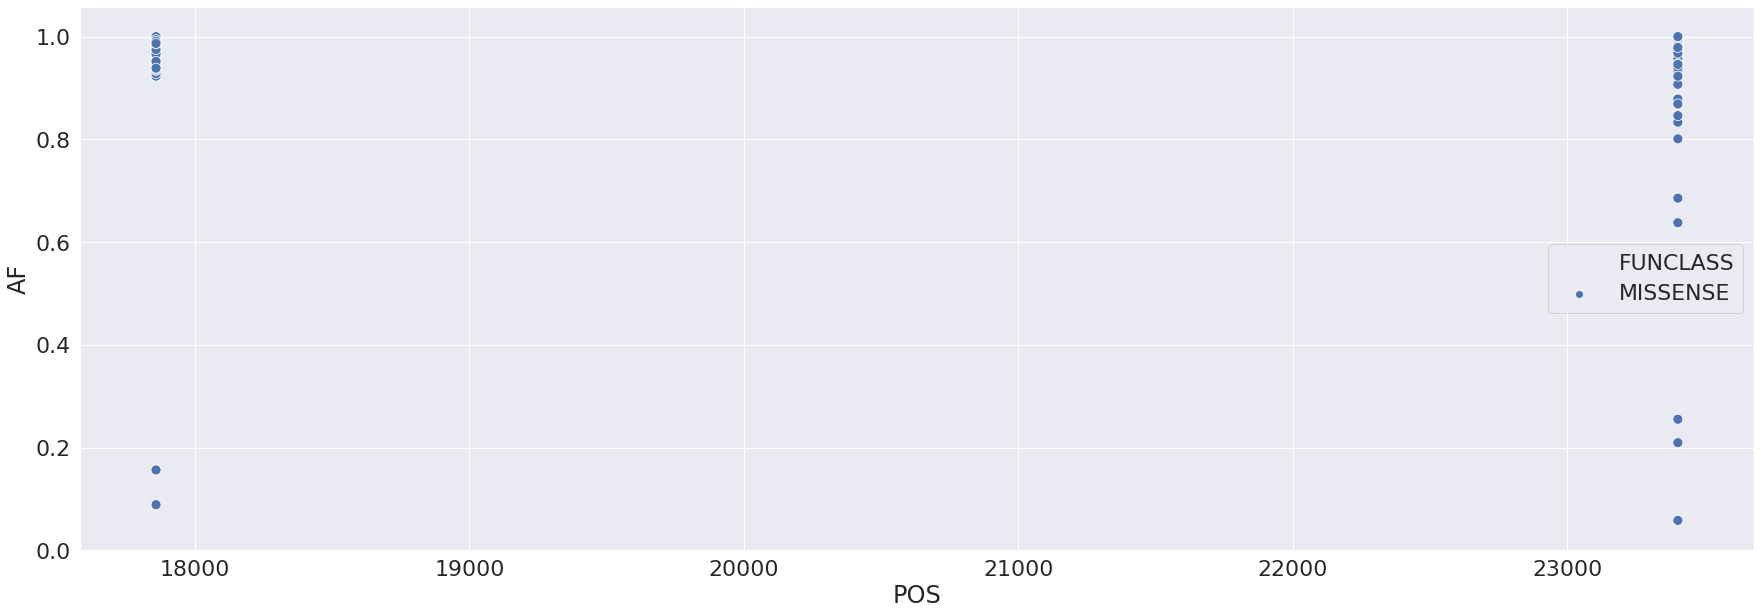

In [112]:
plt.figure(figsize=(30,10))
sns.scatterplot(x='POS',y='AF',data=va[ ( va['POS'].isin(ag[ag['N']>80]['POS'].to_numpy()) ) & (va['change']=='AG')],s=100,hue='FUNCLASS')

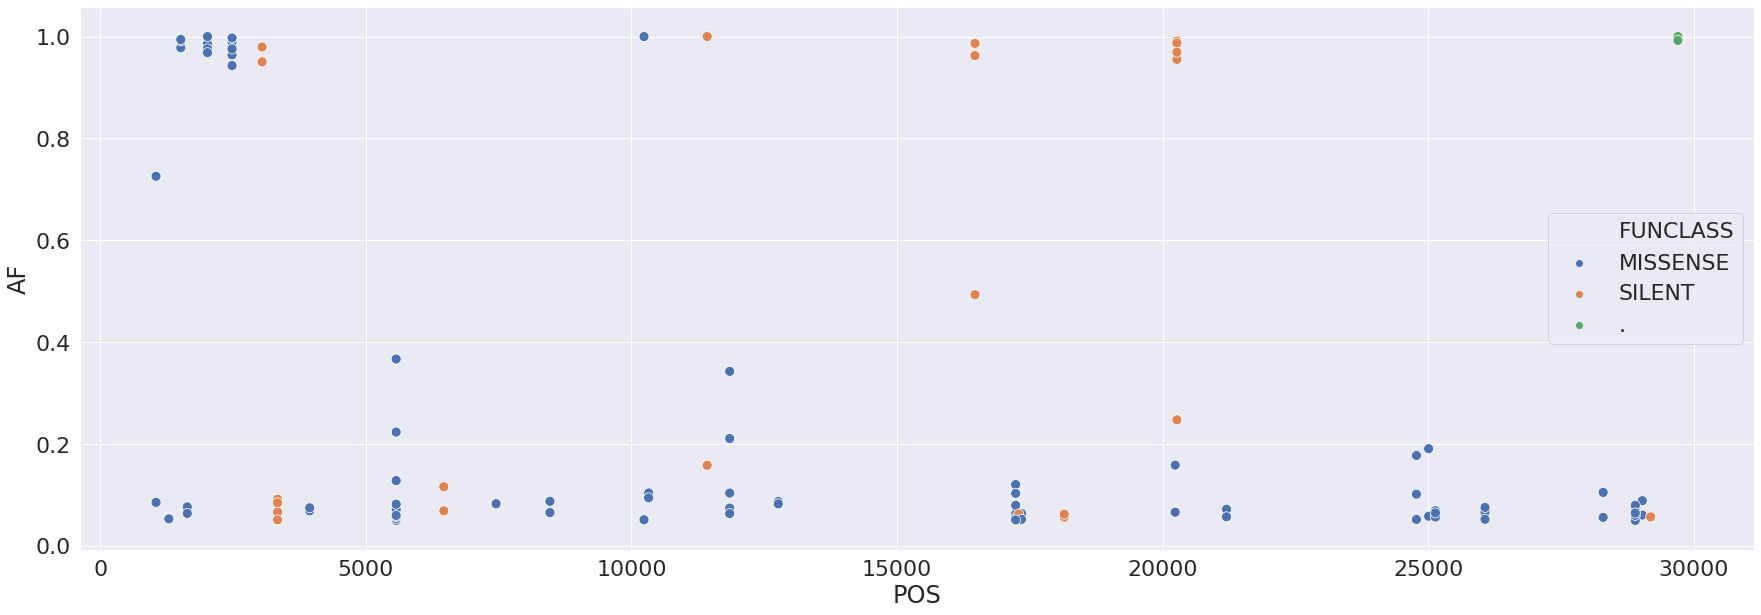

In [113]:
plt.figure(figsize=(30,10))
sns.scatterplot(x='POS',y='AF',data=va[ ( va['POS'].isin(ag[ag['N']<80]['POS'].to_numpy()) ) & (va['change']=='AG')],s=100,hue='FUNCLASS')

Text(0.5, 0.98, 'Number of Samples with a given T->C substitution vs. context')

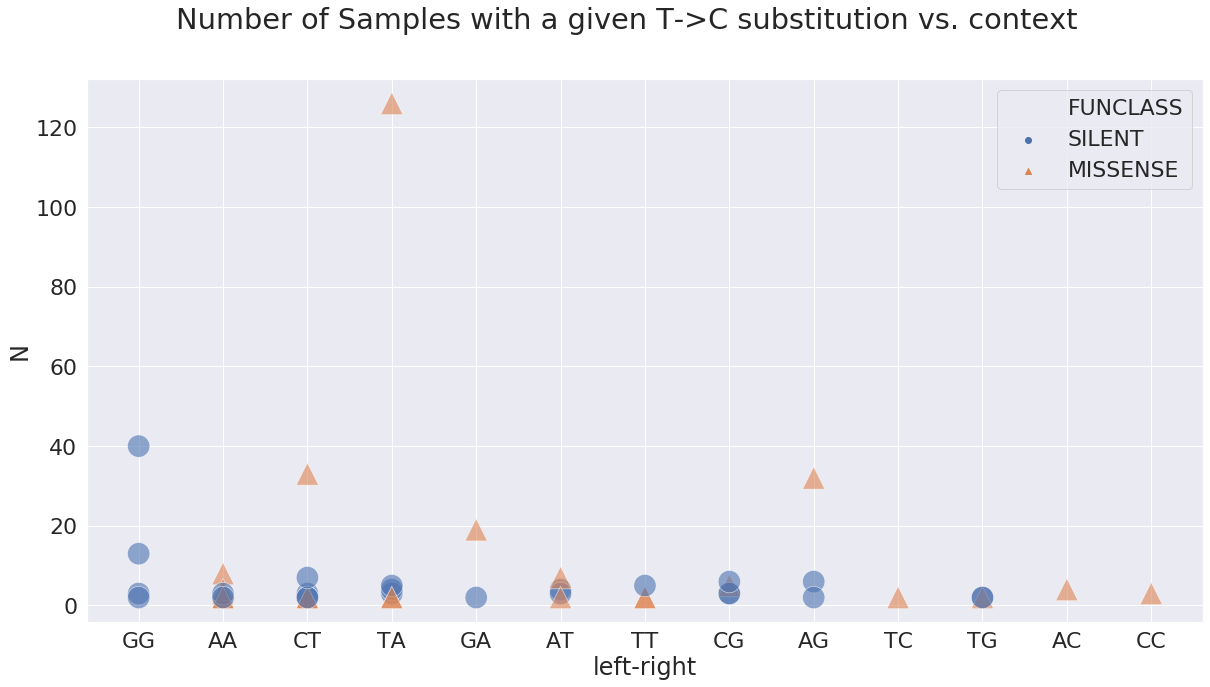

In [114]:
sns.set(font_scale=2)
plt.figure(figsize=(20,10))
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}
sns.scatterplot(x='left-right',y='N',s=500,data=tc,alpha=0.6,style='FUNCLASS',hue='FUNCLASS',markers=markers)
#plt.yscale('log')
plt.suptitle('Number of Samples with a given T->C substitution vs. context')

Text(0.5, 1.02, 'Distinct T->C sites vs. context')

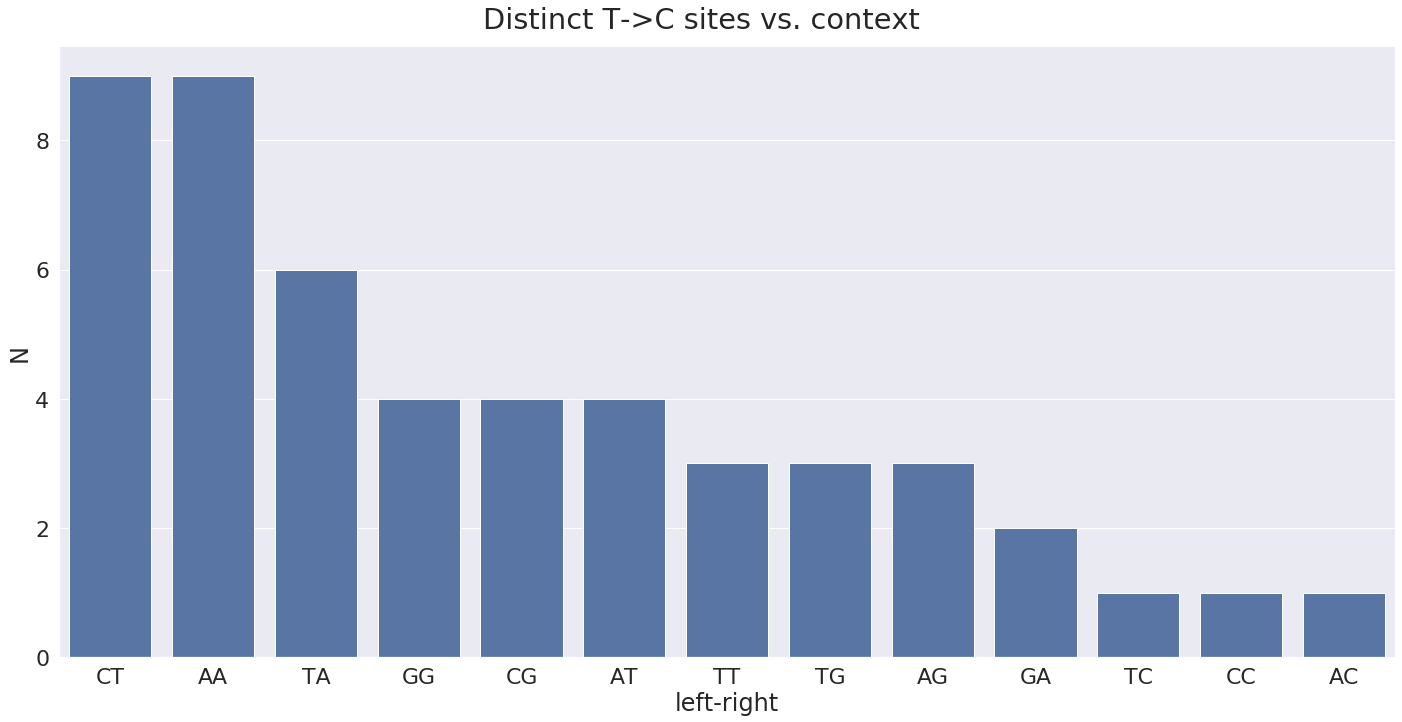

In [115]:
sns.catplot(x='left-right',y='N',kind='bar',data=pysqldf('select "left-right", count(*) as N from tc group by "left-right" order by N desc'),height=10,aspect=2,color='b')
plt.suptitle('Distinct T->C sites vs. context',y=1.02)

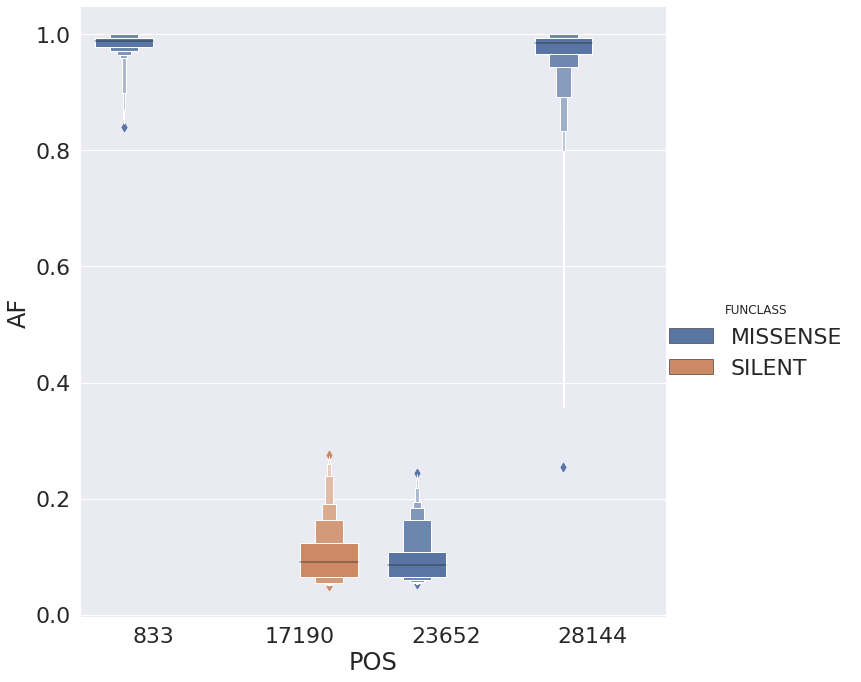

In [116]:
sns.catplot(x='POS',y='AF',height=10,kind='boxen',data=va[ ( va['POS'].isin(tc[tc['N']>20]['POS'].to_numpy()) ) & (va['change']=='TC')],hue='FUNCLASS')

In [117]:
print(tc[tc['N']>20].to_markdown())

|    |   POS |   N | change   | GENE   | FUNCLASS   | type        | func     | mid   | left   | right   | left-right   |
|---:|------:|----:|:---------|:-------|:-----------|:------------|:---------|:------|:-------|:--------|:-------------|
|  2 |   833 |  33 | TC       | orf1ab | MISSENSE   | mat_peptide | nsp2     | CTT   | C      | T       | CT           |
| 31 | 17190 |  40 | TC       | orf1ab | SILENT     | mat_peptide | helicase | GTG   | G      | G       | GG           |
| 41 | 23652 |  32 | TC       | S      | MISSENSE   | CDS         | S        | ATG   | A      | G       | AG           |
| 45 | 28144 | 126 | TC       | ORF8   | MISSENSE   | CDS         | orf8     | TTA   | T      | A       | TA           |


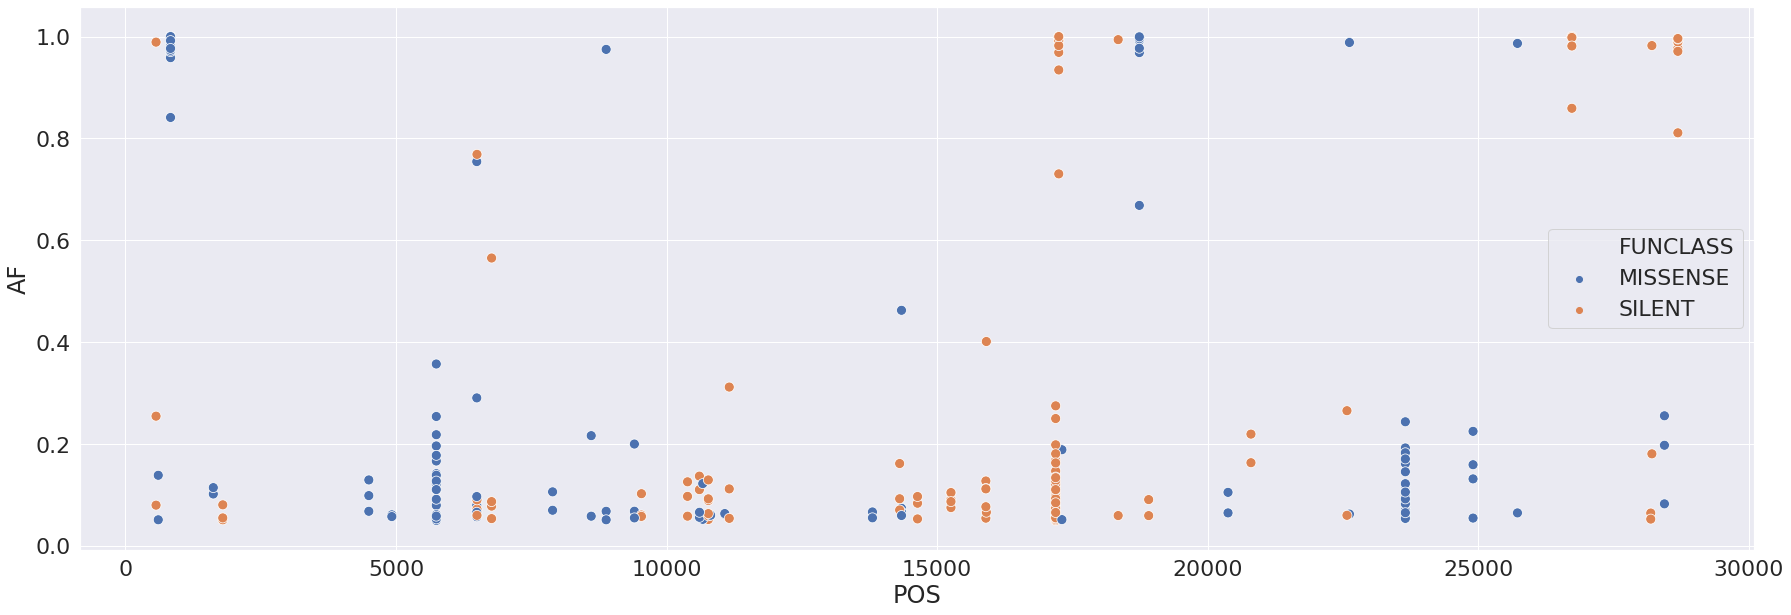

In [118]:
plt.figure(figsize=(30,10))
sns.scatterplot(x='POS',y='AF',data=va[  ( va['POS'].isin(tc[tc['N']<100]['POS'].to_numpy()) ) & (va['change']=='TC')],s=100,hue='FUNCLASS')

In [119]:
pysqldf('select count(POS) from va where Studies > 1 ')

count(POS)
0        7031

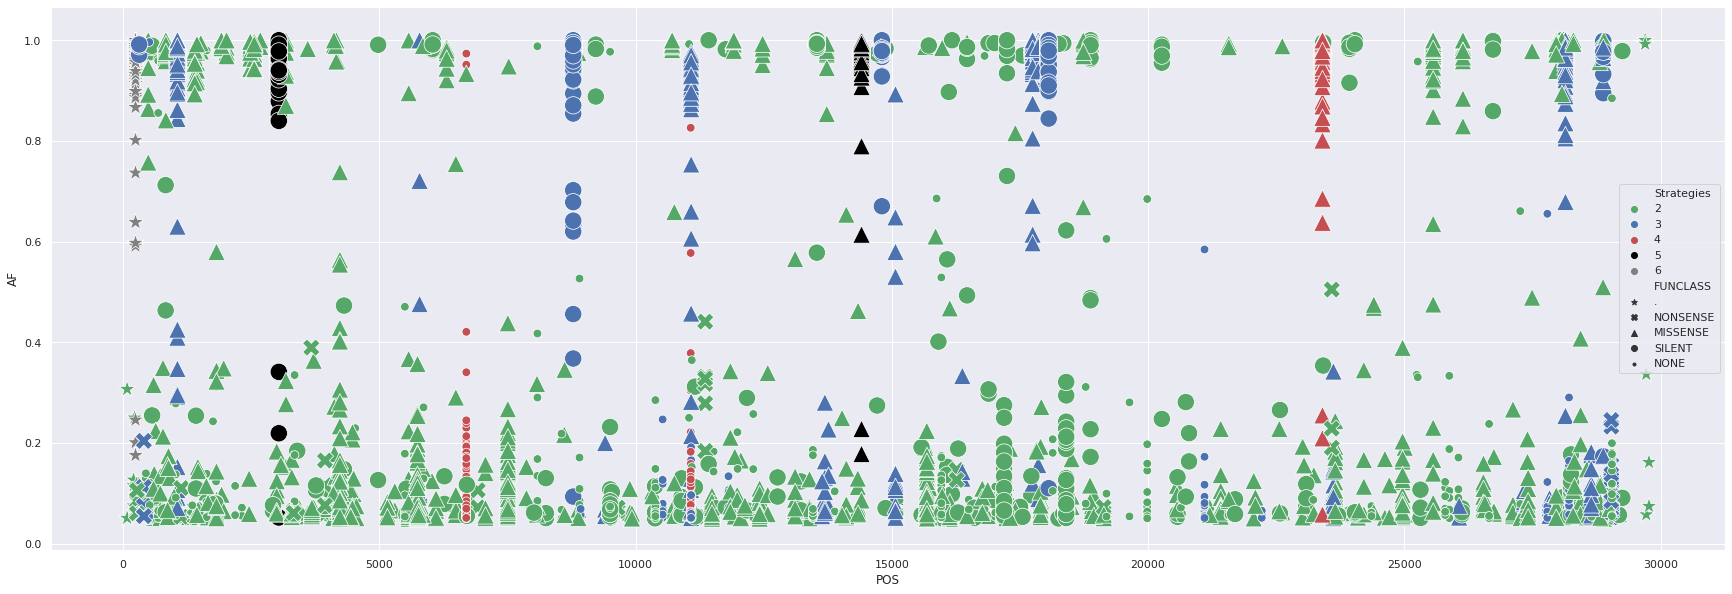

In [121]:
sns.set(font_scale=1)
plt.figure(figsize=(30,10))
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}
sns.scatterplot(x='POS',y='AF',data=va[va['Strategies']>=2],hue='Strategies',markers=markers,style='FUNCLASS',s=300,palette={2:'g',3:'b',4:'r',5:'black',6:'grey'})

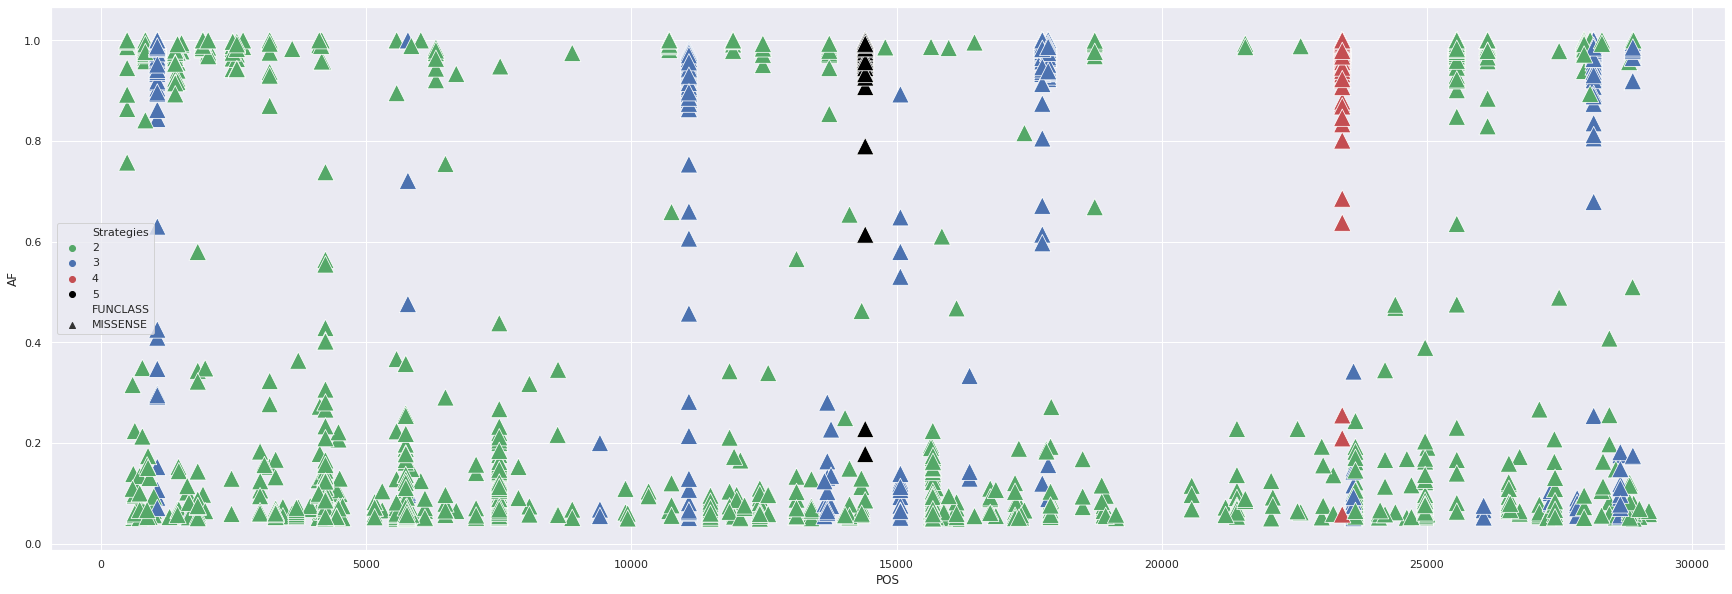

In [122]:
sns.set(font_scale=1)
plt.figure(figsize=(30,10))
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}
sns.scatterplot(x='POS',y='AF',data=va[(va['Strategies']>=2) & (va['FUNCLASS']=='MISSENSE')],hue='Strategies',markers=markers,style='FUNCLASS',s=300,palette={2:'g',3:'b',4:'r',5:'black'})

In [123]:
pysqldf('select POS, change,FUNCLASS,IMPACT,GENE,CODON,type,func,Samples, Studies, Strategies, min(AF) as min,max(AF) as max,avg(AF) as mean from va where Strategies>=2 and FUNCLASS = "MISSENSE" group by pos,change order by max-min desc')

POS change  FUNCLASS    IMPACT    GENE    CODON         type      func  \
0    27964     CT  MISSENSE  MODERATE    ORF8  tCa/tTa          CDS      orf8   
1    23403     AG  MISSENSE  MODERATE       S  gAt/gGt          CDS         S   
2    16468     CT  MISSENSE  MODERATE  orf1ab  Ccc/Tcc  mat_peptide  helicase   
3     1440     GA  MISSENSE  MODERATE  orf1ab  gGc/gAc  mat_peptide      nsp2   
4      872     GT  MISSENSE  MODERATE  orf1ab  Gac/Tac  mat_peptide      nsp2   
5    25563     GT  MISSENSE  MODERATE   ORF3a  caG/caT          CDS     orf3a   
6    10712     CT  MISSENSE  MODERATE  orf1ab  Ctc/Ttc  mat_peptide     3Cpro   
7    11083     GT  MISSENSE  MODERATE  orf1ab  ttG/ttT  mat_peptide      nsp6   
8     1059     CT  MISSENSE  MODERATE  orf1ab  aCc/aTc  mat_peptide      nsp2   
9    22619     TC  MISSENSE  MODERATE       S  Tgg/Cgg          CDS         S   
10    8883     TC  MISSENSE  MODERATE  orf1ab  aTa/aCa  mat_peptide      nsp4   
11    5849     CT  MISSENSE  MODERATE  orf1ab  Cct/Tct  mat_peptide      nsp3   
12    3602     CT  MISSENSE  MODERATE  orf1ab  Cac/Tac  mat_peptide      nsp3   
13   17858     AG  MISSENSE  MODERATE  orf1ab  tAt/tGt  mat_peptide  helicase   
14   21575     CT  MISSENSE  MODERATE       S  Ctt/Ttt          CDS         S   
15    5784     CT  MISSENSE  MODERATE  orf1ab  aCt/aTt  mat_peptide      nsp3   
16    4185     GT  MISSENSE  MODERATE  orf1ab  gGt/gTt  mat_peptide      nsp3   
17   14407     CT  MISSENSE  MODERATE  orf1ab  Cct/Tct  mat_peptide      RdRp   
18   15982     GT  MISSENSE  MODERATE  orf1ab  Gta/Tta  mat_peptide      RdRp   
19   17747     CT  MISSENSE  MODERATE  orf1ab  cCt/cTt  mat_peptide  helicase   
20    6027     CT  MISSENSE  MODERATE  orf1ab  cCa/cTa  mat_peptide      nsp3   
21   28812     GT  MISSENSE  MODERATE       N  aGt/aTt          CDS         N   
22    7524     GT  MISSENSE  MODERATE  orf1ab  aGa/aTa  mat_peptide      nsp3   
23    6696     CT  MISSENSE  MODERATE  orf1ab  cCt/cTt  mat_peptide      nsp3   
24    4148     GT  MISSENSE  MODERATE  orf1ab  Gtt/Ttt  mat_peptide      nsp3   
25    3177     CT  MISSENSE  MODERATE  orf1ab  cCt/cTt  mat_peptide      nsp3   
26   15071     TA  MISSENSE  MODERATE  orf1ab  cTt/cAt  mat_peptide      RdRp   
27     884     CT  MISSENSE  MODERATE  orf1ab  Cgt/Tgt  mat_peptide      nsp2   
28   28881     GA  MISSENSE  MODERATE       N  aGg/aAg          CDS         N   
29   28883     GC  MISSENSE  MODERATE       N  Gga/Cga          CDS         N   
30   14408     CT  MISSENSE  MODERATE  orf1ab  cCt/cTt  mat_peptide      RdRp   
31   15649     GT  MISSENSE  MODERATE  orf1ab  Gtt/Ttt  mat_peptide      RdRp   
32   17410     CT  MISSENSE  MODERATE  orf1ab  Cgt/Tgt  mat_peptide  helicase   
33   28144     TC  MISSENSE  MODERATE    ORF8  tTa/tCa          CDS      orf8   
34    6492     TC  MISSENSE  MODERATE  orf1ab  aTa/aCa  mat_peptide      nsp3   
35    4229     AC  MISSENSE  MODERATE  orf1ab  Aca/Cca  mat_peptide      nsp3   
36   10755     CT  MISSENSE  MODERATE  orf1ab  gCt/gTt  mat_peptide     3Cpro   
37   14111     AC  MISSENSE  MODERATE  orf1ab  cAa/cCa  mat_peptide      RdRp   
38   15853     CT  MISSENSE  MODERATE  orf1ab  Ctt/Ttt  mat_peptide      RdRp   
39    1821     GA  MISSENSE  MODERATE  orf1ab  gGt/gAt  mat_peptide      nsp2   
40   13112     TA  MISSENSE  MODERATE  orf1ab  Tat/Aat  mat_peptide     nsp10   
41   28878     GA  MISSENSE  MODERATE       N  aGt/aAt          CDS         N   
42   27493     CT  MISSENSE  MODERATE   ORF7a  Cct/Tct          CDS     orf7a   
43   16130     GA  MISSENSE  MODERATE  orf1ab  gGa/gAa  mat_peptide      RdRp   
44   24404     CT  MISSENSE  MODERATE       S  Ctt/Ttt          CDS         S   
45   14341     TC  MISSENSE  MODERATE  orf1ab  Tgt/Cgt  mat_peptide      RdRp   
46    7507     AC  MISSENSE  MODERATE  orf1ab  aaA/aaC  mat_peptide      nsp3   
47   28440     TA  MISSENSE  MODERATE       N  cTc/cAc          CDS         N   
48   24966     AT  MISSENSE  MODERATE 

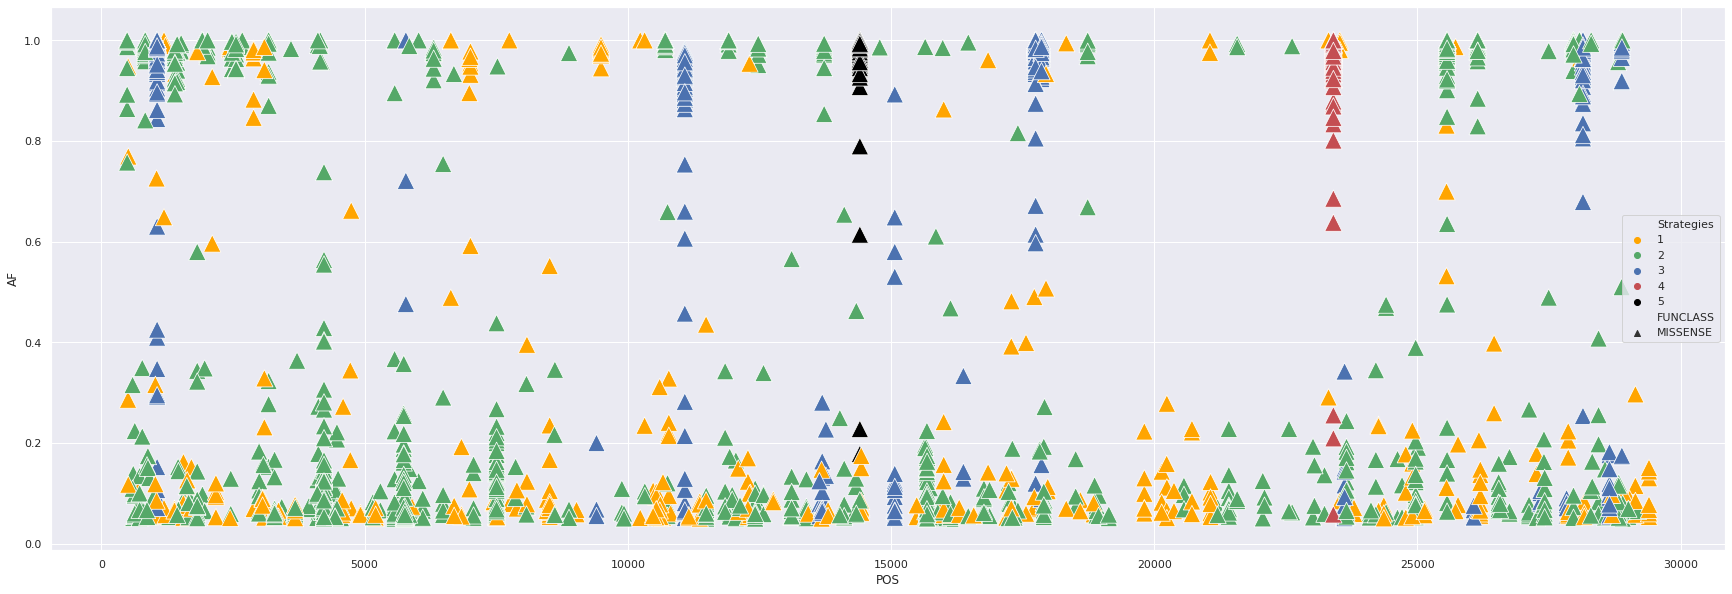

In [124]:
sns.set(font_scale=1)
plt.figure(figsize=(30,10))
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}
sns.scatterplot(x='POS',y='AF',data=va[(va['Studies']>=2) & (va['FUNCLASS']=='MISSENSE')],hue='Strategies',markers=markers,style='FUNCLASS',s=300,palette={1:'orange',2:'g',3:'b',4:'r',5:'black'})

In [125]:
va['library_strategy'].unique()

array(['AMPLICON', 'RNA-Seq', 'Targeted-Capture', 'WGS', 'OTHER', 'WGA'],
      dtype=object)

## Interesting sites

In [126]:
pysqldf('select * from va limit10 ')

Sample    POS REF ALT    DP        AF  SB            DP4 IMPACT  \
0     SRR11772222    241   C   T  1205  0.991701   0    0,0,589,614      .   
1     SRR11607614    241   C   T  1433  0.985345   0    0,0,613,816      .   
2     SRR11858001    241   C   T   966  0.998965   0    0,1,459,506      .   
3     SRR11607659     61   G   T   716  0.054469   0   554,122,34,6      .   
4     SRR11607659    241   C   T  3000  0.986333   0  0,0,1355,1643      .   
...           ...    ...  ..  ..   ...       ...  ..            ...    ...   
7026  SRR11851957  13536   C   T   798  0.984962   7    2,1,200,595    LOW   
7027  SRR11851956  13536   C   T   727  0.994498   0    0,0,238,489    LOW   
7028  SRR11851949  13536   C   T  1795  0.994429   0   0,1,567,1225    LOW   
7029  SRR11851955  13536   C   T   352  0.988636   0    0,0,113,239    LOW   
7030  SRR11851953  13536   C   T  1832  0.992904   0   0,0,707,1124    LOW   

     FUNCLASS             EFFECT    GENE    CODON change study_accession  \
0           .                  .       .        .     CT       SRP256957   
1           .                  .       .        .     CT       SRP253926   
2           .                  .       .        .     CT       SRP256957   
3           .                  .       .        .     GT       SRP253926   
4           .                  .       .        .     CT       SRP253926   
...       ...                ...     ...      ...    ...             ...   
7026   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT       SRP253926   
7027   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT       SRP253926   
7028   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT       SRP253926   
7029   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT       SRP253926   
7030   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT       SRP253926   

     library_strategy library_source library_selection collection_date  \
0            AMPLICON      VIRAL RNA              cDNA         2020-04   
1            AMPLICON      VIRAL RNA               PCR            None   
2            AMPLICON      VIRAL RNA              cDNA         2020-04   
3            AMPLICON      VIRAL RNA               PCR            None   
4            AMPLICON      VIRAL RNA               PCR            None   
...               ...            ...               ...             ...   
7026         AMPLICON      VIRAL RNA               PCR            None   
7027         AMPLICON      VIRAL RNA               PCR            None   
7028         AMPLICON      VIRAL RNA               PCR            None   
7029         AMPLICON      VIRAL RNA               PCR            None   
7030         AMPLICON      VIRAL RNA               PCR            None   

       geo_loc_name   type func  start    end   A   C   G   T  Samples  \
0      USA:Virginia  5'UTR    .      0    265  67  63  55  80      608   
1              None  5'UTR    .      0    265  67  63  55  80      608   
2     USA: Virginia  5'UTR    .      0    265  67  63  55  80      608   
3              None  5'UTR    .      0    265  67  63  55  80        3   
4              None  5'UTR    .      0    265  67  63  55  80      608   
...             ...    ...  ...    ...    ...  ..  ..  ..  ..      ...   
7026           None   stem  S2b  13535  13542   1   2   3   1       14   
7027           None   stem  S2b  13535  13542   1   2   3   1       14   
7028           None   stem  S2b  13535  13542   1   2   3   1       14   
7029           None   stem  S2b  13535  13542   1   2   3   1       14   
7030           None   stem  S2b  13535  13542   1   2   3   1       14   

      Studies  Strategies   up down  mid left right  
0          16           6  TTC  CGT  TCG    T     G  
1          16           6  TTC  CGT  TCG    T     G  
2          16           6  TTC  CGT  TCG    T     G  
3           3           1  CTG  GTT  TGT    T     T  
4          16           6  TTC  CGT  TCG    T     G  
...       ...         ...  ...  ...  ...  ...   ...  
7026 

In [127]:
a = pysqldf('select POS, change, min(AF) as minAF, max(AF) as maxAF from va group by POS, change')
va = pysqldf('select va.*, minAF, maxAF, maxAF-minAF as rangeAF from va left join a on va.POS = a.POS and va.change = a.change')

In [128]:
va

Sample    POS REF ALT    DP        AF  SB            DP4 IMPACT  \
0     SRR11772222    241   C   T  1205  0.991701   0    0,0,589,614      .   
1     SRR11607614    241   C   T  1433  0.985345   0    0,0,613,816      .   
2     SRR11858001    241   C   T   966  0.998965   0    0,1,459,506      .   
3     SRR11607659     61   G   T   716  0.054469   0   554,122,34,6      .   
4     SRR11607659    241   C   T  3000  0.986333   0  0,0,1355,1643      .   
...           ...    ...  ..  ..   ...       ...  ..            ...    ...   
7026  SRR11851957  13536   C   T   798  0.984962   7    2,1,200,595    LOW   
7027  SRR11851956  13536   C   T   727  0.994498   0    0,0,238,489    LOW   
7028  SRR11851949  13536   C   T  1795  0.994429   0   0,1,567,1225    LOW   
7029  SRR11851955  13536   C   T   352  0.988636   0    0,0,113,239    LOW   
7030  SRR11851953  13536   C   T  1832  0.992904   0   0,0,707,1124    LOW   

     FUNCLASS             EFFECT    GENE    CODON change study_accession  \
0           .                  .       .        .     CT       SRP256957   
1           .                  .       .        .     CT       SRP253926   
2           .                  .       .        .     CT       SRP256957   
3           .                  .       .        .     GT       SRP253926   
4           .                  .       .        .     CT       SRP253926   
...       ...                ...     ...      ...    ...             ...   
7026   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT       SRP253926   
7027   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT       SRP253926   
7028   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT       SRP253926   
7029   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT       SRP253926   
7030   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT       SRP253926   

     library_strategy library_source library_selection collection_date  \
0            AMPLICON      VIRAL RNA              cDNA         2020-04   
1            AMPLICON      VIRAL RNA               PCR            None   
2            AMPLICON      VIRAL RNA              cDNA         2020-04   
3            AMPLICON      VIRAL RNA               PCR            None   
4            AMPLICON      VIRAL RNA               PCR            None   
...               ...            ...               ...             ...   
7026         AMPLICON      VIRAL RNA               PCR            None   
7027         AMPLICON      VIRAL RNA               PCR            None   
7028         AMPLICON      VIRAL RNA               PCR            None   
7029         AMPLICON      VIRAL RNA               PCR            None   
7030         AMPLICON      VIRAL RNA               PCR            None   

       geo_loc_name   type func  start    end   A   C   G   T  Samples  \
0      USA:Virginia  5'UTR    .      0    265  67  63  55  80      608   
1              None  5'UTR    .      0    265  67  63  55  80      608   
2     USA: Virginia  5'UTR    .      0    265  67  63  55  80      608   
3              None  5'UTR    .      0    265  67  63  55  80        3   
4              None  5'UTR    .      0    265  67  63  55  80      608   
...             ...    ...  ...    ...    ...  ..  ..  ..  ..      ...   
7026           None   stem  S2b  13535  13542   1   2   3   1       14   
7027           None   stem  S2b  13535  13542   1   2   3   1       14   
7028           None   stem  S2b  13535  13542   1   2   3   1       14   
7029           None   stem  S2b  13535  13542   1   2   3   1       14   
7030           None   stem  S2b  13535  13542   1   2   3   1       14   

      Studies  Strategies   up down  mid left right     minAF     maxAF  \
0          16           6  TTC  CGT  TCG    T     G  0.175439  1.000000   
1          16           6  TTC  CGT  TCG    T     G  0.175439  1.000000   
2          16           6  TTC  CGT  TCG    T     G  0.175439  1.000000   
3           3           1  CTG  GTT  TGT    T     T  0.054469  0.143357   
4       

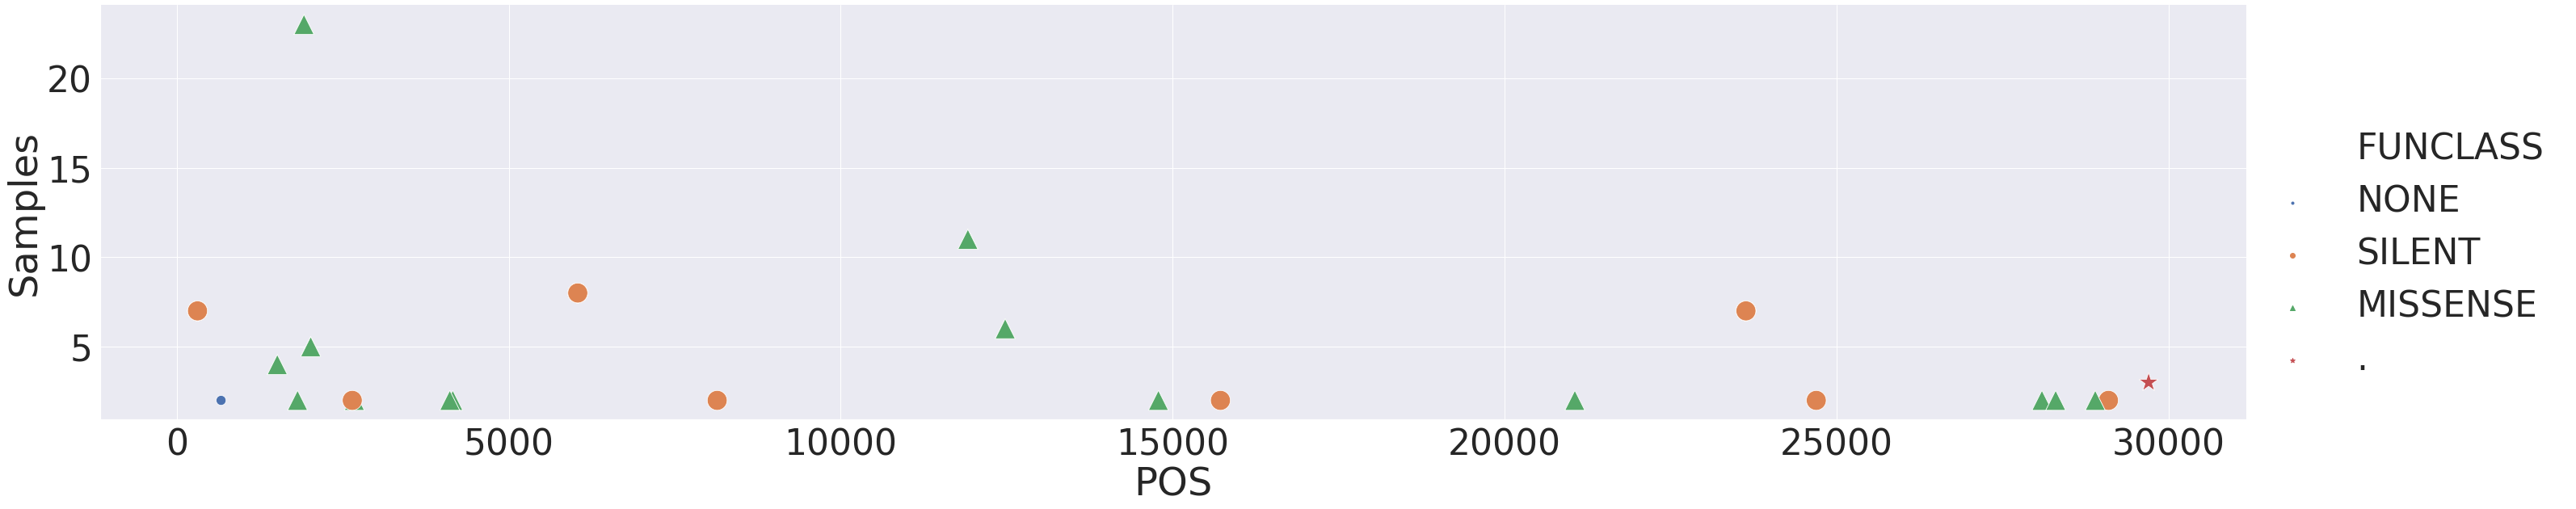

In [129]:
sns.set(font_scale=4)
sns.relplot(x='POS',y='Samples',data=pysqldf('select * from va where minAF >= 0.95'),height=10,aspect=4,s=600,style='FUNCLASS',hue='FUNCLASS',markers=markers)

In [130]:
pysqldf('select POS, change, FUNCLASS, GENE, CODON, func, library_strategy, Samples, Studies, Strategies, minAF, maxAF from va where minAF >= 0.95 group by POS, change')

POS change  FUNCLASS    GENE       CODON    func library_strategy  \
0     313     CT    SILENT  orf1ab     ctC/ctT  leader          RNA-Seq   
1     668  AGTTA      NONE  orf1ab  agttac/aac  leader         AMPLICON   
2    1515     AG  MISSENSE  orf1ab     cAt/cGt    nsp2         AMPLICON   
3    1820     GA  MISSENSE  orf1ab     Ggt/Agt    nsp2         AMPLICON   
4    1917     CT  MISSENSE  orf1ab     aCt/aTt    nsp2         AMPLICON   
5    2018     AG  MISSENSE  orf1ab     Atg/Gtg    nsp2         AMPLICON   
6    2644     CT    SILENT  orf1ab     atC/atT    nsp2         AMPLICON   
7    2676     CT  MISSENSE  orf1ab     cCt/cTt    nsp2         AMPLICON   
8    4113     CT  MISSENSE  orf1ab     gCt/gTt    nsp3          RNA-Seq   
9    4158     CT  MISSENSE  orf1ab     gCt/gTt    nsp3          RNA-Seq   
10   6040     CT    SILENT  orf1ab     ttC/ttT    nsp3         AMPLICON   
11   8140     CT    SILENT  orf1ab     tcC/tcT    nsp3         AMPLICON   
12  11916     CT  MISSENSE  orf1ab     tCa/tTa    nsp7         AMPLICON   
13  12478     GA  MISSENSE  orf1ab     atG/atA    nsp8          RNA-Seq   
14  14786     CT  MISSENSE  orf1ab     gCt/gTt    RdRp         AMPLICON   
15  15720     CT    SILENT  orf1ab     gaC/gaT    RdRp         AMPLICON   
16  21058     CT  MISSENSE  orf1ab     Cct/Tct  MethTr         AMPLICON   
17  23635     CT    SILENT       S     tcC/tcT       S         AMPLICON   
18  24694     AT    SILENT       S     ggA/ggT       S         AMPLICON   
19  28093     CT  MISSENSE    ORF8     tCt/tTt    orf8          RNA-Seq   
20  28300     GT  MISSENSE       N     caG/caT       N         AMPLICON   
21  28896     CG  MISSENSE       N     gCt/gGt       N         AMPLICON   
22  29095     CT    SILENT       N     ttC/ttT       N         AMPLICON   
23  29700     AG         .       .           .       .         AMPLICON   

    Samples  Studies  Strategies     minAF     maxAF  
0         7        4           3  0.971171  0.992308  
1         2        2           2  0.962963  0.989964  
2         4        2           2  0.978102  0.994297  
3         2        2           1  0.976555  0.979665  
4        23        2           2  0.981848  1.000000  
5         5        2           2  0.968472  1.000000  
6         2        2           1  0.988082  0.993884  
7         2        2           2  0.986997  1.000000  
8         2        2           2  0.990476  1.000000  
9         2        2           2  0.958042  1.000000  
10        8        3           2  0.980263  1.000000  
11        2        2           1  0.981132  0.994169  
12       11        2           2  0.979310  1.000000  
13        6        3           2  0.950980  0.993151  
14        2        2           2  0.984834  0.986111  
15        2        2           2  0.988823  0.989529  
16        2        2           1  0.975288  1.000000  
17        7        2           1  0.964286  1.000000  
18        2        2           1  0.974312  0.981763  
19        2        2           1  0.964286  0.991453  
20        2        2           2  0.993151  1.000000  
21        2        2           2  0.996979  1.000000  
22        2        2           1  0.961905  0.987571  
23        3        2           2  0.992481  1.000000

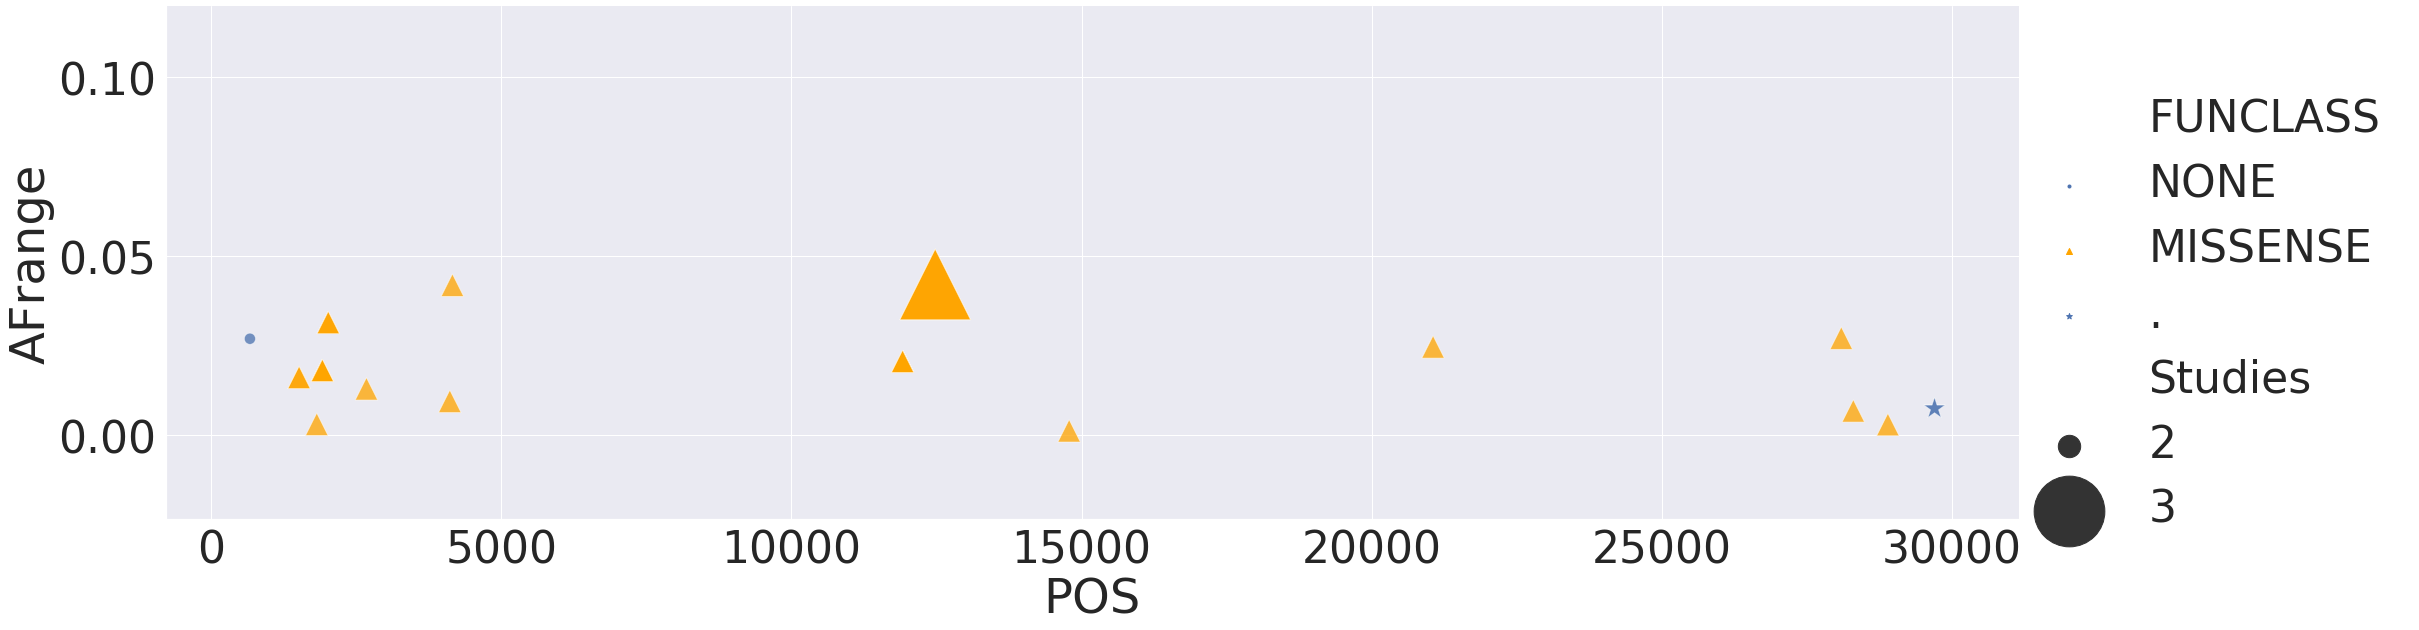

In [131]:
sns.relplot(x='POS',y='AFrange',data=pysqldf('select *, maxAF-minAF as AFrange from va where minAF >= 0.95 and FUNCLASS != "SILENT"'),height=10,aspect=3,size="Studies",sizes=(500,5000),style='FUNCLASS',alpha=0.5,hue='FUNCLASS',palette=fc_palette,markers=markers)

<Figure size 2160x720 with 0 Axes>

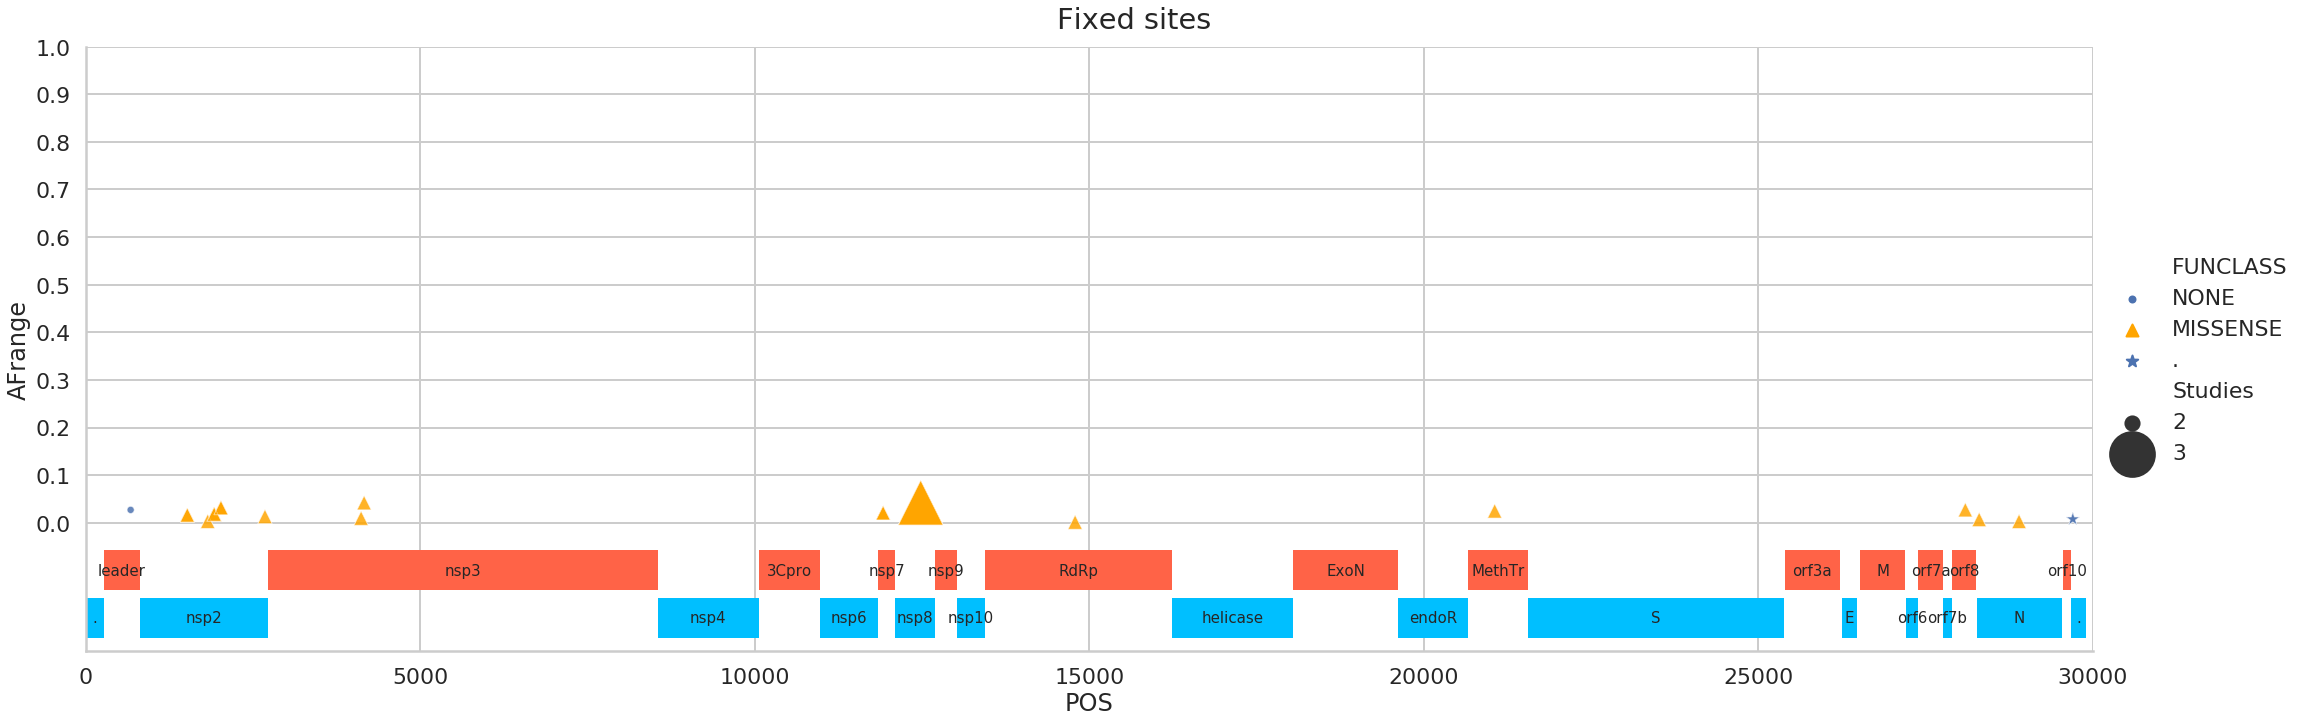

In [132]:
minimap(pysqldf('select *, maxAF-minAF as AFrange from va where minAF >= 0.95 and FUNCLASS != "SILENT"'),'POS','AFrange',annot[annot['L']>100],'Studies','FUNCLASS','FUNCLASS','Fixed sites')

In [133]:
print(pysqldf('select POS, change, FUNCLASS, func, Samples, Studies, Strategies, maxAF-minAF as AFrange from va where minAF >= 0.95 and FUNCLASS != "SILENT" group by POS, change order by POS').to_markdown())

|    |   POS | change   | FUNCLASS   | func   |   Samples |   Studies |   Strategies |   AFrange |
|---:|------:|:---------|:-----------|:-------|----------:|----------:|-------------:|----------:|
|  0 |   668 | AGTTA    | NONE       | leader |         2 |         2 |            2 |  0.027001 |
|  1 |  1515 | AG       | MISSENSE   | nsp2   |         4 |         2 |            2 |  0.016195 |
|  2 |  1820 | GA       | MISSENSE   | nsp2   |         2 |         2 |            1 |  0.00311  |
|  3 |  1917 | CT       | MISSENSE   | nsp2   |        23 |         2 |            2 |  0.018152 |
|  4 |  2018 | AG       | MISSENSE   | nsp2   |         5 |         2 |            2 |  0.031528 |
|  5 |  2676 | CT       | MISSENSE   | nsp2   |         2 |         2 |            2 |  0.013003 |
|  6 |  4113 | CT       | MISSENSE   | nsp3   |         2 |         2 |            2 |  0.009524 |
|  7 |  4158 | CT       | MISSENSE   | nsp3   |         2 |         2 |            2 |  0.041958 |
|  8 | 119

In [134]:
pysqldf('select distinct library_strategy from va').to_numpy()

array([['AMPLICON'],
       ['RNA-Seq'],
       ['Targeted-Capture'],
       ['WGS'],
       ['OTHER'],
       ['WGA']], dtype=object)

<Figure size 2160x720 with 0 Axes>

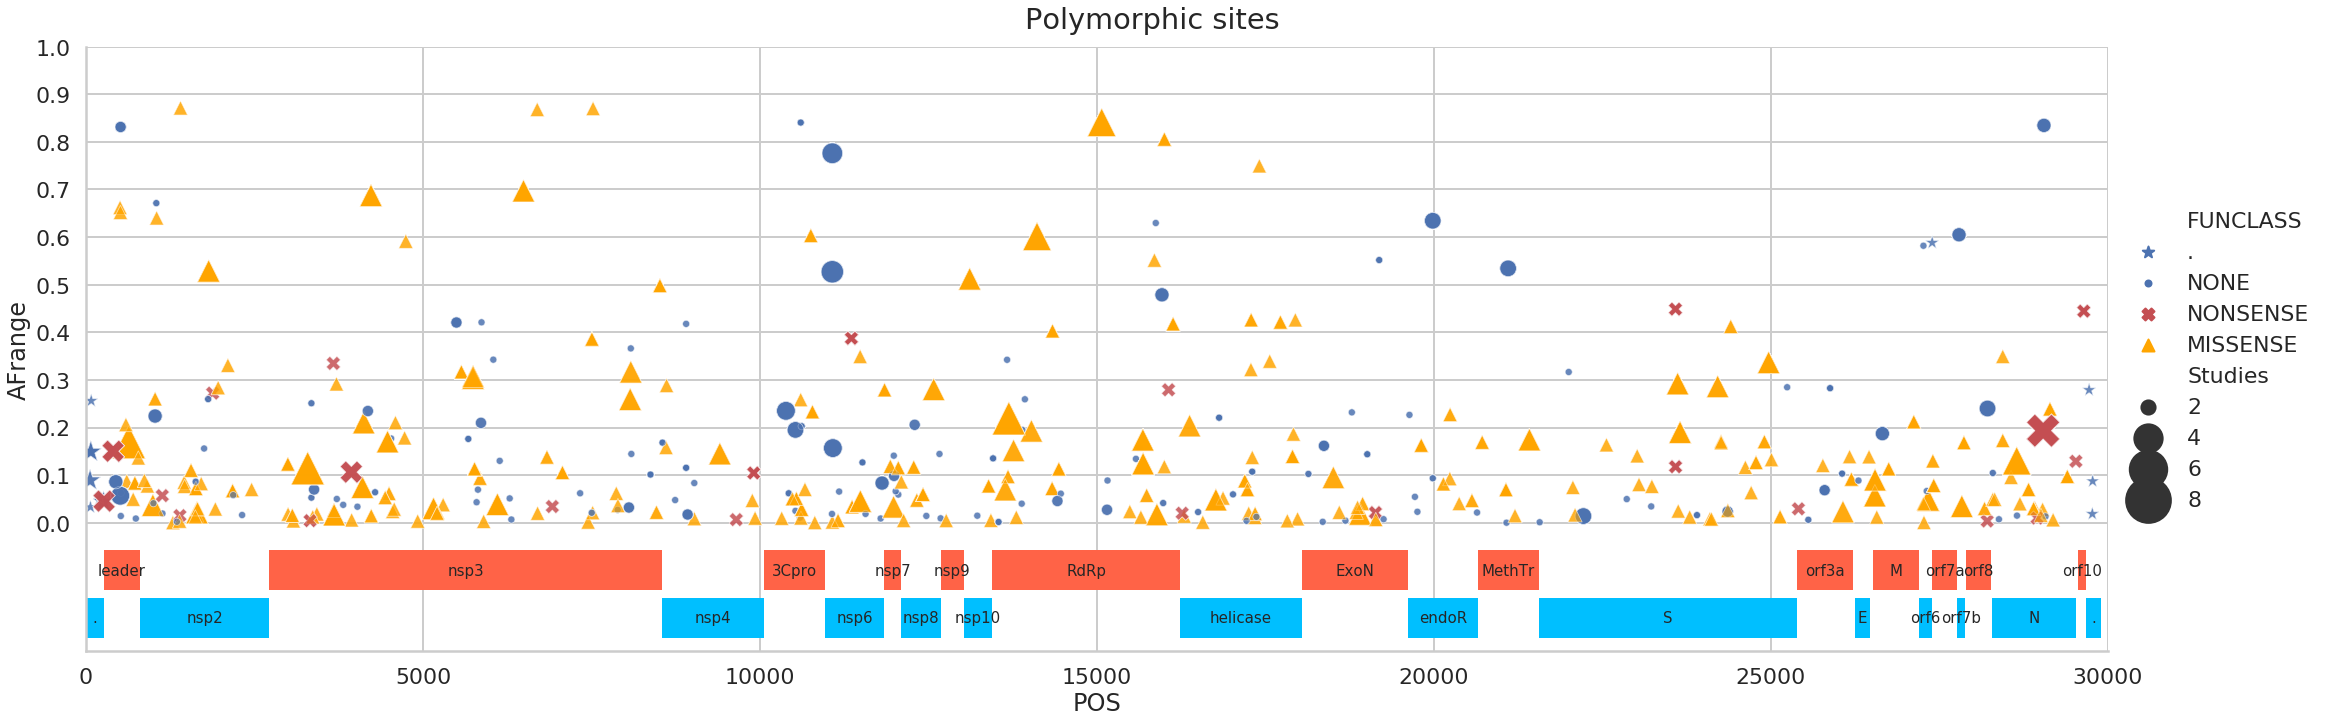

In [135]:
minimap(pysqldf('select *, maxAF-minAF as AFrange from va where maxAF < 0.95 and FUNCLASS != "SILENT"'),'POS','AFrange',annot[annot['L']>100],'Studies','FUNCLASS','FUNCLASS', 'Polymorphic sites')

In [136]:
print(pysqldf('select POS, change, FUNCLASS, func, Samples, Studies, Strategies, maxAF-minAF as AFrange from va where maxAF < 0.95 and FUNCLASS != "SILENT" and Studies > 2 group by POS, change order by POS').to_markdown())

|    |   POS | change           | FUNCLASS   | func     |   Samples |   Studies |   Strategies |   AFrange |
|---:|------:|:-----------------|:-----------|:---------|----------:|----------:|-------------:|----------:|
|  0 |    61 | GT               | .          | .        |         3 |         3 |            1 |  0.088888 |
|  1 |    72 | GA               | .          | .        |         9 |         3 |            1 |  0.149044 |
|  2 |   261 | GT               | .          | .        |         3 |         3 |            2 |  0.043447 |
|  3 |   269 | GT               | NONSENSE   | leader   |         4 |         3 |            2 |  0.045379 |
|  4 |   404 | AT               | NONSENSE   | leader   |        10 |         3 |            3 |  0.150191 |
|  5 |   443 | GTG              | NONE       | leader   |         5 |         4 |            2 |  0.086103 |
|  6 |   509 | GGTCATGTTATGGTTG | NONE       | leader   |         8 |         6 |            1 |  0.05668  |
|  7 |   514 | TGTT

In [137]:
pysqldf('select * from va where POS = 29039')

Sample    POS REF ALT    DP        AF   SB             DP4 IMPACT  \
0   SRR11059942  29039   A   T   327  0.232416    4   129,122,34,42   HIGH   
1   SRR11813140  29039   A   T  1167  0.054841   17   669,433,49,16   HIGH   
2   SRR11780050  29039   A   T   129  0.093023   20      53,63,11,2   HIGH   
3   SRR11772061  29039   A   T   151  0.086093   10       59,79,9,4   HIGH   
4   SRR11771998  29039   A   T   106  0.122642   14      39,54,10,3   HIGH   
5   SRR11780051  29039   A   T   101  0.069307   13       41,53,6,1   HIGH   
6   SRR11772064  29039   A   T   151  0.052980    3       63,80,5,3   HIGH   
7   SRR11241255  29039   A   T   189  0.095238   57     142,28,5,13   HIGH   
8   SRR11621871  29039   A   T   232  0.064655   18    111,105,13,2   HIGH   
9   SRR11247076  29039   A   T   132  0.090909   26      107,13,6,6   HIGH   
10  SRR11772059  29039   A   T   141  0.070922    7       59,72,7,3   HIGH   
11  SRR11786918  29039   A   T   217  0.156682   16     89,94,24,10   HIGH   
12  SRR11780046  29039   A   T   143  0.062937   23       70,64,9,0   HIGH   
13  SRR11786914  29039   A   T   730  0.124658    4   271,365,44,48   HIGH   
14  SRR11780027  29039   A   T   111  0.063063    9       52,52,6,1   HIGH   
15  SRR11786915  29039   A   T   920  0.131522   56   291,505,72,49   HIGH   
16  SRR11780087  29039   A   T   102  0.068627   26       42,52,8,0   HIGH   
17  SRR11780007  29039   A   T   115  0.052174    5       50,58,5,2   HIGH   
18  SRR11621842  29039   A   T   118  0.067797   15       50,60,7,1   HIGH   
19  SRR11780062  29039   A   T   147  0.061224   14       69,69,8,1   HIGH   
20  SRR11780107  29039   A   T   158  0.063291   16       75,73,9,1   HIGH   
21  SRR11621870  29039   A   T   224  0.066964    9    102,107,11,4   HIGH   
22  SRR11813142  29039   A   T   568  0.061620    7    384,148,30,6   HIGH   
23  SRR11772065  29039   A   T   150  0.060000   14       73,68,8,1   HIGH   
24  SRR11780077  29039   A   T   101  0.099010   23       37,54,9,1   HIGH   
25  SRR11780032  29039   A   T   189  0.095238   43      85,82,20,1   HIGH   
26  SRR11786916  29039   A   T   169  0.082840   13      74,81,11,3   HIGH   
27  SRR11772046  29039   A   T   167  0.065868    1       71,85,4,7   HIGH   
28  SRR11621828  29039   A   T   358  0.103352   16    177,144,28,9   HIGH   
29  SRR11859163  29039   A   T   305  0.085246   31    117,162,20,6   HIGH   
30  SRR11786913  29039   A   T   305  0.098361    1   127,146,16,15   HIGH   
31  SRR11772051  29039   A   T   159  0.106918   11      56,86,11,6   HIGH   
32  SRR11621901  29039   A   T   208  0.057692    8       99,97,9,3   HIGH   
33  SRR11772057  29039   A   T   207  0.067633   29     51,141,10,4   HIGH   
34  SRR11772020  29039   A   T   146  0.095890   10       52,79,9,5   HIGH   
35  SRR11621843  29039   A   T   125  0.080000   26      59,55,10,0   HIGH   
36  SRR11780010  29039   A   T   100  0.090000   10       42,49,7,2   HIGH   
37  SRR11813127  29039   A   T   848  0.073113   14    582,202,55,9   HIGH   
38  SRR11780011  29039   A   T   143  0.132867    8      62,62,13,6   HIGH   
39  SRR11772062  29039   A   T   105  0.095238    0       43,52,5,5   HIGH   
40  SRR11780059  29039   A   T   202  0.074257   29      98,88,15,1   HIGH   
41  SRR11780025  29039   A   T   125  0.088000   23      52,62,10,1   HIGH   
42  SRR11780080  29039   A   T   163  0.128834   35      70,72,19,2   HIGH   
43  SRR11780060  29039   A   T   128  0.062500   21       58,62,8,0   HIGH   
44  SRR11780024  29039   A   T   283  0.137809   11   120,122,27,14   HIGH   
45  SRR11780099  29039   A   T   160  0.068750    6       73,76,8,3   HIGH   
46  SRR11783615  29039   A   T  1075  0.245581  365  533,265,63,212   HIGH   
47  SRR11780070  29039   A   T   142  0.084507   21      68,61,12,1   HIGH   

    FUNCLASS       EFFECT GENE    CODON change study_accession  \
0   NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP248092   
1   NONSENSE  STOP_GAINED    N  Aag/Tag     AT       S

<Figure size 2160x720 with 0 Axes>

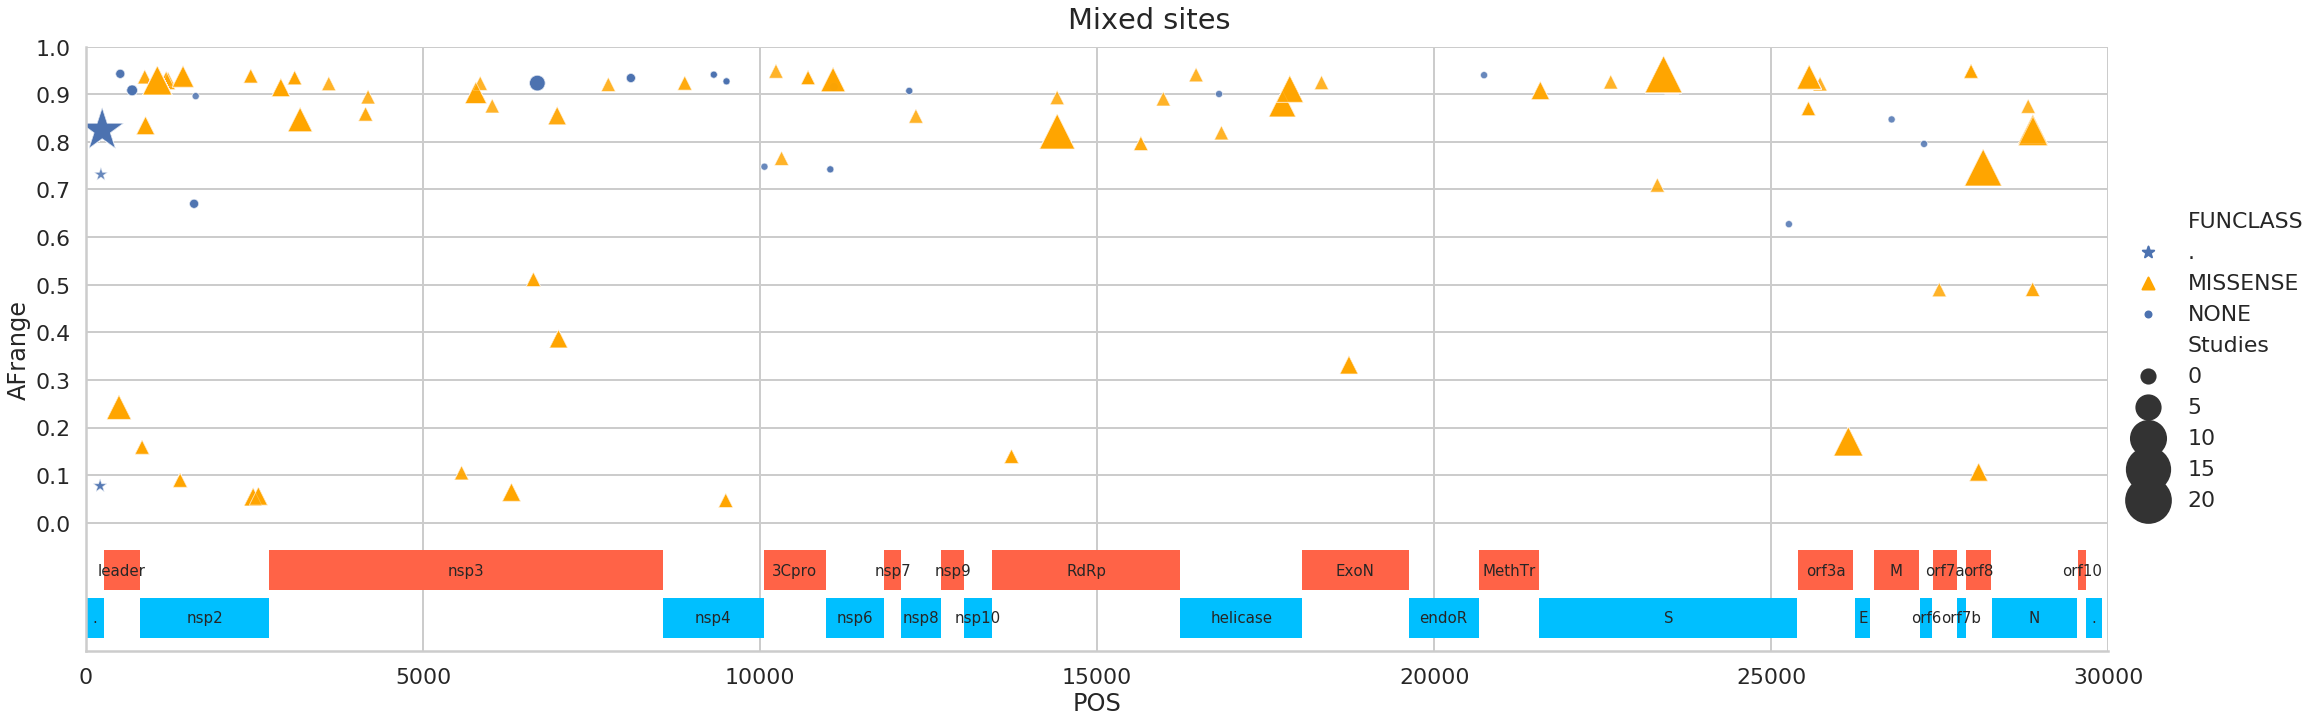

In [138]:
minimap(pysqldf('select *, maxAF-minAF as AFrange from va where maxAF >= 0.95 and minAF < 0.95 and FUNCLASS != "SILENT"'),'POS','AFrange',annot[annot['L']>100],'Studies','FUNCLASS','FUNCLASS', 'Mixed sites')

In [139]:
print(pysqldf('select POS, change, FUNCLASS, GENE, func, Samples, Studies, Strategies, maxAF-minAF as AFrange from va where maxAF >= 0.95 and minAF < 0.95 and FUNCLASS != "SILENT" and Studies > 2 group by POS, change order by POS').to_markdown())

|    |   POS | change      | FUNCLASS   | GENE   | func     |   Samples |   Studies |   Strategies |   AFrange |
|---:|------:|:------------|:-----------|:-------|:---------|----------:|----------:|-------------:|----------:|
|  0 |   241 | CT          | .          | .      | .        |       608 |        16 |            6 |  0.824561 |
|  1 |   490 | TA          | MISSENSE   | orf1ab | leader   |        11 |         5 |            2 |  0.242644 |
|  2 |   509 | GGTCATGTTAG | NONE       | orf1ab | leader   |         4 |         3 |            3 |  0.942891 |
|  3 |   685 | AAAGTCATTTA | NONE       | orf1ab | leader   |         8 |         4 |            2 |  0.908223 |
|  4 |   884 | CT          | MISSENSE   | orf1ab | nsp2     |         7 |         3 |            2 |  0.834313 |
|  5 |  1059 | CT          | MISSENSE   | orf1ab | nsp2     |       355 |         7 |            3 |  0.929015 |
|  6 |  1190 | CT          | MISSENSE   | orf1ab | nsp2     |         3 |         3 |           

In [140]:
pysqldf('select distinct study_accession from va where maxAF >= 0.95 and minAF < 0.95 and FUNCLASS != "SILENT" and Studies > 2 ')['study_accession'].to_list()

['SRP256957',
 'SRP253926',
 'SRP251618',
 'ERP121228',
 'SRP262661',
 'SRP252988',
 'SRP265005',
 'ERP121769',
 'SRP257865',
 'SRP261417',
 'SRP264660',
 'SRP261949',
 'SRP255672',
 'SRP255853',
 'SRP261139',
 'ERP120836',
 'SRP262648',
 'SRP258105',
 'SRP248092',
 'SRP256037',
 'SRP254488',
 'SRP250294',
 'SRP259532',
 'SRP254688',
 'SRP255151',
 'SRP262536']

In [141]:
pysqldf('select distinct study_accession from va where maxAF >= 0.95 and minAF < 0.95 and FUNCLASS != "SILENT" and Studies > 2 ')

study_accession
0        SRP256957
1        SRP253926
2        SRP251618
3        ERP121228
4        SRP262661
5        SRP252988
6        SRP265005
7        ERP121769
8        SRP257865
9        SRP261417
10       SRP264660
11       SRP261949
12       SRP255672
13       SRP255853
14       SRP261139
15       ERP120836
16       SRP262648
17       SRP258105
18       SRP248092
19       SRP256037
20       SRP254488
21       SRP250294
22       SRP259532
23       SRP254688
24       SRP255151
25       SRP262536

In [142]:
pysqldf('select distinct geo_loc_name from va')

geo_loc_name
0          USA:Virginia
1                  None
2         USA: Virginia
3                   USA
4        Australia: NSW
5       USA: Washington
6         USA: New York
7     USA: Hamilton, MT
8               USA: WA
9                Israel
10           Bangladesh
11           Peru: Lima
12              Germany
13        USA:Minnesota
14     USA: Seattle, WA
15       China:Shanghai
16         China: Wuhan
17         China: Hubei
18  Germany: Dusseldorf
19             Malaysia
20               Canada
21                Egypt
22               USA:WA

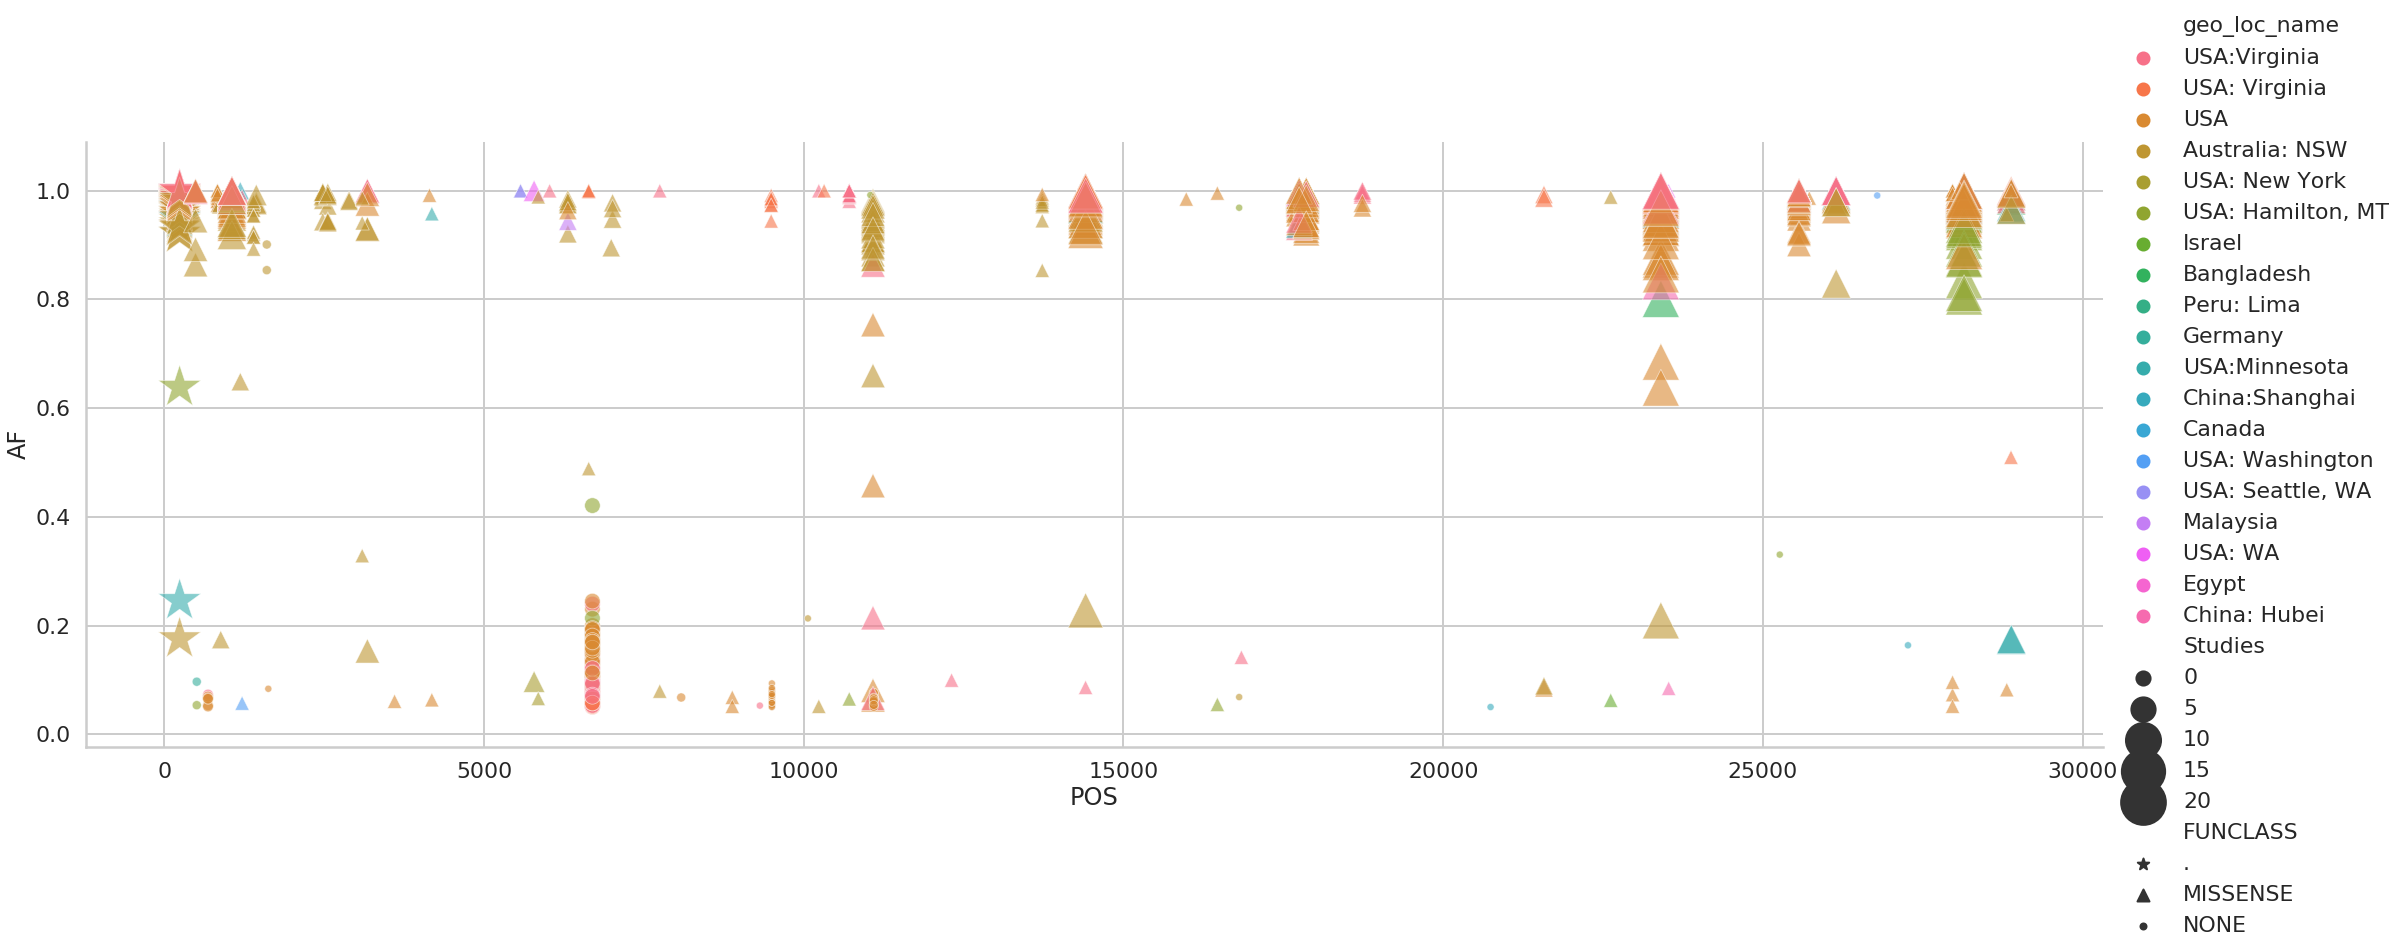

In [143]:
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}
sns.relplot(x='POS',y='AF',data=pysqldf('select *, maxAF-minAF as AFrange from va where maxAF >= 0.95 and minAF < 0.95 and Studies > 1 and FUNCLASS != "SILENT"'),legend='brief',alpha=0.6,sizes=(200,2000),markers=markers,height=10,aspect=3,size='Studies',hue='geo_loc_name',style="FUNCLASS")

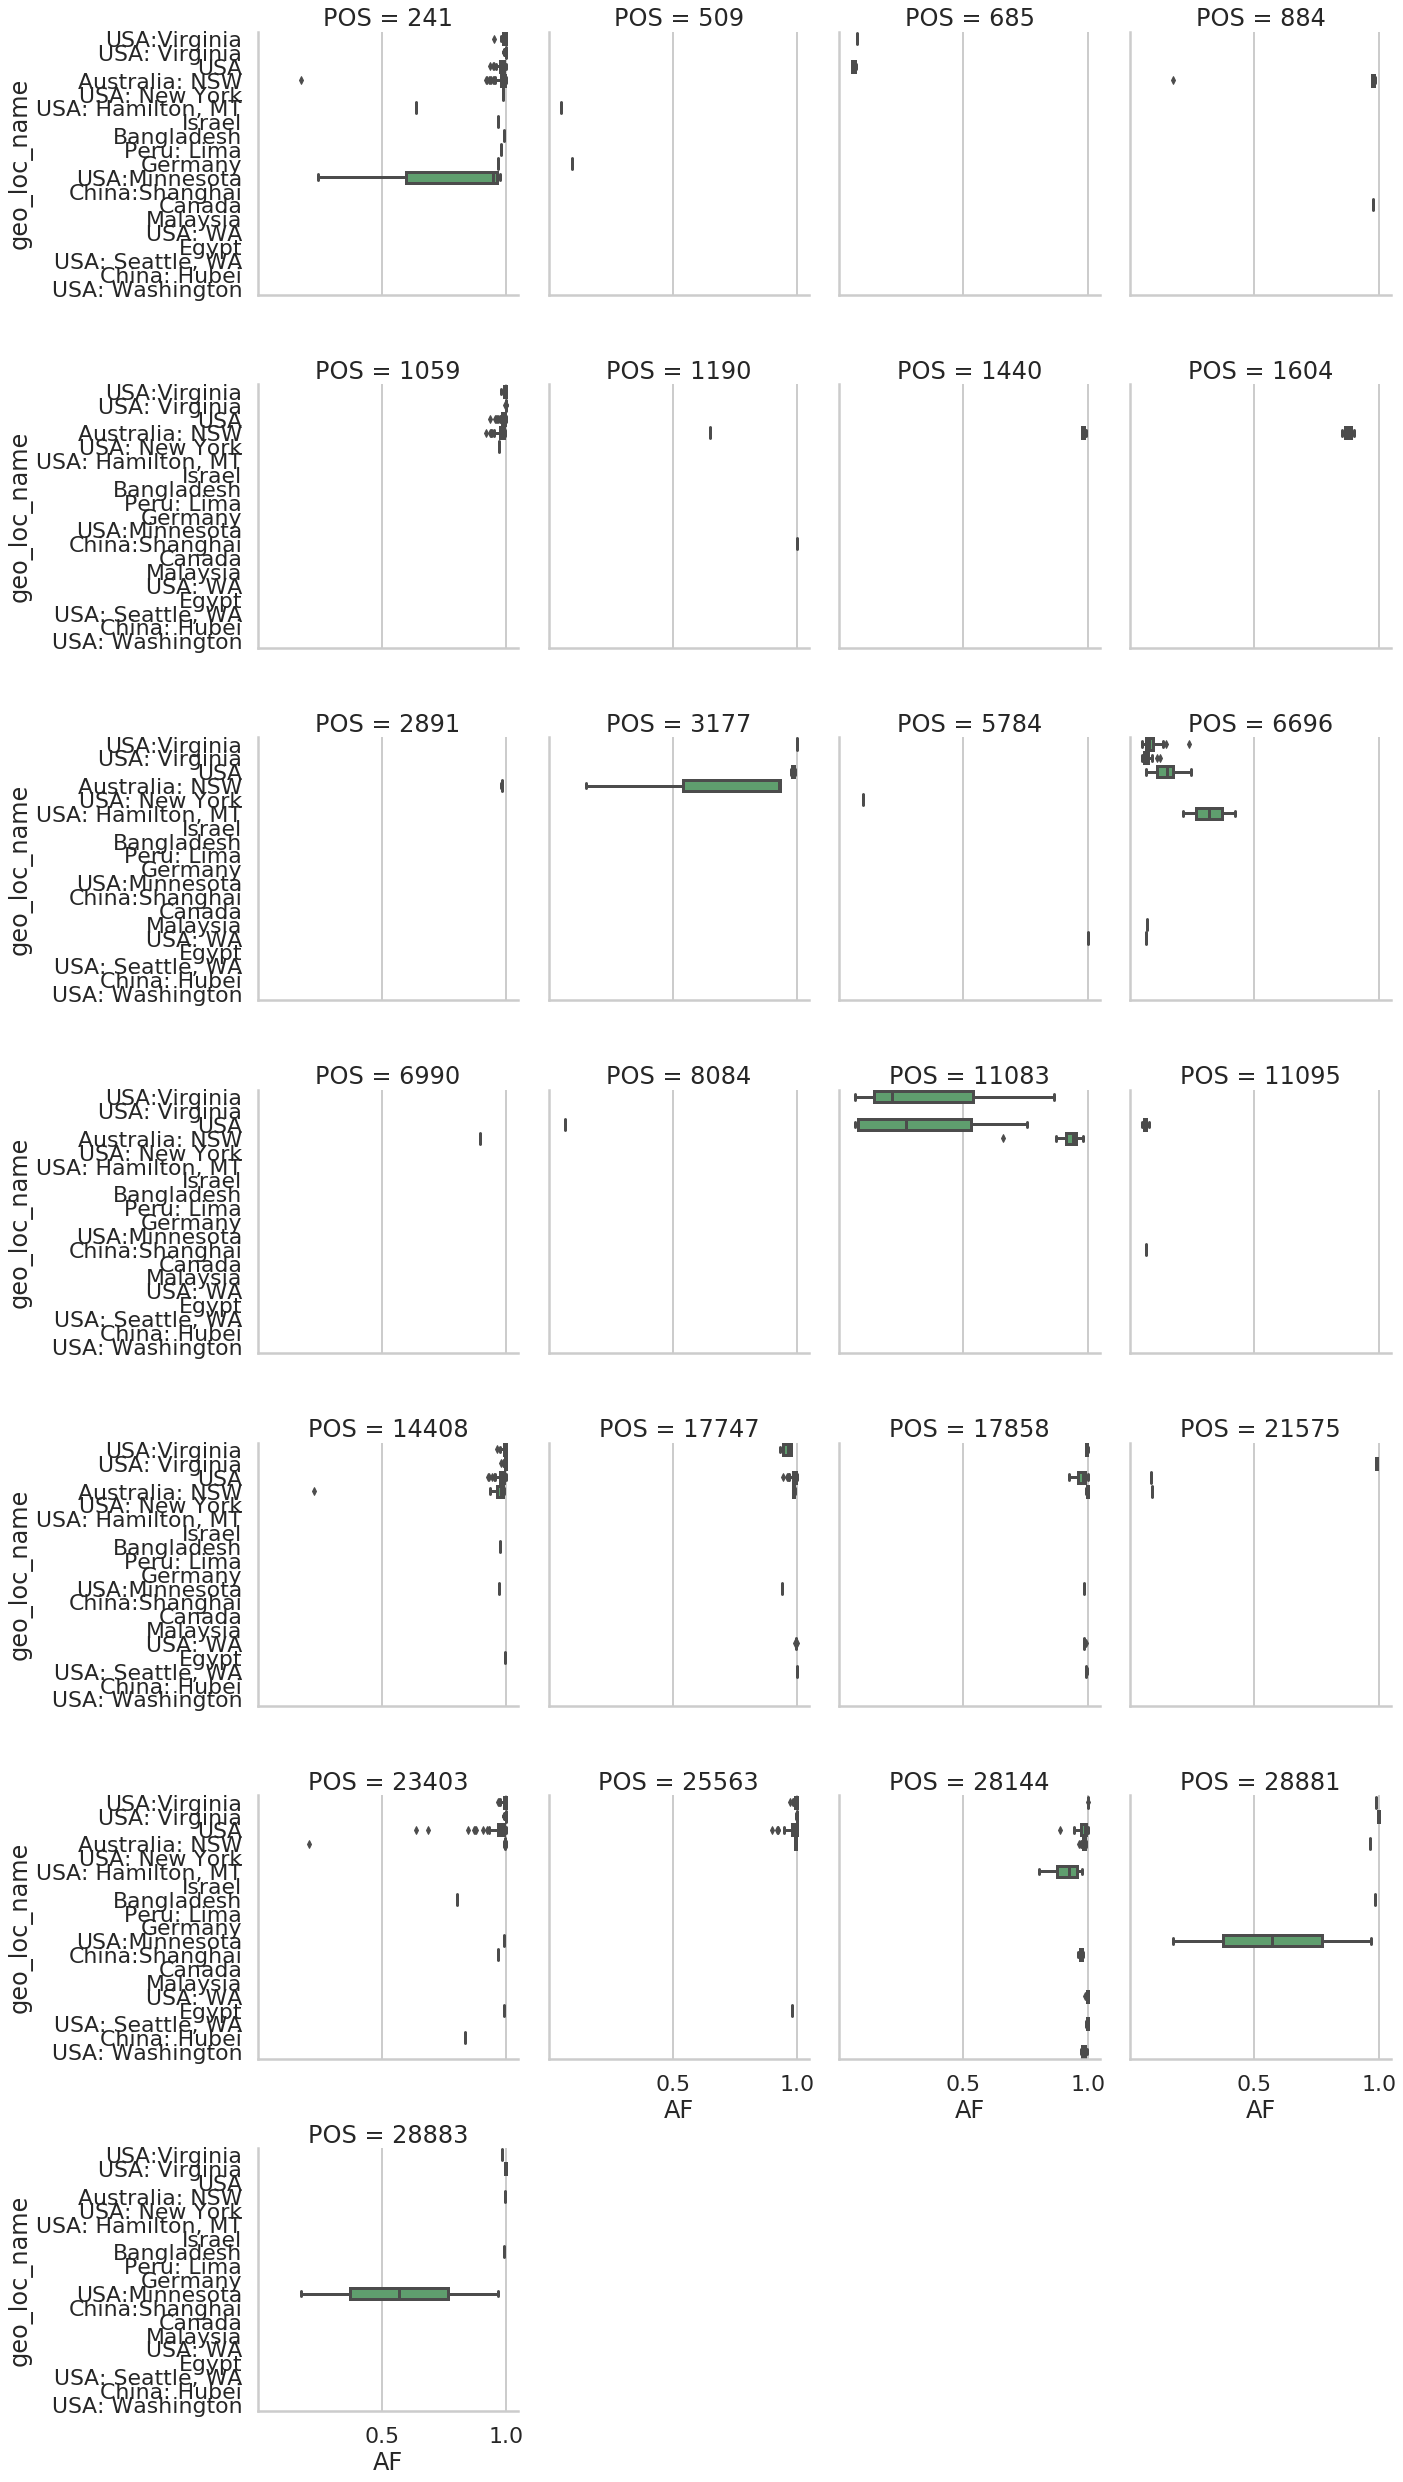

In [144]:
a = pysqldf('select POS, change, rangeAF, Studies from va where Studies > 2 and minAF < .95 and maxAF > 0.95 and rangeAF > .5 and FUNCLASS != "SILENT" group by POS, change order by Studies desc')[['POS','change']]
sns.catplot(x = 'AF', y='geo_loc_name', data = pysqldf('select va.* from va join a on va.POS = a.POS and va.change = a.change'),height=5,col="POS",kind='box',color='g',col_wrap=4)

## Comparison with sites under selection

In [145]:
sel = pd.read_csv('https://raw.githubusercontent.com/veg/SARS-CoV-2/segmented/data/comparative-annotation.tsv',sep='\t')

In [146]:
sel

genomic_coordinate   gene  codon_in_gene consensus consensus_aa  \
0                    266  ORF1a              1       ATG            M   
1                    269  ORF1a              2       GAG            E   
2                    272  ORF1a              3       AGC            S   
3                    275  ORF1a              4       CTT            L   
4                    278  ORF1a              5       GTC            V   
...                  ...    ...            ...       ...          ...   
7713               29516      N            415       GAC            D   
7714               29519      N            416       TCA            S   
7715               29522      N            417       ACT            T   
7716               29525      N            418       CAG            Q   
7717               29528      N            419       GCC            A   

      genomes  syn_sites  nonsyn_sites  \
0       40605   0.009248       2.99965   
1       40605   0.663786       2.00739   
2       40605   0.928678       2.08106   
3       40605   1.002960       2.00708   
4       40605   1.003350       2.00669   
...       ...        ...           ...   
7713    40771   0.825309       2.18293   
7714    40771   1.002890       1.82806   
7715    40771   1.002400       2.00584   
7716    40771   0.418297       1.76564   
7717    40771   1.003000       2.00601   

                                           variants          aa_variants  \
0                                   ATG:40604|TTG:1          M:40604|L:1   
1                 GAG:40593|GAT:5|GGG:4|AAG:2|GAA:1  E:40594|D:5|G:4|K:2   
2                            AGC:40586|AGT:17|AGA:2          S:40603|R:2   
3                                   CTT:40601|ATT:4          L:40601|I:4   
4                             GTC:40600|GTT:4|ATC:1          V:40604|I:1   
...                                             ...                  ...   
7713              GAC:40756|GAT:7|NNN:4|GAN:3|NAC:1              D:40763   
7714              TCA:40759|NNN:4|TTA:3|TCT:3|TCN:2          S:40764|L:3   
7715  ACT:40757|ATT:5|NNN:4|GCT:2|NCT:1|ACN:1|ACC:1      T:40759|I:5|A:2   
7716        CAG:40748|CAA:9|CAT:4|NNN:4|CAN:4|NAG:2          Q:40757|H:4   
7717  GCC:40752|NNN:8|GCT:3|ACC:3|TCC:2|GCA:2|GNC:1      A:40757|T:3|S:2   

      total_maf  selection  epidosic_selection  multiple_clades  trend  \
0      0.000025          0                   0                0    NaN   
1      0.000296          0                   0                0    NaN   
2      0.000468          0                   0                0    1.0   
3      0.000099          0                   0                0    1.0   
4      0.000123          0                   0                0    1.0   
...         ...        ...                 ...              ...    ...   
7713   0.000368          0                   0                0    NaN   
7714   0.000294         -1                   0                0    NaN   
7715   0.000343          0                   0                0    NaN   
7716   0.000564          0                   0                0    NaN   
7717   0.000466          0                   0                0    NaN   

      epitopes                                related_selection  \
0          0.0                                              NaN   
1          0.0                                              NaN   
2          0.0                                              NaN   
3          0.0                                              NaN   
4          0.0  GTC:GTT:GCT:CAC:CCC:CTC:GCA:GCC:GCG:GGC:GTA:GTG   
...        ...                                              ...   
7713      -1.0                                          GAT:GAC   
7714       0.0                                  TCA:TCT:TCC:TCG   
7715       0.0                                  ACT:ACC:ACA:ACG   
7716       0.0                                              NaN   
7717       0.0                                  GCT:GCC:GCA:GCG   

     predicted_va

In [147]:
sel['score'].fillna(0,inplace=True)

In [148]:
pysqldf('select count(*) from sel where score>0')

count(*)
0       126

In [149]:
pysqldf('select count(*) from sel where score>4')

count(*)
0        18

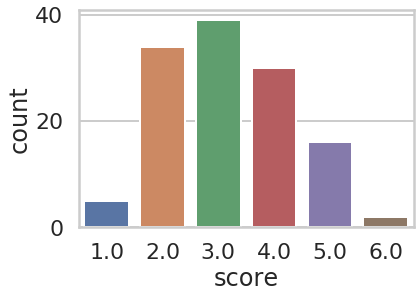

In [150]:
sns.countplot(x='score',data=sel[sel['score']>0])
#plt.yscale('log')

In [151]:
va = pysqldf('select va.*,consensus, score, aa_variants,multiple_clades, related_selection from va left join sel on POS >= genomic_coordinate and POS <= genomic_coordinate+2')

In [152]:
va['score'].fillna(0,inplace=True)

In [153]:
va

Sample    POS REF ALT    DP        AF  SB            DP4 IMPACT  \
0     SRR11772222    241   C   T  1205  0.991701   0    0,0,589,614      .   
1     SRR11607614    241   C   T  1433  0.985345   0    0,0,613,816      .   
2     SRR11858001    241   C   T   966  0.998965   0    0,1,459,506      .   
3     SRR11607659     61   G   T   716  0.054469   0   554,122,34,6      .   
4     SRR11607659    241   C   T  3000  0.986333   0  0,0,1355,1643      .   
...           ...    ...  ..  ..   ...       ...  ..            ...    ...   
7026  SRR11851957  13536   C   T   798  0.984962   7    2,1,200,595    LOW   
7027  SRR11851956  13536   C   T   727  0.994498   0    0,0,238,489    LOW   
7028  SRR11851949  13536   C   T  1795  0.994429   0   0,1,567,1225    LOW   
7029  SRR11851955  13536   C   T   352  0.988636   0    0,0,113,239    LOW   
7030  SRR11851953  13536   C   T  1832  0.992904   0   0,0,707,1124    LOW   

     FUNCLASS             EFFECT    GENE    CODON change study_accession  \
0           .                  .       .        .     CT       SRP256957   
1           .                  .       .        .     CT       SRP253926   
2           .                  .       .        .     CT       SRP256957   
3           .                  .       .        .     GT       SRP253926   
4           .                  .       .        .     CT       SRP253926   
...       ...                ...     ...      ...    ...             ...   
7026   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT       SRP253926   
7027   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT       SRP253926   
7028   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT       SRP253926   
7029   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT       SRP253926   
7030   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT       SRP253926   

     library_strategy library_source library_selection collection_date  \
0            AMPLICON      VIRAL RNA              cDNA         2020-04   
1            AMPLICON      VIRAL RNA               PCR            None   
2            AMPLICON      VIRAL RNA              cDNA         2020-04   
3            AMPLICON      VIRAL RNA               PCR            None   
4            AMPLICON      VIRAL RNA               PCR            None   
...               ...            ...               ...             ...   
7026         AMPLICON      VIRAL RNA               PCR            None   
7027         AMPLICON      VIRAL RNA               PCR            None   
7028         AMPLICON      VIRAL RNA               PCR            None   
7029         AMPLICON      VIRAL RNA               PCR            None   
7030         AMPLICON      VIRAL RNA               PCR            None   

       geo_loc_name   type func  start    end   A   C   G   T  Samples  \
0      USA:Virginia  5'UTR    .      0    265  67  63  55  80      608   
1              None  5'UTR    .      0    265  67  63  55  80      608   
2     USA: Virginia  5'UTR    .      0    265  67  63  55  80      608   
3              None  5'UTR    .      0    265  67  63  55  80        3   
4              None  5'UTR    .      0    265  67  63  55  80      608   
...             ...    ...  ...    ...    ...  ..  ..  ..  ..      ...   
7026           None   stem  S2b  13535  13542   1   2   3   1       14   
7027           None   stem  S2b  13535  13542   1   2   3   1       14   
7028           None   stem  S2b  13535  13542   1   2   3   1       14   
7029           None   stem  S2b  13535  13542   1   2   3   1       14   
7030           None   stem  S2b  13535  13542   1   2   3   1       14   

      Studies  Strategies   up down  mid left right     minAF     maxAF  \
0          16           6  TTC  CGT  TCG    T     G  0.175439  1.000000   
1          16           6  TTC  CGT  TCG    T     G  0.175439  1.000000   
2          16           6  TTC  CGT  TCG    T     G  0.175439  1.000000   
3           3           1  CTG  GTT  TGT    T     T  0.054469  0.143357   
4       

In [154]:
pysqldf('select count(distinct POS) from va')

count(distinct POS)
0                  613

In [155]:
pysqldf('select count(distinct POS) from va where FUNCLASS = "MISSENSE"')

count(distinct POS)
0                  308

In [156]:
pysqldf('select count(distinct POS) from va where score > 0 and FUNCLASS = "MISSENSE"')

count(distinct POS)
0                   19

In [157]:
pysqldf('select count(distinct POS) from va where score > 4 and FUNCLASS = "MISSENSE"')

count(distinct POS)
0                    6

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

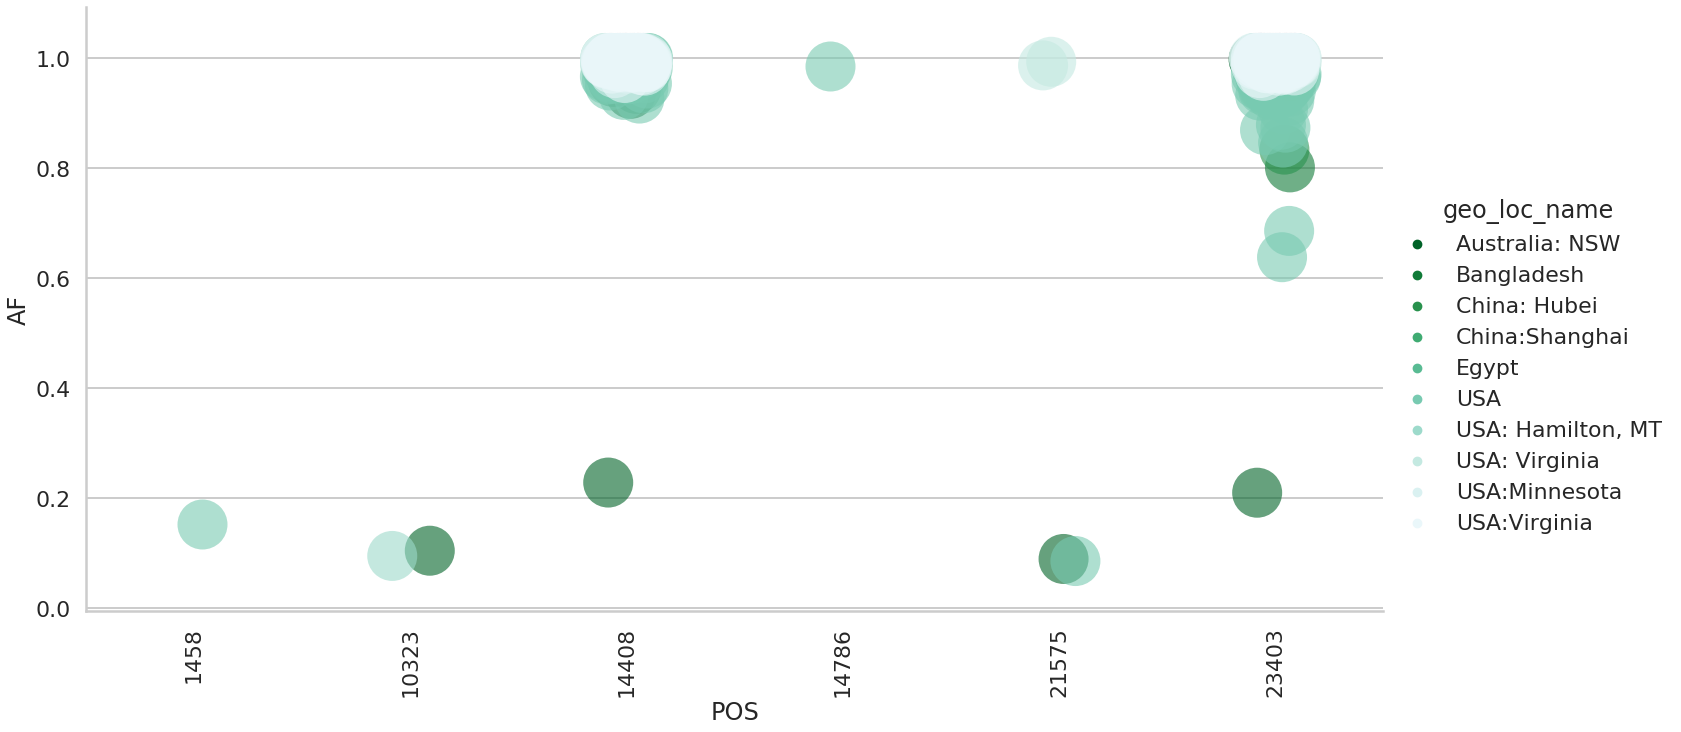

In [158]:
sns.catplot(x='POS', y = 'AF', data = pysqldf('select * from va where score > 4 and FUNCLASS = "MISSENSE" order by geo_loc_name'),height=10, aspect=2,hue='geo_loc_name',s=50,alpha=.6,palette="BuGn_r")
plt.xticks(rotation=90)

In [159]:
va[va['Sample']=='SRR11728606']

Sample  POS REF ALT   DP        AF  SB          DP4 IMPACT FUNCLASS  \
243  SRR11728606  241   C   T  985  0.990863   0  0,0,430,554      .        .   

    EFFECT GENE CODON change study_accession library_strategy library_source  \
243      .    .     .     CT       SRP253926         AMPLICON      VIRAL RNA   

    library_selection collection_date geo_loc_name   type func  start  end  \
243               PCR            None         None  5'UTR    .      0  265   

      A   C   G   T  Samples  Studies  Strategies   up down  mid left right  \
243  67  63  55  80      608       16           6  TTC  CGT  TCG    T     G   

        minAF  maxAF   rangeAF consensus  score aa_variants  multiple_clades  \
243  0.175439    1.0  0.824561      None    0.0        None              NaN   

    related_selection  
243              None

In [160]:
pysqldf('select * from sel where genomic_coordinate > 25560 and genomic_coordinate < 25565')

genomic_coordinate   gene  codon_in_gene consensus consensus_aa  genomes  \
0               25561  ORF3a             57       CAG            Q    40953   
1               25564  ORF3a             58       AGC            S    40953   

   syn_sites  nonsyn_sites                                        variants  \
0   0.320339       2.05286     CAG:31369|CAT:9548|CAK:32|CAC:2|CAR:1|CGT:1   
1   0.817935       2.18206  AGC:40923|AAC:22|AGY:2|AGT:2|GGC:2|ARC:1|RGC:1   

          aa_variants  total_maf  selection  epidosic_selection  \
0  Q:31370|H:9550|R:1   0.234024          0                   0   
1    S:40927|N:22|G:2   0.000733          0                   0   

   multiple_clades  trend  epitopes  \
0                1    1.0       1.0   
1                1    2.0       0.0   

                                   related_selection predicted_variants  \
0  CAG:CAA:CAC:AAA:AGA:AGG:CAT:CCC:CCT:CGA:CGC:CG...               None   
1  AGC:AAT:AAA:AAC:ACC:AGA:AGG:AGT:ATA:ATC:CGC:CG...               None   

  unusual_variants  score  
0                4    0.0  
1                2    0.0

In [161]:
pysqldf('select * from sel where score > 5 order by genomic_coordinate ')

genomic_coordinate   gene  codon_in_gene consensus consensus_aa  genomes  \
0                1706  ORF1a            481       TCT            S    38428   
1               14408  ORF1b            314       CTT            L    39153   

   syn_sites  nonsyn_sites                                           variants  \
0   0.999315       2.00043                      TCT:38387|TYT:28|TTT:11|TAT:2   
1   0.935019       2.01708  CTT:28879|CCT:10230|CYT:28|CTC:7|TTT:6|ACT:1|T...   

                       aa_variants  total_maf  selection  epidosic_selection  \
0                 S:38387|F:11|Y:2   0.001067          1                   1   
1  L:28886|P:10230|F:6|T:1|S:1|H:1   0.738717          1                   1   

   multiple_clades  trend  epitopes related_selection predicted_variants  \
0                2    1.0       2.0                 1    TCT:TCA:TCC:TCG   
1                0    1.0       1.0                 1    CCA:CCT:CCC:CCG   

          unusual_variants  score  
0                  TTT:TAT    6.0  
1  CTT:ACT:TCT:TTT:CAT:CTC    6.0

In [162]:
print(pysqldf('select POS, change, func, Samples, Studies, Strategies, score, multiple_clades, related_selection from va where score > 4 and FUNCLASS = "MISSENSE" group by POS, change').to_markdown())

|    |   POS | change   | func   |   Samples |   Studies |   Strategies |   score |   multiple_clades |   related_selection |
|---:|------:|:---------|:-------|----------:|----------:|-------------:|--------:|------------------:|--------------------:|
|  0 |  1458 | GA       | nsp2   |         2 |         2 |            2 |       5 |                 2 |                   0 |
|  1 | 10323 | AG       | 3Cpro  |         2 |         2 |            2 |       5 |                 2 |                   1 |
|  2 | 14408 | CT       | RdRp   |       376 |        10 |            5 |       6 |                 0 |                   1 |
|  3 | 14786 | CT       | RdRp   |         2 |         2 |            2 |       5 |                 4 |                   0 |
|  4 | 21575 | CT       | S      |         4 |         3 |            2 |       5 |                 2 |                   1 |
|  5 | 23403 | AG       | S      |       399 |        11 |            4 |       5 |                29 |               

In [163]:
va.to_csv('variant_list.05.tsv',sep='\t')

In [164]:
# Generating sites-specific data for IGV
pysqldf('select "NC_045512" as chromosome,POS-1 as start, POS as end, EFFECT, FUNCLASS, REF,ALT,Samples, Studies, Strategies, minAF, maxAF, rangeAF, score, CODON, aa_variants from va group by POS, change').to_csv('variant_list.05.mut',sep='\t',index=False)

In [165]:
# Generating Sample-specific data for IGV
pysqldf('select "NC_045512" as chromosome,POS-1 as start, POS as end, Sample, FUNCLASS, REF,ALT,AF,score,CODON,aa_variants,Samples, Studies, Strategies from va').to_csv('variant_list.05.sample.mut',sep='\t',index=False)

In [166]:
annot

type  start    end          gc     A    C     G     T       func  \
1         5'UTR      0    265   44.528302    67   63    55    80          .   
4   mat_peptide    265    805   48.518519   135  116   146   143     leader   
5   mat_peptide    805   2719   39.864159   571  353   410   580       nsp2   
6   mat_peptide   2719   8554   35.904027  1874  978  1117  1866       nsp3   
7   mat_peptide   8554  10054   36.466667   399  266   281   554       nsp4   
8   mat_peptide  10054  10972   38.126362   258  163   187   310      3Cpro   
9   mat_peptide  10972  11842   36.321839   210  144   172   344       nsp6   
10  mat_peptide  11842  12091   38.152610    79   49    46    75       nsp7   
11  mat_peptide  12091  12685   38.383838   193  107   121   173       nsp8   
12  mat_peptide  12685  13024   40.117994   105   64    72    98       nsp9   
13  mat_peptide  13024  13441   42.446043   116   84    93   124      nsp10   
14  mat_peptide  13441  16236   37.280859   846  501   541   907       RdRp   
15  mat_peptide  16236  18039   38.158625   547  337   351   568   helicase   
16  mat_peptide  18039  19620   38.266920   464  289   316   512       ExoN   
17  mat_peptide  19620  20658   34.007707   344  150   203   341      endoR   
18  mat_peptide  20658  21552   35.458613   282  143   174   295     MethTr   
20  mat_peptide  13441  13480   46.153846     8    7    11    13      nsp11   
21    stem_loop  13475  13503   60.714286     5    9     8     6     FS SL1   
22    stem_loop  13487  13542   56.363636    12   16    15    12     FS SL2   
24          CDS  21562  25384   37.310309  1125  723   703  1271          S   
26          CDS  25392  26220   39.492754   225  174   153   276      orf3a   
28          CDS  26244  26472   38.157895    49   45    42    92          E   
30          CDS  26522  27191   42.600897   171  146   139   213          M   
32          CDS  27201  27387   27.956989    68   26    26    66       orf6   
34          CDS  27393  27759   38.251366   108   79    61   118      orf7a   
36          CDS  27755  27887   31.060606    31   24    17    60      orf7b   
38          CDS  27893  28259   35.792350   101   64    67   134       orf8   
40          CDS  28273  29533   47.222222   400  315   280   265          N   
42          CDS  29557  29674   34.188034    35   21    19    42      orf10   
43    stem_loop  29608  29644   36.111111    13    7     6    10  3-UTR SL1   
44    stem_loop  29628  29657   31.034483    12    4     5     8  3-UTR SL2   
45        3'UTR  29674  29903   36.244541    93   36    47    53          .   
46    stem_loop  29727  29768   56.097561    11   10    13     7        S2M   
47         head  13469  13474   40.000000     0    0     2     3       head   
48         stem  13475  13484   55.555556     2    1     4     2        S1b   
49         loop  13485  13487  100.000000     0    1     1     0         L1   
50         stem  13488  13494   83.333333     0    3     2     1        S2b   
51         stem  13495  13504   44.444444     2    3     1     3        S1b   
52         stem  13505  13513   75.000000     2    3     3     0        S3b   
53         loop  13514  13522   37.500000     3    2     1     2         L2   
54         stem  13523  13532   44.444444     1    1     3     4        S3b   
55         loop  13533  13534    0.000000     0    0     0     1         L3   
56         stem  13535  13542   71.428571     1    2     3     1        S2b   
57         tail  13543  13546   33.333333     0    0     1     2       tail   

      gene strandedness     L  
1        .            .   265  
4   orf1ab            .   540  
5   orf1ab            .  1914  
6   orf1ab            .  5835  
7   orf1ab            .  1500  
8   orf1ab            .   918  
9   orf1ab            .   870  
10  orf1ab            .   249  
11  orf1ab            .   594  
12  orf1ab            .   339  
13  orf1ab            .   417  
14  orf1ab            .  2795  
15  orf1ab            .  1803  
16  orf

In [167]:
print(pysqldf('select POS, change, minAF, maxAF, rangeAF, Samples, Studies, Strategies from va where POS > 28880 and POS < 28884 group by POS, change').to_markdown())

|    |   POS | change   |    minAF |    maxAF |   rangeAF |   Samples |   Studies |   Strategies |
|---:|------:|:---------|---------:|---------:|----------:|----------:|----------:|-------------:|
|  0 | 28881 | GA       | 0.173554 | 1        |  0.826446 |        14 |         7 |            3 |
|  1 | 28882 | GA       | 0.173554 | 0.998553 |  0.824999 |        14 |         7 |            3 |
|  2 | 28883 | GC       | 0.175    | 0.997683 |  0.822683 |        14 |         7 |            3 |


In [175]:
pysqldf('select * from va where study_accession="SRP265005" and POS=9924')

Empty DataFrame
Columns: [Sample, POS, REF, ALT, DP, AF, SB, DP4, IMPACT, FUNCLASS, EFFECT, GENE, CODON, change, study_accession, library_strategy, library_source, library_selection, collection_date, geo_loc_name, type, func, start, end, A, C, G, T, Samples, Studies, Strategies, up, down, mid, left, right, minAF, maxAF, rangeAF, consensus, score, aa_variants, multiple_clades, related_selection]
Index: []

In [199]:
pysqldf('select * from var where ( Sample = "SRR11859158" or Sample = "SRR11859169" or Sample = "SRR11859147" ) and POS = 9924')

Sample      CHROM   POS REF ALT   DP        AF  SB          DP4  \
0  SRR11859169  NC_045512  9924   C   T  267  0.996255   0  0,0,146,121   

     IMPACT  FUNCLASS                 EFFECT    GENE    CODON change  \
0  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab  gCa/gTa     CT   

  study_accession library_strategy library_source library_selection  \
0       SRP265005         AMPLICON    METAGENOMIC               PCR   

  collection_date geo_loc_name  
0            None         None

In [202]:
pysqldf('select * from var where POS >= 9923 and POS <= 9926 order by Sample')

Sample      CHROM   POS  REF ALT    DP        AF  SB             DP4  \
0    ERR4165092  NC_045512  9924   CA   C  2430  0.002881   0   1191,1233,3,4   
1   SRR11397718  NC_045512  9925    A   C   888  0.018018   2    685,186,14,2   
2   SRR11577873  NC_045512  9924  CAA   C  1091  0.005500   0     890,195,5,1   
3   SRR11578196  NC_045512  9923    G   T   720  0.019444   1    580,115,11,3   
4   SRR11578202  NC_045512  9924   CA   C   888  0.010135  12     723,156,5,4   
5   SRR11578202  NC_045512  9924    C   T   888  0.007883   2     723,158,5,2   
6   SRR11578202  NC_045512  9926   AT   A   891  0.006734   5     727,158,4,2   
7   SRR11578235  NC_045512  9923    G   T   922  0.016269   1    752,155,12,3   
8   SRR11578251  NC_045512  9926   AT   A  2267  0.003529   4    1766,494,5,3   
9   SRR11578289  NC_045512  9924    C   T   918  0.006536   1     710,200,5,2   
10  SRR11578302  NC_045512  9923    G   A  2113  0.908661   0    1,0,1608,503   
11  SRR11578356  NC_045512  9924    C  CA   707  0.032532   1    549,135,18,5   
12  SRR11578375  NC_045512  9924   CA   C   811  0.003699   0     642,166,3,0   
13  SRR11607649  NC_045512  9924   CA   C  3707  0.001349   0   2168,1538,3,2   
14  SRR11621807  NC_045512  9924   CA   C   111  0.018018   6       58,51,0,2   
15  SRR11695900  NC_045512  9924   CA   C  1179  0.139949   4  829,186,130,35   
16  SRR11695900  NC_045512  9926    A   T  1188  0.137205   4  818,185,130,36   
17  SRR11779972  NC_045512  9924   CA   C   118  0.016949   3       61,55,2,0   
18  SRR11813132  NC_045512  9924   CA   C  2003  0.001997   1    1245,756,2,2   
19  SRR11826995  NC_045512  9924    C  CA   913  0.003286   7     675,238,1,2   
20  SRR11859169  NC_045512  9924    C   T   267  0.996255   0     0,0,146,121   

      IMPACT  FUNCLASS                 EFFECT    GENE     CODON change  \
0       HIGH      NONE            FRAME_SHIFT  orf1ab      atg/    CAC   
1        LOW    SILENT      SYNONYMOUS_CODING  orf1ab   gcA/gcC     AC   
2       HIGH      NONE            FRAME_SHIFT  orf1ab   gcaatg/   CAAC   
3   MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab   Gca/Tca     GT   
4       HIGH      NONE            FRAME_SHIFT  orf1ab      atg/    CAC   
5   MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab   gCa/gTa     CT   
6       HIGH      NONE            FRAME_SHIFT  orf1ab      atg/    ATA   
7   MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab   Gca/Tca     GT   
8       HIGH      NONE            FRAME_SHIFT  orf1ab      atg/    ATA   
9   MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab   gCa/gTa     CT   
10  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab   Gca/Aca     GA   
11      HIGH      NONE            FRAME_SHIFT  orf1ab  atg/aAtg    CCA   
12      HIGH      NONE            FRAME_SHIFT  orf1ab      atg/    CAC   
13      HIGH      NONE            FRAME_SHIFT  orf1ab      atg/    CAC   
14      HIGH      NONE            FRAME_SHIFT  orf1ab      atg/    CAC   
15      HIGH      NONE            FRAME_SHIFT  orf1ab      atg/    CAC   
16  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab   Atg/Ttg     AT   
17      HIGH      NONE            FRAME_SHIFT  orf1ab      atg/    CAC   
18      HIGH      NONE            FRAME_SHIFT  orf1ab      atg/    CAC   
19      HIGH      NONE            FRAME_SHIFT  orf1ab  atg/aAtg    CCA   
20  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab   gCa/gTa     CT   

   study_accession library_strategy library_source library_selection  \
0        ERP121228         AMPLICON      VIRAL RNA               PCR   
1        SRP253798         AMPLICON      VIRAL RNA               PCR   
2        SRP253798         AMPLICON      VIRAL RNA               PCR   
3        SRP253798         AMPLICON      VIRAL RNA               PCR   
4        SRP253798         AMPLICON      VIRAL RNA               PCR   
5        SRP253798         AMPLICON      VIRAL RNA               PCR   
6        SRP253798         AMPLICON      VIRAL RNA               PCR   
7        SRP253798   